In [1]:
import pandas as pd
import seaborn as sns #visulasiation
from langdetect import detect #language detection
import matplotlib.pyplot as plt
import string #for punctuation check
import sys #check for encoding
from nltk.corpus import stopwords #for removing stopwords
from textblob import TextBlob # spelling correction
from nltk.stem import WordNetLemmatizer #lemmatizing
from nltk.stem import PorterStemmer #stemming
import numpy as np 
import cv2
from PIL import Image
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Data Preparation

In [2]:
df=pd.read_csv('./songs_last.csv')

In [3]:
print('Dataset has {} rows and {} columns'.format(len(df), len(df.columns)))
df.columns

Dataset has 12000 rows and 5 columns


Index(['ID', 'Name', 'Singer', 'Category', 'Lyrics'], dtype='object')

In [4]:
df = df.rename(columns=lambda x: x.replace('ID', 'Link')) # changing column name 'id' as 'link'

In [5]:
df.dtypes

Link        object
Name        object
Singer      object
Category    object
Lyrics      object
dtype: object

In [6]:
df.Category.unique()

array(['pop', 'indie', 'rap', 'country', 'jazz', 'rnb', 'electronic',
       'folk', 'metal', 'alternative', 'house', 'hip-hop'], dtype=object)

In [7]:
df.head()

Link             Name  \
0  https://www.last.fm//music/Michael+Jackson/_/B...      Billie Jean   
1  https://www.last.fm//music/Mary+Juane+Clair/_/...  The Gentle Rain   
2  https://www.last.fm//music/Lady+Gaga/_/Poker+Face       Poker Face   
3  https://www.last.fm//music/Mary+Juane+Clair/_/...         Si clair   
4  https://www.last.fm//music/Nelly+Furtado/_/Say...     Say It Right   

             Singer Category  \
0   Michael Jackson      pop   
1  Mary Juane Clair      pop   
2         Lady Gaga      pop   
3  Mary Juane Clair      pop   
4     Nelly Furtado      pop   

                                              Lyrics  
0  She was more like a beauty queen from a movie ...  
1                                                NaN  
2  Mum mum mum mah Mum mum mum mah Mum mum mum ma...  
3                                                NaN  
4  In the day, in the night Say it right, say it ...

### Remove Missing Values

Number of missing values per columns :

In [8]:
print("\nNumber of missing values:\n",df.isnull().sum())


Number of missing values:
 Link           0
Name           0
Singer         0
Category       0
Lyrics      3629
dtype: int64


Removing rows that have any missing value:

In [9]:
df.dropna(inplace=True)
print('Dataset has {} rows and {} columns'.format(len(df), len(df.columns)))

Dataset has 8371 rows and 5 columns


Number of unique value per attribute

In [10]:
print ("Unique values :\n",df.nunique())

Unique values :
 Link        6836
Name        6432
Singer      1527
Category      12
Lyrics      6768
dtype: int64


Above table shows the number of unique elements by each attribute. The interpretation of this table is that each unique song is not categoriezed by only one genre. Therefore, multi label classification algorithms should apply for the classification of lyrics by genre. And the data structure should be adapted to be able to apply multilabel algorithms.

In [11]:
#sample for duplicated songs
df.loc[df['Name'] == 'Mr. Brightside']

Link            Name  \
1006  https://www.last.fm//music/The+Killers/_/Mr.+B...  Mr. Brightside   
1093  https://www.last.fm//music/The+Killers/_/Mr.+B...  Mr. Brightside   
9021  https://www.last.fm//music/The+Killers/_/Mr.+B...  Mr. Brightside   
9352  https://www.last.fm//music/The+Killers/_/Mr.+B...  Mr. Brightside   

           Singer     Category  \
1006  The Killers        indie   
1093  The Killers        indie   
9021  The Killers  alternative   
9352  The Killers  alternative   

                                                 Lyrics  
1006  I'm coming out of my cage and I've been doing ...  
1093  I'm coming out of my cage and I've been doing ...  
9021  I'm coming out of my cage and I've been doing ...  
9352  I'm coming out of my cage and I've been doing ...

In [12]:
#create unique ID per song
df['ID'] = pd.factorize(df.Link)[0]
cols = list(df.columns)
cols = [cols[-1]] + cols[:-1]
df = df[cols]
#set index per song as ID
df=df.set_index(df.columns[0])
df.head()

Link             Name  \
ID                                                                       
0   https://www.last.fm//music/Michael+Jackson/_/B...      Billie Jean   
1   https://www.last.fm//music/Lady+Gaga/_/Poker+Face       Poker Face   
2   https://www.last.fm//music/Nelly+Furtado/_/Say...     Say It Right   
3   https://www.last.fm//music/Katy+Perry/_/I+Kiss...  I Kissed a Girl   
4   https://www.last.fm//music/Michael+Jackson/_/B...          Beat It   

             Singer Category  \
ID                             
0   Michael Jackson      pop   
1         Lady Gaga      pop   
2     Nelly Furtado      pop   
3        Katy Perry      pop   
4   Michael Jackson      pop   

                                               Lyrics  
ID                                                     
0   She was more like a beauty queen from a movie ...  
1   Mum mum mum mah Mum mum mum mah Mum mum mum ma...  
2   In the day, in the night Say it right, say it ...  
3   This was never the way I planned, not my inten...  
4   They told him don't you ever come around here ...

### Transformation of data to multi-label task

In [13]:
#get dummies
dummy = pd.get_dummies(df['Category'])
dummy.head()

alternative  country  electronic  folk  hip-hop  house  indie  jazz  \
ID                                                                        
0             0        0           0     0        0      0      0     0   
1             0        0           0     0        0      0      0     0   
2             0        0           0     0        0      0      0     0   
3             0        0           0     0        0      0      0     0   
4             0        0           0     0        0      0      0     0   

    metal  pop  rap  rnb  
ID                        
0       0    1    0    0  
1       0    1    0    0  
2       0    1    0    0  
3       0    1    0    0  
4       0    1    0    0

In [14]:
dummy = dummy.rename(columns=lambda x: x.replace('hip-hop', 'hiphop'))

In [15]:
dfd = pd.concat([df, dummy], axis=1)  
dfd.drop(['Category', 'Link'], inplace=True, axis=1)
dfd.head()

Name           Singer  \
ID                                     
0       Billie Jean  Michael Jackson   
1        Poker Face        Lady Gaga   
2      Say It Right    Nelly Furtado   
3   I Kissed a Girl       Katy Perry   
4           Beat It  Michael Jackson   

                                               Lyrics  alternative  country  \
ID                                                                            
0   She was more like a beauty queen from a movie ...            0        0   
1   Mum mum mum mah Mum mum mum mah Mum mum mum ma...            0        0   
2   In the day, in the night Say it right, say it ...            0        0   
3   This was never the way I planned, not my inten...            0        0   
4   They told him don't you ever come around here ...            0        0   

    electronic  folk  hiphop  house  indie  jazz  metal  pop  rap  rnb  
ID                                                                      
0            0     0       0      0      0     0      0    1    0    0  
1            0     0       0      0      0     0      0    1    0    0  
2            0     0       0      0      0     0      0    1    0    0  
3            0     0       0      0      0     0      0    1    0    0  
4            0     0       0      0      0     0      0    1    0    0

In [16]:
dfd.shape

(8371, 15)

In [17]:
#convert dummies to multilabel dummies
dum=dfd.groupby(dfd.index).sum()
dum.head()
print(len(dum))

6836


In [18]:
dfd = dfd.loc[~dfd.index.duplicated(keep='first')] # removing dublicated songs
print(len(dfd))
dfu=dfd.drop(list(dfd)[3:15], axis=1) # remove single labelled dummies
df = pd.concat([dfu, dum], axis=1) #concatenate multi labelled dummies with rest of dataset
df.head()

6836


Name           Singer  \
ID                                     
0       Billie Jean  Michael Jackson   
1        Poker Face        Lady Gaga   
2      Say It Right    Nelly Furtado   
3   I Kissed a Girl       Katy Perry   
4           Beat It  Michael Jackson   

                                               Lyrics  alternative  country  \
ID                                                                            
0   She was more like a beauty queen from a movie ...            0        0   
1   Mum mum mum mah Mum mum mum mah Mum mum mum ma...            0        0   
2   In the day, in the night Say it right, say it ...            0        0   
3   This was never the way I planned, not my inten...            0        0   
4   They told him don't you ever come around here ...            0        0   

    electronic  folk  hiphop  house  indie  jazz  metal  pop  rap  rnb  
ID                                                                      
0            0     0       0      0      0     0      0    1    0    1  
1            1     0       0      0      0     0      0    1    0    0  
2            0     1       1      0      0     0      0    1    0    1  
3            0     0       0      0      0     0      0    1    0    0  
4            0     0       0      0      0     0      0    1    0    1

In [19]:
df.shape

(6836, 15)

In [20]:
df.nunique()

Name           6432
Singer         1527
Lyrics         6768
alternative       3
country           3
electronic        3
folk              3
hiphop            3
house             3
indie             3
jazz              2
metal             3
pop               3
rap               3
rnb               3
dtype: int64

In [21]:
df.alternative.unique()

array([0, 1, 2], dtype=uint64)

In [22]:
df.loc[df['Name'] == 'Mr. Brightside']

Name       Singer  \
ID                                 
847  Mr. Brightside  The Killers   

                                                Lyrics  alternative  country  \
ID                                                                             
847  I'm coming out of my cage and I've been doing ...            2        0   

     electronic  folk  hiphop  house  indie  jazz  metal  pop  rap  rnb  
ID                                                                       
847           0     0       0      0      2     0      0    0    0    0

It is surprised to see value of 2 in any dummy columns. However, this proves that some songs are duplicated on genre track list of last.fm. For example; if you go to link of alternative track list https://www.last.fm/tag/alternative/tracks?page=1 we see the 'Mr.Brightside' from The Killers as 22. on the list but there is exactly same song on 353. row.

In [23]:
df.loc[df['alternative'] == 2, 'alternative'] = 1
df.loc[df['country'] == 2, 'country'] = 1
df.loc[df['electronic'] == 2, 'electronic'] = 1
df.loc[df['folk'] == 2, 'folk'] = 1
df.loc[df['hiphop'] == 2, 'hiphop'] = 1
df.loc[df['house'] == 2, 'house'] = 1
df.loc[df['indie'] == 2, 'indie'] = 1
df.loc[df['metal'] == 2, 'metal'] = 1
df.loc[df['jazz'] == 2, 'jazz'] = 1
df.loc[df['pop'] == 2, 'pop'] = 1
df.loc[df['rap'] == 2, 'rap'] = 1
df.loc[df['rnb'] == 2, 'rnb'] = 1
df.nunique()

Name           6432
Singer         1527
Lyrics         6768
alternative       2
country           2
electronic        2
folk              2
hiphop            2
house             2
indie             2
jazz              2
metal             2
pop               2
rap               2
rnb               2
dtype: int64

In [24]:
df.loc[df['Name'] == 'Intro'] # dataset still contains some instrumental songs

Name  Singer             Lyrics  alternative  country  electronic  \
ID                                                                         
1021  Intro  The xx  Instrumental Song            1        0           1   

      folk  hiphop  house  indie  jazz  metal  pop  rap  rnb  
ID                                                            
1021     0       0      0      1     0      0    0    0    0

In [25]:
df.shape

(6836, 15)

### Word Counts

In [26]:
df['word_count'] = df['Lyrics'].str.split().str.len()
outliers = df.loc[df['word_count'] <= 10]
outliers.head()

Name        Singer                            Lyrics  \
ID                                                                         
1021               Intro        The xx                 Instrumental Song   
2262  Bobo On The Corner  Beastie Boys  only instrumental (no one talks)   
3086  Freddie Freeloader   Miles Davis                      INSTRUMENTAL   
3089   Flamenco Sketches   Miles Davis                      INSTRUMENTAL   
3137                Move   Miles Davis                      INSTRUMENTAL   

      alternative  country  electronic  folk  hiphop  house  indie  jazz  \
ID                                                                         
1021            1        0           1     0       0      0      1     0   
2262            0        0           0     0       0      0      0     0   
3086            0        0           0     0       0      0      0     1   
3089            0        0           0     0       0      0      0     1   
3137            0        0           0     0       0      0      0     1   

      metal  pop  rap  rnb  word_count  
ID                                      
1021      0    0    0    0           2  
2262      0    0    1    0           5  
3086      0    0    0    0           1  
3089      0    0    0    0           1  
3137      0    0    0    0           1

In [27]:
len(outliers)

86

First of all, instrumental songs should be excluded because of there is no lyrics for analysis and outliers which has less than 10 words should be elminated aswell. So elimintate the songs below than 10-words and above than 1300-words. 

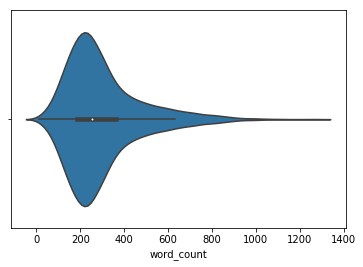

In [28]:
#remove outliers
df = df[df['word_count'] > 10]
df = df[df['word_count'] <= 1300]
sns.violinplot(x=df["word_count"])

In [29]:
len(df) # number of samples left

6748

### Language Detection

In [30]:
df['Language'] = df['Lyrics'].apply(detect)
df[df['Language'] != 'en'].head(5) # langdetect is not accurate 100%

Name    Singer  \
ID                                 
247     99 Luftballons      Nena   
477    La Camisa Negra    Juanes   
569  Dragostea Din Tei    O-Zone   
643    Summer Moved On      a-ha   
691         Daddy Cool  Boney M.   

                                                Lyrics  alternative  country  \
ID                                                                             
247  Hast du etwas Zeit für mich? Dann singe ich ei...            0        0   
477  Uno por pobre y feo, hombre Pero antoja'o, ay ...            0        0   
569  Mai-ia-hii Mai-ia-huu Mai-ia-ha Mai-ia-hahaMai...            0        0   
643  Indah walau sederhanasegera bergegas dari ruma...            0        0   
691  She's crazy like a fool What about it Daddy Co...            0        0   

     electronic  folk  hiphop  house  indie  jazz  metal  pop  rap  rnb  \
ID                                                                        
247           0     0       0      0      0     0      0    1    0    0   
477           0     0       0      0      0     0      0    1    0    0   
569           0     0       0      0      0     0      0    1    0    0   
643           0     0       0      0      0     0      0    1    0    0   
691           0     0       0      0      0     0      0    1    0    0   

     word_count Language  
ID                        
247         185       de  
477         333       es  
569         264       ro  
643          54       id  
691         114       cy

In [31]:
df['Language'].value_counts()

en    6612
de      64
es      16
id       8
tl       7
fr       7
so       6
pt       4
it       3
ca       3
sv       3
af       2
sl       2
da       2
cy       2
et       1
sw       1
nl       1
ro       1
hu       1
bn       1
cs       1
Name: Language, dtype: int64

In [32]:
df.loc[df['Name'] == 'Radioactivity'] # this song contains other languages but is assigned to english

Name     Singer  \
ID                               
4351  Radioactivity  Kraftwerk   

                                                 Lyrics  alternative  country  \
ID                                                                              
4351  Radioactivity Is in the air for you and meRadi...            0        0   

      electronic  folk  hiphop  house  indie  jazz  metal  pop  rap  rnb  \
ID                                                                         
4351           1     0       0      0      0     0      0    0    0    0   

      word_count Language  
ID                         
4351         123       en

In [33]:
non_english=df[df['Language'] != 'en']
non_english.to_csv('non_english.csv', index=False, encoding="utf-8")

In [34]:
print('There are {} songs which are not in English.'.format(len(df[df['Language'] != 'en'])))
df = df[df['Language'] == 'en']
print('Songs are not in English are eliminated!')
print('Now dataset has {} rows.'.format(len(df)))


There are 136 songs which are not in English.
Songs are not in English are eliminated!
Now dataset has 6612 rows.


### Check for duplicated lyrics 

In [35]:
mask = df.Lyrics.duplicated(keep=False) 
duplicated=df[mask]
duplicated

Name             Singer  \
ID                                                          
1713                   Country Grammar              Nelly   
1976   Hard Knock Life (Ghetto Anthem)              JAY-Z   
2015                   Hard Knock Life              JAY-Z   
2197          Country Grammar (Hot...)              Nelly   
4517                               Tha         Aphex Twin   
4601                        Pulsewidth         Aphex Twin   
6460  Infinity 2008 (Klaas Vocal Edit)  Guru Josh Project   
6491                     Infinity 2008  Guru Josh Project   

                                                 Lyrics  alternative  country  \
ID                                                                              
1713  Hmm, I'm goin' down down baby, yo' street in a...            0        0   
1976  Check the bassline out, uh huh Jigga, uh huh, ...            0        0   
2015  Check the bassline out, uh huh Jigga, uh huh, ...            0        0   
2197  Hmm, I'm goin' down down baby, yo' street in a...            0        0   
4517  Could those little drops of water meeting unde...            0        0   
4601  Could those little drops of water meeting unde...            0        0   
6460  Here's my key Philosophy A freak like me Just ...            0        0   
6491  Here's my key Philosophy A freak like me Just ...            0        0   

      electronic  folk  hiphop  house  indie  jazz  metal  pop  rap  rnb  \
ID                                                                         
1713           0     0       1      0      0     0      0    0    1    0   
1976           0     0       1      0      0     0      0    0    1    0   
2015           0     0       0      0      0     0      0    0    1    0   
2197           0     0       0      0      0     0      0    0    1    0   
4517           1     0       0      0      0     0      0    0    0    0   
4601           1     0       0      0      0     0      0    0    0    0   
6460           0     0       0      1      0     0      0    0    0    0   
6491           0     0       0      1      0     0      0    0    0    0   

      word_count Language  
ID                         
1713         790       en  
1976         592       en  
2015         592       en  
2197         790       en  
4517         158       en  
4601         158       en  
6460         102       en  
6491         102       en

These songs have exactly same lyrics but are considered as different songs. 
For example; https://www.last.fm//music/Nelly/_/Country+Grammar and https://www.last.fm//music/Nelly/_/Country+Grammar+(Hot...)
This finding shows that there are factors other than lyrics that play a significant role in defining song genres. The assumption is that the genre of the songs may differs by audios features such as beat, rhythm, timbre. However, that proves that the lyrics of a song itself is not enough to decide on its genre, and it restricts this research. In order to not to reduce the accuracy of algorithms, these songs are excluded from this study.

In [36]:
df = df.drop_duplicates(subset='Lyrics', keep='first')
len(df)

6608

# Exploratory Data Analysis 

### Songs per Genre

In [37]:
genres = list(df.columns.values)
genres = genres[3:15]
print(genres)

['alternative', 'country', 'electronic', 'folk', 'hiphop', 'house', 'indie', 'jazz', 'metal', 'pop', 'rap', 'rnb']


In [38]:
# Calculating number of songs in each genre
counts = []
for genre in genres:
    counts.append((genre, df[genre].sum()))
df_stats = pd.DataFrame(counts, columns=['Genre', 'number of songs'])
df_stats

Genre  number of songs
0   alternative              832
1       country              821
2    electronic              575
3          folk              587
4        hiphop              681
5         house              261
6         indie              795
7          jazz              468
8         metal              789
9           pop              836
10          rap              662
11          rnb              759

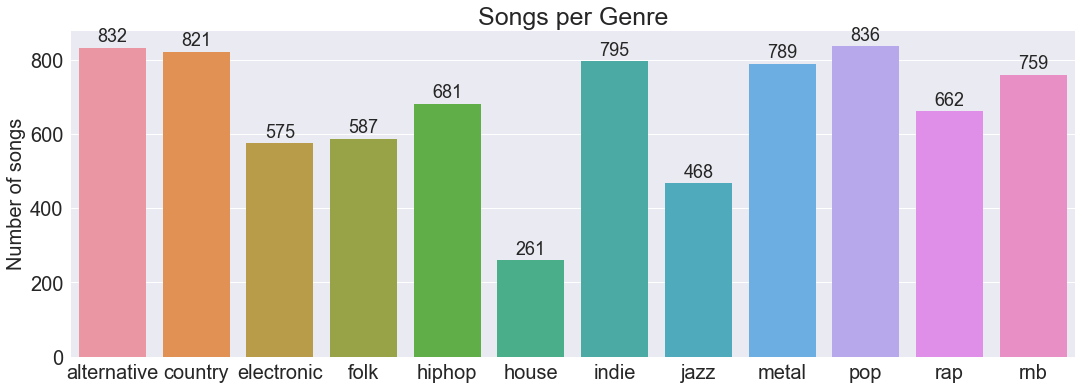

In [39]:
#Number of Songs per genre
categories = list(df.columns.values)
cat=categories[3:15]
sns.set(font_scale = 2)
plt.figure(figsize=(18,6))
a=df.iloc[:,3:15].sum().values
ax= sns.barplot(cat, a)
plt.title("Songs per Genre", fontsize=25)
plt.ylabel('Number of songs', fontsize=20)
#adding the text labels
rects = ax.patches
labels = a
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.savefig('songspergenre.png')
plt.show()

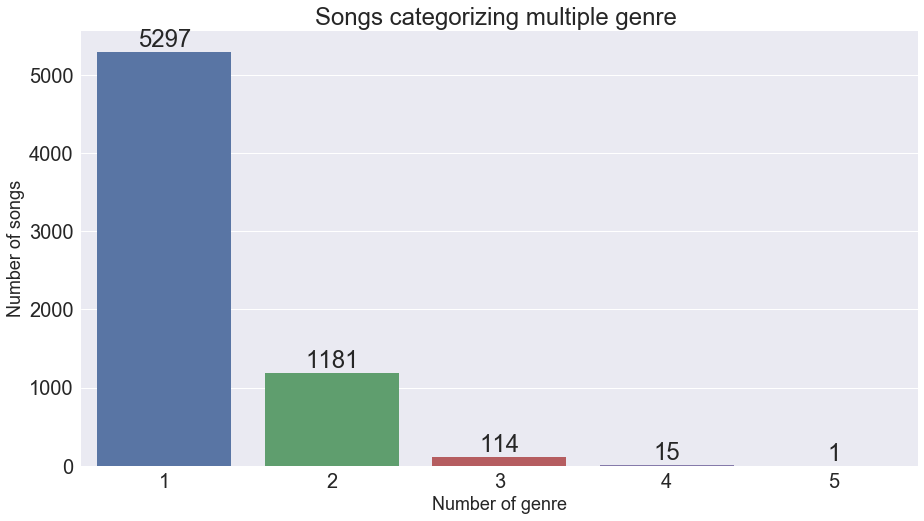

In [40]:
rowSums = df.iloc[:, 3:15].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Songs categorizing multiple genre ")
plt.ylabel('Number of songs', fontsize=18)
plt.xlabel('Number of genre', fontsize=18)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.savefig('songsmultigenre.png')
plt.show()

### Correlation Matrix 

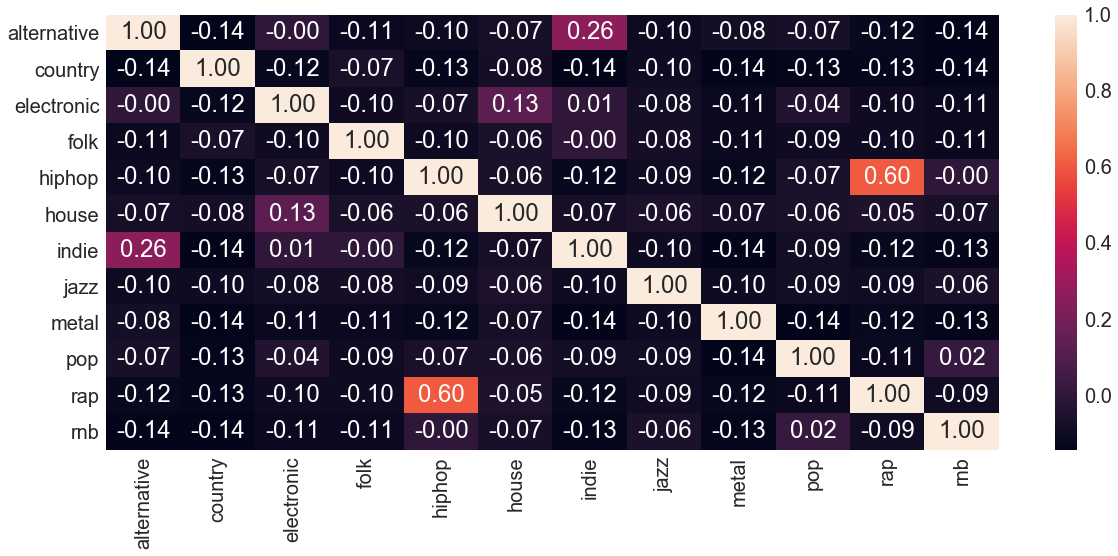

In [41]:
plt.figure(figsize = (20,8))
sns.heatmap((df.loc[:, ['alternative','country','electronic','folk','hiphop','house','indie','jazz','metal','pop','rap','rnb']]).corr(),
            annot=True,linewidths=0.0, fmt='.2f')

In [42]:
#song per artist
artist = df["Singer"].value_counts()
artist.head(10)

Eminem              83
Metallica           82
Johnny Cash         77
Bob Dylan           72
System of a Down    60
Iron Maiden         55
Radiohead           52
Sade                52
Madonna             44
Nightwish           43
Name: Singer, dtype: int64

In [43]:
len(df)

6608

# Text Pre-processing

#### Remove Punctuation

In [44]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [45]:
df.loc[9,'Lyrics']

"Time goes by so slowly Time goes by so slowly Time goes by so slowly Time goes by so slowly Time goes by so slowly Time goes by so slowly(...) Every little thing that you say or do I'm hung up I'm hung up on you Waiting for your call Baby, night and day I'm fed upI'm tired of waiting for you. Time goes by so slowly for those who wait No time to hesitate Those who run seem to have all the fun I'm caught upI don't know what to do Time goes by so slowly Time goes by so slowly Time goes by so slowlyI don't know what to do Every little thing that you say or do I'm hung up I'm hung up on you Waiting for your call Baby, night and day I'm fed upI'm tired of waiting on you Every little thing that you say or do I'm hung up I'm hung up on you Waiting for your call Baby, night and day I'm fed upI'm tired of waiting on you Ring, ring, ring goes the telephone The lights are on but there's no one home Tick tick tock, it's a quarter to two And I'm doneI'm hanging up on you I can't keep on waiting for

In [46]:
df['Lyrics1'] = df['Lyrics'].str.replace("'", '') # önce tirnak isaretini kaldirdik araya bosluk koymasin diye
df.loc[9,'Lyrics1']

'Time goes by so slowly Time goes by so slowly Time goes by so slowly Time goes by so slowly Time goes by so slowly Time goes by so slowly(...) Every little thing that you say or do Im hung up Im hung up on you Waiting for your call Baby, night and day Im fed upIm tired of waiting for you. Time goes by so slowly for those who wait No time to hesitate Those who run seem to have all the fun Im caught upI dont know what to do Time goes by so slowly Time goes by so slowly Time goes by so slowlyI dont know what to do Every little thing that you say or do Im hung up Im hung up on you Waiting for your call Baby, night and day Im fed upIm tired of waiting on you Every little thing that you say or do Im hung up Im hung up on you Waiting for your call Baby, night and day Im fed upIm tired of waiting on you Ring, ring, ring goes the telephone The lights are on but theres no one home Tick tick tock, its a quarter to two And Im doneIm hanging up on you I cant keep on waiting for you I know that you

In [47]:
df.loc[8,'Lyrics1']

'Oh-oh-oh-oh-oooh Oh-oh-oh-oh-oooh, oh-oh-oh Caught in a bad romance Oh-oh-oh-oh-oooh Oh-oh-oh-oh-oooh, oh-oh-oh Caught in a bad romanceRah, rah-ah-ah-ah Roma, roma-ma Gaga, ooh-la-la Want your bad romanceRah, rah-ah-ah-ah Roma, roma-ma Gaga, ooh-la-la Want your bad romanceI want your ugly, I want your disease I want your everything as long as its free I want your love, love, love, love I want your loveI want your drama, the touch of your hand I want your leather-studded kiss in the sand I want your love, love, love, love I want your love (love, love, love, I want your love)You know that I want you And you know that I need you I want it bad, your bad romanceI want your love, and I want your revenge You and me could write a bad romance I want your love and all your lovers revenge You and me could write a bad romanceOh-oh-oh-oh-oooh Oh-oh-oh-oh-oooh, oh-oh-oh Caught in a bad romance Oh-oh-oh-oh-oooh Oh-oh-oh-oh-oooh, oh-oh-oh Caught in a bad romanceRah, rah-ah-ah-ah Roma, roma-ma Gaga, o

In [48]:
df.loc[3,'Lyrics1']

'This was never the way I planned, not my intention I got so brave, drink in hand, lost my discretion Its not what Im used to, just wanna try you on Im curious for you, caught my attentionI kissed a girl and I liked it The taste of her cherry chap stick I kissed a girl just to try it I hope my boyfriend dont mind itIt felt so wrong, it felt so right Dont mean Im in love tonight I kissed a girl and I liked it, I liked itNo, I dont even know your name, it doesnt matter Youre my experimental game, just human nature Its not what good girls do, not how they should behave My head gets so confused, hard to obeyI kissed a girl and I liked it The taste of her cherry chap stick I kissed a girl just to try it I hope my boyfriend dont mind itIt felt so wrong, it felt so right Dont mean Im in love tonight I kissed a girl and I liked it, I liked itUs girls we are so magical Soft skin, red lips, so kissable Hard to resist, so touchable Too good to deny itAint no big deal, its innocentI kissed a girl 

In [49]:
df['Lyrics1'] = df['Lyrics1'].str.replace('[^\w\s]',' ').str.replace('  ', ' ').str.replace('   ', ' ').str.replace('    ', ' ').str.replace('     ', ' ')
df.loc[9,'Lyrics1']

'Time goes by so slowly Time goes by so slowly Time goes by so slowly Time goes by so slowly Time goes by so slowly Time goes by so slowly Every little thing that you say or do Im hung up Im hung up on you Waiting for your call Baby night and day Im fed upIm tired of waiting for you Time goes by so slowly for those who wait No time to hesitate Those who run seem to have all the fun Im caught upI dont know what to do Time goes by so slowly Time goes by so slowly Time goes by so slowlyI dont know what to do Every little thing that you say or do Im hung up Im hung up on you Waiting for your call Baby night and day Im fed upIm tired of waiting on you Every little thing that you say or do Im hung up Im hung up on you Waiting for your call Baby night and day Im fed upIm tired of waiting on you Ring ring ring goes the telephone The lights are on but theres no one home Tick tick tock its a quarter to two And Im doneIm hanging up on you I cant keep on waiting for you I know that youre still hes

#### Splitting Words 

In [50]:
df['Lyrics1'] = df['Lyrics1'].str.findall(r'[A-Z]?[^A-Z\s]+|[A-Z]+').apply(' '.join)

df.loc[8,'Lyrics1']

'Oh oh oh oh oooh Oh oh oh oh oooh oh oh oh Caught in a bad romance Oh oh oh oh oooh Oh oh oh oh oooh oh oh oh Caught in a bad romance Rah rah ah ah ah Roma roma ma Gaga ooh la la Want your bad romance Rah rah ah ah ah Roma roma ma Gaga ooh la la Want your bad romance I want your ugly I want your disease I want your everything as long as its free I want your love love love love I want your love I want your drama the touch of your hand I want your leather studded kiss in the sand I want your love love love love I want your love love love love I want your love You know that I want you And you know that I need you I want it bad your bad romance I want your love and I want your revenge You and me could write a bad romance I want your love and all your lovers revenge You and me could write a bad romance Oh oh oh oh oooh Oh oh oh oh oooh oh oh oh Caught in a bad romance Oh oh oh oh oooh Oh oh oh oh oooh oh oh oh Caught in a bad romance Rah rah ah ah ah Roma roma ma Gaga ooh la la Want your b

In [51]:
df.loc[3,'Lyrics1']

'This was never the way I planned not my intention I got so brave drink in hand lost my discretion Its not what Im used to just wanna try you on Im curious for you caught my attention I kissed a girl and I liked it The taste of her cherry chap stick I kissed a girl just to try it I hope my boyfriend dont mind it It felt so wrong it felt so right Dont mean Im in love tonight I kissed a girl and I liked it I liked it No I dont even know your name it doesnt matter Youre my experimental game just human nature Its not what good girls do not how they should behave My head gets so confused hard to obey I kissed a girl and I liked it The taste of her cherry chap stick I kissed a girl just to try it I hope my boyfriend dont mind it It felt so wrong it felt so right Dont mean Im in love tonight I kissed a girl and I liked it I liked it Us girls we are so magical Soft skin red lips so kissable Hard to resist so touchable Too good to deny it Aint no big deal its innocent I kissed a girl and I like

#### Removing Nan-Alpha 

In [52]:
df['Lyrics1'] = df['Lyrics1'].apply(lambda x: " ".join(x for x in str(x).split() if x.isalpha()))
df.loc[2202,'Lyrics1']

'I wonder if you know How they live in Tokyo If you seen it then you mean it Then you know you have to go Fast and furious Kitaa Drift Drift Drift Fast and furious Kitaa Drift Drift Drift I wonder if you know How they live in Tokyo If you seen it then you mean it Then you know you have to go Fast and furious Kitaa Drift Drift Drift Fast and furious Kitaa Drift Drift Drift へいらっしゃい おまちどうさま 喧騒まみれ この 街の演奏黙 ったまま一度ついて おいで 世界中魅了するほどに豪華な Japan 一番 Jump around さぁうちらの出番 Teriyaki Boyz in the place to be 見せてやる オリジナル はい in the VIP Many many diamonds danglin Bag full of money we stranglin Hate me fry me bake me try me All the above cause you cant get in I dont want no problem Because me professional Make you shake your ケツ Thank you Haters take it personal Like a 金田 対 鉄夫 Neo Tokyo 滅亡 無く なっちまう前に 熱を 発散しきっちまおうぜ lets go 熱望 ズヒルギロッポンラボからエスコート エエ スゴイ 号じゃない Negro 入力ソルの座標ピンポイント'

Removing non-alpha characters do not work for japanese characters, therefore non-ascii characters can be removed

#### Removing Non- Ascii Characters

In [53]:
#Check for encoding
print(sys.getdefaultencoding())

utf-8


In [54]:
df.loc[2202,'Lyrics1']

'I wonder if you know How they live in Tokyo If you seen it then you mean it Then you know you have to go Fast and furious Kitaa Drift Drift Drift Fast and furious Kitaa Drift Drift Drift I wonder if you know How they live in Tokyo If you seen it then you mean it Then you know you have to go Fast and furious Kitaa Drift Drift Drift Fast and furious Kitaa Drift Drift Drift へいらっしゃい おまちどうさま 喧騒まみれ この 街の演奏黙 ったまま一度ついて おいで 世界中魅了するほどに豪華な Japan 一番 Jump around さぁうちらの出番 Teriyaki Boyz in the place to be 見せてやる オリジナル はい in the VIP Many many diamonds danglin Bag full of money we stranglin Hate me fry me bake me try me All the above cause you cant get in I dont want no problem Because me professional Make you shake your ケツ Thank you Haters take it personal Like a 金田 対 鉄夫 Neo Tokyo 滅亡 無く なっちまう前に 熱を 発散しきっちまおうぜ lets go 熱望 ズヒルギロッポンラボからエスコート エエ スゴイ 号じゃない Negro 入力ソルの座標ピンポイント'

In [55]:
df.loc[2765,'Lyrics1']

'Fall everything Fall everything Fall everything 흩어지네 Fall everything Fall everything Fall everything 떨어지네 너 땜에 나 이렇게 망가져 그만할래 이제 너 안 가져 못하겠어 뭣 같아서 제발 핑계 같은 건 삼가줘니가 나한테 이럼 안 돼 니가 한 모든 말은 안대 진실을 가리고 날 찢어 날 찍어 나 미쳐 다 싫어 전부 가져가 난 니가 그냥 미워 But youre my everything Youre my Everything Youre my Everything Youre my 제발 좀 꺼져 huh미안해 I hate u 사랑해 I hate u 용서해 I need you girl 왜 혼자 사랑하고 혼자서만 이별해 I need you girl 왜 다칠 걸 알면서 자꾸 니가 필요해 I need you girl 넌 아름다워 I need you girl 너무 차가워 I need you girl I need you girl I need you girl I need you girl It goes round round 나 왜 자꾸 돌아오지 I go down down 이쯤 되면 내가 바보지 나 무슨 짓을 해봐도 어쩔 수가 없다고 분명 내 심장 내 마음 내 가슴인데 왜 말을 안 듣냐고 또 혼잣말하네 또 혼잣말하네 또 혼잣말하네 또 혼잣말하네 넌 아무 말 안 해 아 제발 내가 잘할게 하늘은 또 파랗게 하늘은 또 파랗게 하늘이 파래서 햇살이 빛나서 내 눈물이 더 잘 보이나 봐 왜 나는 너인지 왜 하필 너인지 왜 너를 떠날 수가 없는지 I need you girl 왜 혼자 사랑하고 혼자서만 이별해 I need you girl 왜 다칠 걸 알면서 자꾸 니가 필요해 I need you girl 넌 아름다워 I need you girl 너무 차가워 I need you girl I need you girl I need you girl I need you girl Girl 차라리 차라리 헤어지자고 해줘 Girl 사랑이 사랑

Since we have non-ascii characters in our data, we remove them.

In [56]:
df['Lyrics1']=df['Lyrics1'].apply(lambda x: x.encode('ascii', 'replace').decode().replace("?", ""))
df['Lyrics1']=df['Lyrics1'].apply(lambda x: " ".join(x for x in str(x).split()))
df.loc[2202,'Lyrics1']

'I wonder if you know How they live in Tokyo If you seen it then you mean it Then you know you have to go Fast and furious Kitaa Drift Drift Drift Fast and furious Kitaa Drift Drift Drift I wonder if you know How they live in Tokyo If you seen it then you mean it Then you know you have to go Fast and furious Kitaa Drift Drift Drift Fast and furious Kitaa Drift Drift Drift Japan Jump around Teriyaki Boyz in the place to be in the VIP Many many diamonds danglin Bag full of money we stranglin Hate me fry me bake me try me All the above cause you cant get in I dont want no problem Because me professional Make you shake your Thank you Haters take it personal Like a Neo Tokyo lets go Negro'

#### Lower Case

In [57]:
df['Lyrics1'] = df['Lyrics1'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
df.loc[9,'Lyrics1']

'time goes by so slowly time goes by so slowly time goes by so slowly time goes by so slowly time goes by so slowly time goes by so slowly every little thing that you say or do im hung up im hung up on you waiting for your call baby night and day im fed up im tired of waiting for you time goes by so slowly for those who wait no time to hesitate those who run seem to have all the fun im caught up i dont know what to do time goes by so slowly time goes by so slowly time goes by so slowly i dont know what to do every little thing that you say or do im hung up im hung up on you waiting for your call baby night and day im fed up im tired of waiting on you every little thing that you say or do im hung up im hung up on you waiting for your call baby night and day im fed up im tired of waiting on you ring ring ring goes the telephone the lights are on but theres no one home tick tick tock its a quarter to two and im done im hanging up on you i cant keep on waiting for you i know that youre sti

In [58]:
df.loc[8,'Lyrics1']

'oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught in a bad romance oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught in a bad romance rah rah ah ah ah roma roma ma gaga ooh la la want your bad romance rah rah ah ah ah roma roma ma gaga ooh la la want your bad romance i want your ugly i want your disease i want your everything as long as its free i want your love love love love i want your love i want your drama the touch of your hand i want your leather studded kiss in the sand i want your love love love love i want your love love love love i want your love you know that i want you and you know that i need you i want it bad your bad romance i want your love and i want your revenge you and me could write a bad romance i want your love and all your lovers revenge you and me could write a bad romance oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught in a bad romance oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught in a bad romance rah rah ah ah ah roma roma ma gaga ooh la la want your b

#### Text normalization 

In [59]:
df['Lyrics1'] = df['Lyrics1'].str.replace(" dont ", ' do not ')
df['Lyrics1'] = df['Lyrics1'].str.replace(" im ", ' i am ')
df['Lyrics1'] = df['Lyrics1'].str.replace(" youre ", ' you are ')
df['Lyrics1'] = df['Lyrics1'].str.replace(" cant ", ' can not ')
df['Lyrics1'] = df['Lyrics1'].str.replace(" wont ", ' will not ')
df['Lyrics1'] = df['Lyrics1'].str.replace(" wasnt ", ' was not ')
df['Lyrics1'] = df['Lyrics1'].str.replace(" gonna ", ' going to ')
df['Lyrics1'] = df['Lyrics1'].str.replace(" theres ", ' there is ')
df['Lyrics1'] = df['Lyrics1'].str.replace(" youd ", ' you would ')
df['Lyrics1'] = df['Lyrics1'].str.replace(" heres ", ' here is ')
df['Lyrics1'] = df['Lyrics1'].str.replace(" ill ", ' i will ')
df['Lyrics1'] = df['Lyrics1'].str.replace(" ll ", '  will ')
df['Lyrics1'] = df['Lyrics1'].str.replace(" gotta ", ' have got to ')
df['Lyrics1'] = df['Lyrics1'].str.replace(" youve ", ' you have ')
df['Lyrics1'] = df['Lyrics1'].str.replace(" aint ", ' not ')
df['Lyrics1'] = df['Lyrics1'].str.replace(" ive ", ' i have ')
df['Lyrics1'] = df['Lyrics1'].str.replace(" wanna ", ' want to ')
df['Lyrics1'] = df['Lyrics1'].str.replace(" theyre ", ' they are ')

Manually normalization has been implemented. Because when I remove stopwords such as I, am , do ,not. They are supposed to be removed but if they appear in their short way like dont, im, etc they would stay because they are not written in correct way so that they are not in the stopwords list eventhough they have exactly same meaning.

In [60]:
df.loc[8,'Lyrics1']

'oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught in a bad romance oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught in a bad romance rah rah ah ah ah roma roma ma gaga ooh la la want your bad romance rah rah ah ah ah roma roma ma gaga ooh la la want your bad romance i want your ugly i want your disease i want your everything as long as its free i want your love love love love i want your love i want your drama the touch of your hand i want your leather studded kiss in the sand i want your love love love love i want your love love love love i want your love you know that i want you and you know that i need you i want it bad your bad romance i want your love and i want your revenge you and me could write a bad romance i want your love and all your lovers revenge you and me could write a bad romance oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught in a bad romance oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught in a bad romance rah rah ah ah ah roma roma ma gaga ooh la la want your b

In [61]:
df.loc[9,'Lyrics1']

'time goes by so slowly time goes by so slowly time goes by so slowly time goes by so slowly time goes by so slowly time goes by so slowly every little thing that you say or do i am hung up i am hung up on you waiting for your call baby night and day i am fed up i am tired of waiting for you time goes by so slowly for those who wait no time to hesitate those who run seem to have all the fun i am caught up i do not know what to do time goes by so slowly time goes by so slowly time goes by so slowly i do not know what to do every little thing that you say or do i am hung up i am hung up on you waiting for your call baby night and day i am fed up i am tired of waiting on you every little thing that you say or do i am hung up i am hung up on you waiting for your call baby night and day i am fed up i am tired of waiting on you ring ring ring goes the telephone the lights are on but there is no one home tick tick tock its a quarter to two and i am done i am hanging up on you i can not keep o

#### Remove Stopwords

In [62]:
stop = stopwords.words('english')
df['Lyrics1'] = df['Lyrics1'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))
df.loc[9,'Lyrics1']

'time goes slowly time goes slowly time goes slowly time goes slowly time goes slowly time goes slowly every little thing say hung hung waiting call baby night day fed tired waiting time goes slowly wait time hesitate run seem fun caught know time goes slowly time goes slowly time goes slowly know every little thing say hung hung waiting call baby night day fed tired waiting every little thing say hung hung waiting call baby night day fed tired waiting ring ring ring goes telephone lights one home tick tick tock quarter two done hanging keep waiting know still hesitating cry cause find way youll wake one day itll late every little thing say hung hung waiting call baby night day fed tired waiting every little thing every little thing hung hung waiting call waiting call fed tired waiting time goes slowly time goes slowly time goes slowly time goes slowly slowly slowly slowly slowly slowly slowly slowly slowly slowly slowly slowly slowly slowly slowly know every little thing say hung hung

In [63]:
df.loc[8,'Lyrics1']

'oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romance oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romance rah rah ah ah ah roma roma gaga ooh la la want bad romance rah rah ah ah ah roma roma gaga ooh la la want bad romance want ugly want disease want everything long free want love love love love want love want drama touch hand want leather studded kiss sand want love love love love want love love love love want love know want know need want bad bad romance want love want revenge could write bad romance want love lovers revenge could write bad romance oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romance oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romance rah rah ah ah ah roma roma gaga ooh la la want bad romance want horror want design cause criminal long mine want love love love love want love want psycho vertigo shtick want rear window baby sick want love love love love want love love love love want love know want know need cause free bitch baby 

In [64]:
df.loc[1879,'Lyrics1']

'knew nigga whose real name william primary concern making million illest hustler world ever seen used fuck moviestars sniff coke dreams corrupted young mind age thirteen nigga never father mom fiend put pipe every year sober sons heart simultaneously grew colder started hanging selling bags projects checking young chicks looking hit run prospects fascinated material objects understood money never bought respect built reputation cause could hustle steal got locked didnt hesitate squeal criminals chilled didnt think real see niggaz like never equal project insecurities people fiended props like addicts pipes needles felt prove everyone evil feeble minded young man infinite potetial product ghetto breed capatalistic mental coincidentally dropped school sell weed dancing devil smoked eyes would bleed sick selling trees gave greed everyone trying trife never face consequences probably month minor offenses ask nigga life another chance always wicked knew advance dance forever devil cold cel

In [65]:
df.loc[8,'Lyrics1']

'oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romance oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romance rah rah ah ah ah roma roma gaga ooh la la want bad romance rah rah ah ah ah roma roma gaga ooh la la want bad romance want ugly want disease want everything long free want love love love love want love want drama touch hand want leather studded kiss sand want love love love love want love love love love want love know want know need want bad bad romance want love want revenge could write bad romance want love lovers revenge could write bad romance oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romance oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romance rah rah ah ah ah roma roma gaga ooh la la want bad romance want horror want design cause criminal long mine want love love love love want love want psycho vertigo shtick want rear window baby sick want love love love love want love love love love want love know want know need cause free bitch baby 

#### Spelling Correction

In [66]:
Test1 = TextBlob("I tnd to spel wrds incorrectly")
Test1.correct()

TextBlob("I and to spell words incorrectly")

In [67]:
df.loc[8,'Lyrics1']

'oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romance oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romance rah rah ah ah ah roma roma gaga ooh la la want bad romance rah rah ah ah ah roma roma gaga ooh la la want bad romance want ugly want disease want everything long free want love love love love want love want drama touch hand want leather studded kiss sand want love love love love want love love love love want love know want know need want bad bad romance want love want revenge could write bad romance want love lovers revenge could write bad romance oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romance oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romance rah rah ah ah ah roma roma gaga ooh la la want bad romance want horror want design cause criminal long mine want love love love love want love want psycho vertigo shtick want rear window baby sick want love love love love want love love love love want love know want know need cause free bitch baby 

In [68]:
a=df.loc[8,'Lyrics1']
Test1 = TextBlob(a)
Test1.correct()

TextBlob("oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romance oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romance rah rah ah ah ah rome rome gage ooh la la want bad romance rah rah ah ah ah rome rome gage ooh la la want bad romance want ugly want disease want everything long free want love love love love want love want drama touch hand want leather studded kiss sand want love love love love want love love love love want love know want know need want bad bad romance want love want revenge could write bad romance want love lovers revenge could write bad romance oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romance oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romance rah rah ah ah ah rome rome gage ooh la la want bad romance want horror want design cause criminal long mine want love love love love want love want psychic vestige stick want rear window baby sick want love love love love want love love love love want love know want know need cause free bi

Spelling correction did not work well. For example, 'wanna' updated as a 'anna' by TextBlob so that we do not use this.

#### Lemmatizing

In [69]:
lemmatizer = WordNetLemmatizer()
df['Lyrics1'] = df['Lyrics1'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in x.split()]))
df.loc[8,'Lyrics1']

'oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romance oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romance rah rah ah ah ah rom rom gaga ooh la la want bad romance rah rah ah ah ah rom rom gaga ooh la la want bad romance want ugly want disease want everything long free want love love love love want love want drama touch hand want leather studded kiss sand want love love love love want love love love love want love know want know need want bad bad romance want love want revenge could write bad romance want love lover revenge could write bad romance oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romance oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romance rah rah ah ah ah rom rom gaga ooh la la want bad romance want horror want design cause criminal long mine want love love love love want love want psycho vertigo shtick want rear window baby sick want love love love love want love love love love want love know want know need cause free bitch baby want ba

#### Stemming

In [70]:
ps = PorterStemmer() 
df['Lyrics2'] = df['Lyrics1'].apply(lambda x: " ".join([ps.stem(w) for w in x.split()]))
df.loc[8,'Lyrics2']  

'oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romanc oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romanc rah rah ah ah ah rom rom gaga ooh la la want bad romanc rah rah ah ah ah rom rom gaga ooh la la want bad romanc want ugli want diseas want everyth long free want love love love love want love want drama touch hand want leather stud kiss sand want love love love love want love love love love want love know want know need want bad bad romanc want love want reveng could write bad romanc want love lover reveng could write bad romanc oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romanc oh oh oh oh oooh oh oh oh oh oooh oh oh oh caught bad romanc rah rah ah ah ah rom rom gaga ooh la la want bad romanc want horror want design caus crimin long mine want love love love love want love want psycho vertigo shtick want rear window babi sick want love love love love want love love love love want love know want know need caus free bitch babi want bad bad romanc want love 

Stemming modifies 'crazy' as 'crazi', 'baby' as 'babi' and 'romance' as 'romanc'.
So that I have decided not to use stemming.

In [71]:
df=df.drop(['Lyrics2'], axis=1)
df.head()

Name           Singer  \
ID                                     
0       Billie Jean  Michael Jackson   
1        Poker Face        Lady Gaga   
2      Say It Right    Nelly Furtado   
3   I Kissed a Girl       Katy Perry   
4           Beat It  Michael Jackson   

                                               Lyrics  alternative  country  \
ID                                                                            
0   She was more like a beauty queen from a movie ...            0        0   
1   Mum mum mum mah Mum mum mum mah Mum mum mum ma...            0        0   
2   In the day, in the night Say it right, say it ...            0        0   
3   This was never the way I planned, not my inten...            0        0   
4   They told him don't you ever come around here ...            0        0   

    electronic  folk  hiphop  house  indie  jazz  metal  pop  rap  rnb  \
ID                                                                       
0            0     0       0      0      0     0      0    1    0    1   
1            1     0       0      0      0     0      0    1    0    0   
2            0     1       1      0      0     0      0    1    0    1   
3            0     0       0      0      0     0      0    1    0    0   
4            0     0       0      0      0     0      0    1    0    1   

    word_count Language                                            Lyrics1  
ID                                                                          
0          462       en  like beauty queen movie scene said mind mean o...  
1          481       en  mum mum mum mah mum mum mum mah mum mum mum ma...  
2          253       en  day night say right say either got either stan...  
3          258       en  never way planned intention got brave drink ha...  
4          380       en  told ever come around want see face better dis...

# Feature Extraction

### Statistical Text Features

In [72]:
#Word count in each song:
df['count_word']=df["Lyrics1"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["Lyrics1"].apply(lambda x: len(set(str(x).split())))
df.head(2)

Name           Singer  \
ID                                 
0   Billie Jean  Michael Jackson   
1    Poker Face        Lady Gaga   

                                               Lyrics  alternative  country  \
ID                                                                            
0   She was more like a beauty queen from a movie ...            0        0   
1   Mum mum mum mah Mum mum mum mah Mum mum mum ma...            0        0   

    electronic  folk  hiphop  house  indie  jazz  metal  pop  rap  rnb  \
ID                                                                       
0            0     0       0      0      0     0      0    1    0    1   
1            1     0       0      0      0     0      0    1    0    0   

    word_count Language                                            Lyrics1  \
ID                                                                           
0          462       en  like beauty queen movie scene said mind mean o...   
1          481       en  mum mum mum mah mum mum mum mah mum mum mum ma...   

    count_word  count_unique_word  
ID                                 
0          199                 81  
1          374                 68

C:\Users\nesli\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'Counts of Words')

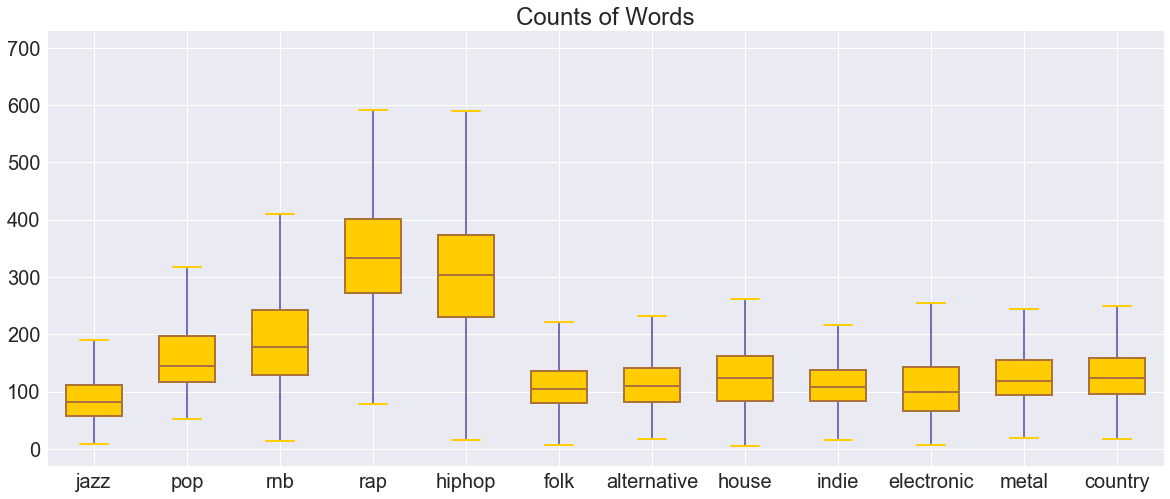

In [73]:
#Create subsets
jazz=df[df['jazz'] ==1 ].count_word
pop=df[df['pop'] ==1 ].count_word
rnb=df[df['rnb'] ==1 ].count_word
rap=df[df['rap'] ==1 ].count_word
hiphop=df[df['hiphop'] ==1 ].count_word
folk=df[df['folk'] ==1 ].count_word
alternative=df[df['alternative'] ==1 ].count_word
house=df[df['house'] ==1 ].count_word
electronic=df[df['electronic'] ==1 ].count_word
metal=df[df['metal'] ==1 ].count_word
indie=df[df['indie'] ==1 ].count_word
country=df[df['country'] ==1 ].count_word


## combine these different collections into a list    
data_plot = [jazz,pop,rnb,rap,hiphop,folk,alternative,house,indie,electronic,metal,country]

# Create a figure instance
fig = plt.figure(1, figsize=(20, 8))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data_plot)

## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_plot,widths=0.6, patch_artist=True)
#ax.set_ylim(ymax=1300)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#ac7339', linewidth=2)
    # change fill color
    box.set( facecolor = '#ffcc00' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#ffcc00', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#ac7339', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#ac7339', alpha=0.5)

## Custom x-axis labels
ax.set_xticklabels(['jazz', 'pop', 'rnb', 'rap','hiphop','folk', 'alternative','house','indie','electronic','metal','country'])
ax.set_title("Counts of Words")
## Remove top axes and right axes ticks
#ax.get_xaxis().tick_bottom()
#ax.get_yaxis().tick_left()

# Save the figure
#fig.savefig('fig.png', bbox_inches='tight')

C:\Users\nesli\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


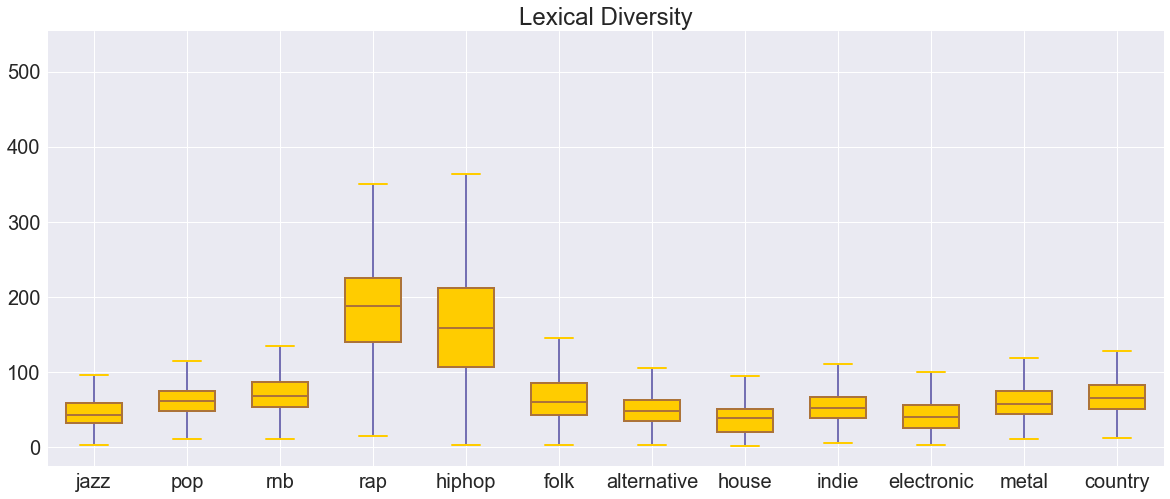

In [76]:
#Create subsets
jazz=df[df['jazz'] ==1 ].count_unique_word
pop=df[df['pop'] ==1 ].count_unique_word
rnb=df[df['rnb'] ==1 ].count_unique_word
rap=df[df['rap'] ==1 ].count_unique_word
hiphop=df[df['hiphop'] ==1 ].count_unique_word
folk=df[df['folk'] ==1 ].count_unique_word
alternative=df[df['alternative'] ==1 ].count_unique_word
house=df[df['house'] ==1 ].count_unique_word
electronic=df[df['electronic'] ==1 ].count_unique_word
metal=df[df['metal'] ==1 ].count_unique_word
indie=df[df['indie'] ==1 ].count_unique_word
country=df[df['country'] ==1 ].count_unique_word


## combine these different collections into a list    
data_to_plot = [jazz,pop,rnb,rap,hiphop,folk,alternative,house,indie,electronic,metal,country]

# Create a figure instance
fig = plt.figure(1, figsize=(20, 8))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data_to_plot)

## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_to_plot,widths=0.6, patch_artist=True)
#ax.set_ylim(ymax=1300)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#ac7339', linewidth=2)
    # change fill color
    box.set( facecolor = '#ffcc00' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#ffcc00', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#ac7339', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#ac7339', alpha=0.5)

## Custom x-axis labels
ax.set_xticklabels(['jazz', 'pop', 'rnb', 'rap','hiphop','folk', 'alternative','house','indie','electronic','metal','country'])
ax.set_title('Lexical Diversity')

## Remove top axes and right axes ticks
#ax.get_xaxis().tick_bottom()
#ax.get_yaxis().tick_left()

# Save the figure
fig.savefig('fig.png', bbox_inches='tight')

In [77]:
#derived features
#Word count percent in each song:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']

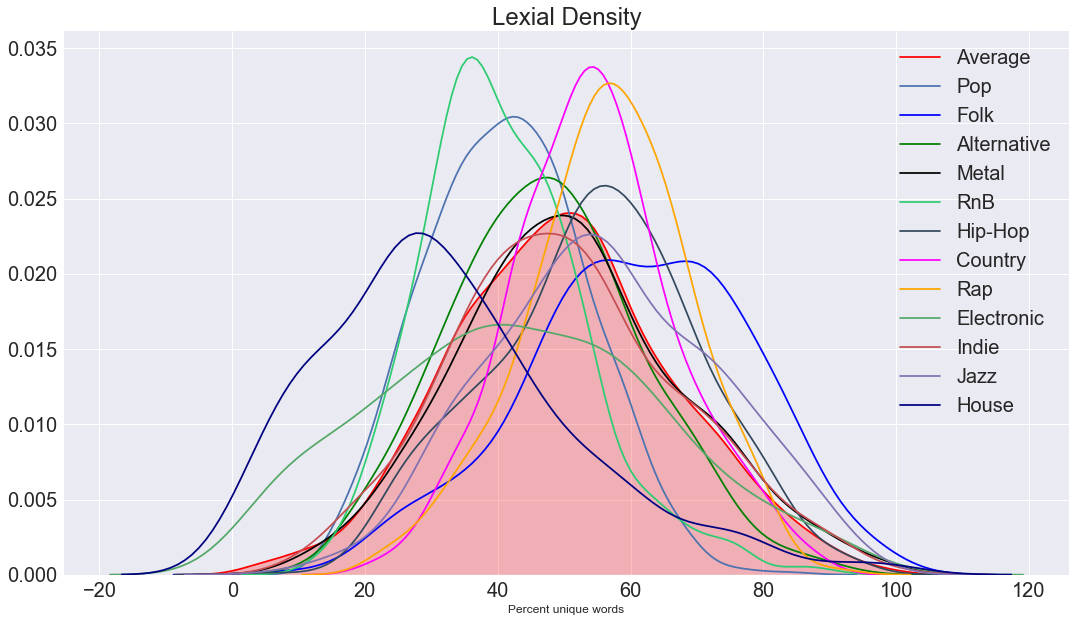

In [78]:
#plt.subplot2grid((2,2),(0,1))
sns.color_palette("bright")
plt.figure(figsize=(18,10))
plt.title("Lexial Density")
#sns.boxplot(x='clean', y='word_unique_percent', data=train_feats)
ax=sns.kdeplot(df['word_unique_percent'], label="Average",shade=True,color='r')
ax=sns.kdeplot(df[df['pop'] == 1].word_unique_percent, label="Pop")
ax=sns.kdeplot(df[df['folk'] == 1].word_unique_percent, label="Folk",color='b')
ax=sns.kdeplot(df[df['alternative'] == 1].word_unique_percent, label="Alternative", color="g")
ax=sns.kdeplot(df[df['metal'] == 1].word_unique_percent, label="Metal", color='black')
ax=sns.kdeplot(df[df['rnb'] == 1].word_unique_percent, label="RnB", color="#2ecc71")
ax=sns.kdeplot(df[df['hiphop'] == 1].word_unique_percent, label="Hip-Hop", color='#34495e')
ax=sns.kdeplot(df[df['country'] == 1].word_unique_percent, label="Country", color='fuchsia')
ax=sns.kdeplot(df[df['rap'] == 1].word_unique_percent, label="Rap", color='orange')
ax=sns.kdeplot(df[df['electronic'] == 1].word_unique_percent, label="Electronic")
ax=sns.kdeplot(df[df['indie'] == 1].word_unique_percent, label="Indie")
ax=sns.kdeplot(df[df['jazz'] == 1].word_unique_percent, label="Jazz")
ax=sns.kdeplot(df[df['house'] == 1].word_unique_percent, label="House", color='navy')
#ax=sns.kdeplot(train_feats[train_feats.clean == 1].word_unique_percent, label="Clean")
plt.legend()
#plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent unique words', fontsize=12)
plt.show()

C:\Users\nesli\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'Lexical Density')

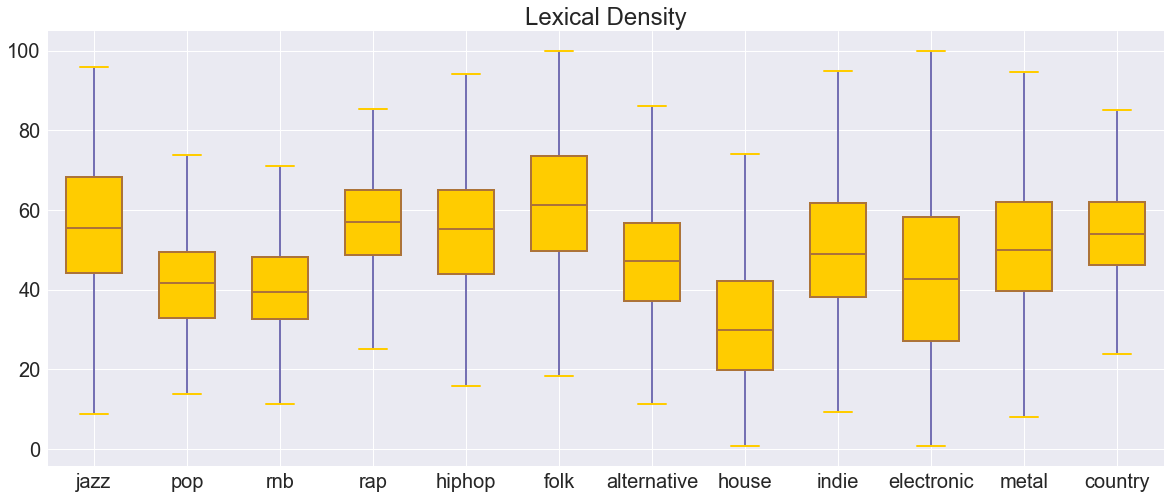

In [79]:
#Create subsets
jazz=df[df['jazz'] ==1 ].word_unique_percent
pop=df[df['pop'] ==1 ].word_unique_percent
rnb=df[df['rnb'] ==1 ].word_unique_percent
rap=df[df['rap'] ==1 ].word_unique_percent
hiphop=df[df['hiphop'] ==1 ].word_unique_percent
folk=df[df['folk'] ==1 ].word_unique_percent
alternative=df[df['alternative'] ==1 ].word_unique_percent
house=df[df['house'] ==1 ].word_unique_percent
electronic=df[df['electronic'] ==1 ].word_unique_percent
metal=df[df['metal'] ==1 ].word_unique_percent
indie=df[df['indie'] ==1 ].word_unique_percent
country=df[df['country'] ==1 ].word_unique_percent


## combine these different collections into a list    
data_plot = [jazz,pop,rnb,rap,hiphop,folk,alternative,house,indie,electronic,metal,country]

# Create a figure instance
fig = plt.figure(1, figsize=(20, 8))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data_plot)

## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_plot,widths=0.6, patch_artist=True)
#ax.set_ylim(ymax=1300)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#ac7339', linewidth=2)
    # change fill color
    box.set( facecolor = '#ffcc00' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#ffcc00', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#ac7339', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#ac7339', alpha=0.5)

## Custom x-axis labels
ax.set_xticklabels(['jazz', 'pop', 'rnb', 'rap','hiphop','folk', 'alternative','house','indie','electronic','metal','country'])
ax.set_title("Lexical Density")
## Remove top axes and right axes ticks
#ax.get_xaxis().tick_bottom()
#ax.get_yaxis().tick_left()

# Save the figure
#fig.savefig('fig.png', bbox_inches='tight')

## N-Grams

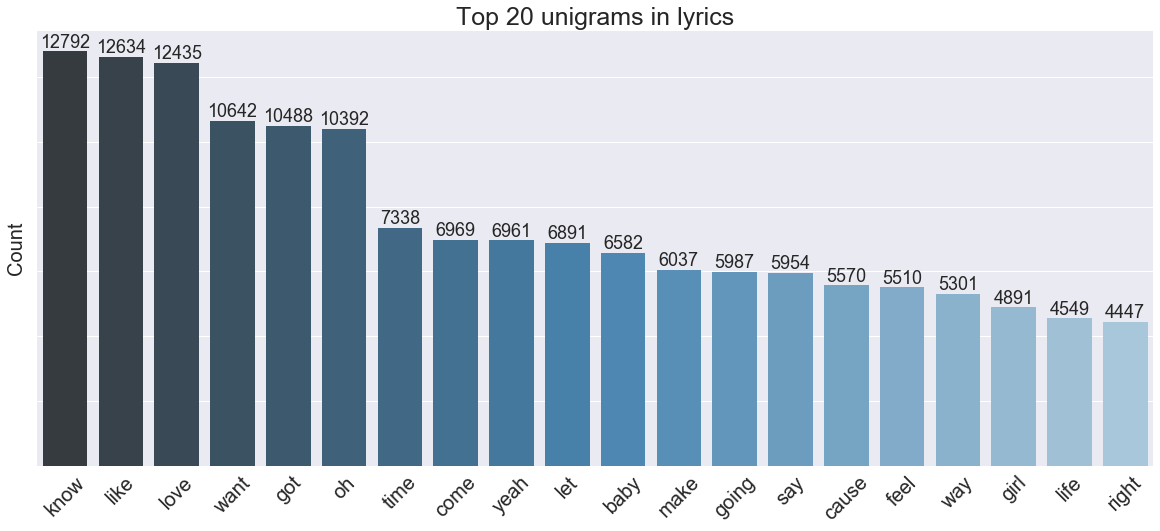

In [80]:
corpus=df['Lyrics1']
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['Lyrics1'], 20)
#for word, freq in common_words:
    #print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['Common_Words' , 'count'])
sns.set(font_scale = 2)
plt.figure(figsize=(20,8))
#ax = sns.countplot(x="Common_Words", data=df2)
ax= sns.barplot(df2['Common_Words'], df2['count'], palette='Blues_d')
plt.title("Top 20 unigrams in lyrics", fontsize=25)
plt.ylabel('Count', fontsize=20)
plt.xlabel('')
rects = ax.patches
labels = df2['count']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set(yticklabels=[])
plt.show()

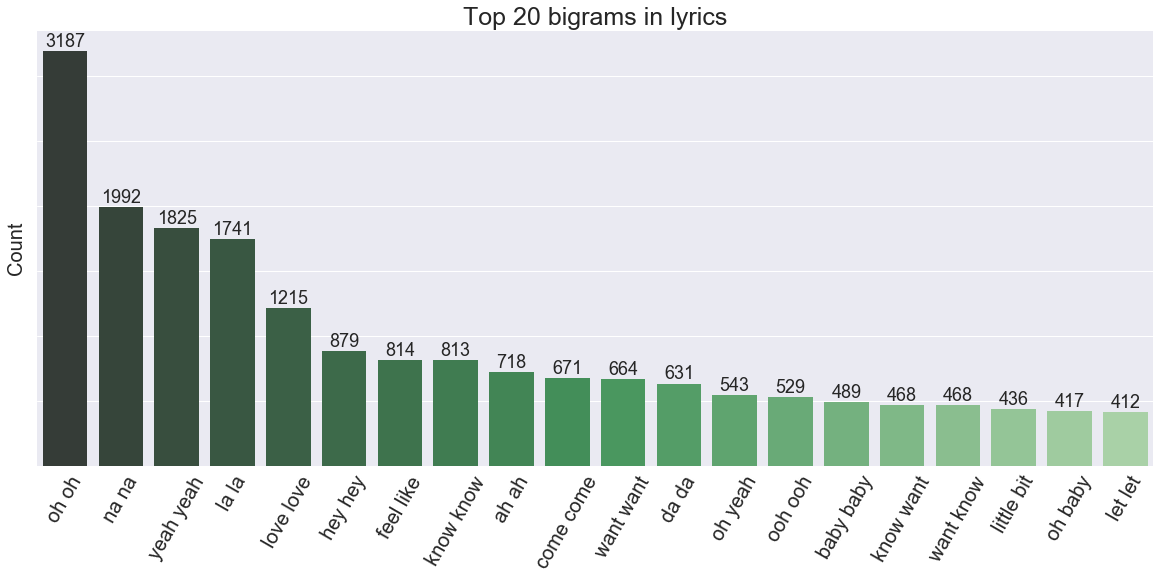

In [81]:
corpus=df['Lyrics1']
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['Lyrics1'], 20)
df3 = pd.DataFrame(common_words, columns = ['Common_Words' , 'count'])
sns.set(font_scale = 2)
plt.figure(figsize=(20,8))
#ax = sns.countplot(x="Common_Words", data=df2)

ax= sns.barplot(df3['Common_Words'], df3['count'], palette='Greens_d')
plt.title("Top 20 bigrams in lyrics", fontsize=25)
plt.ylabel('Count', fontsize=20)
plt.xlabel('')
rects = ax.patches
labels = df3['count']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.setp(ax.get_xticklabels(), rotation=60)
#sns.despine(left=True)
ax.set(yticklabels=[])
plt.show()

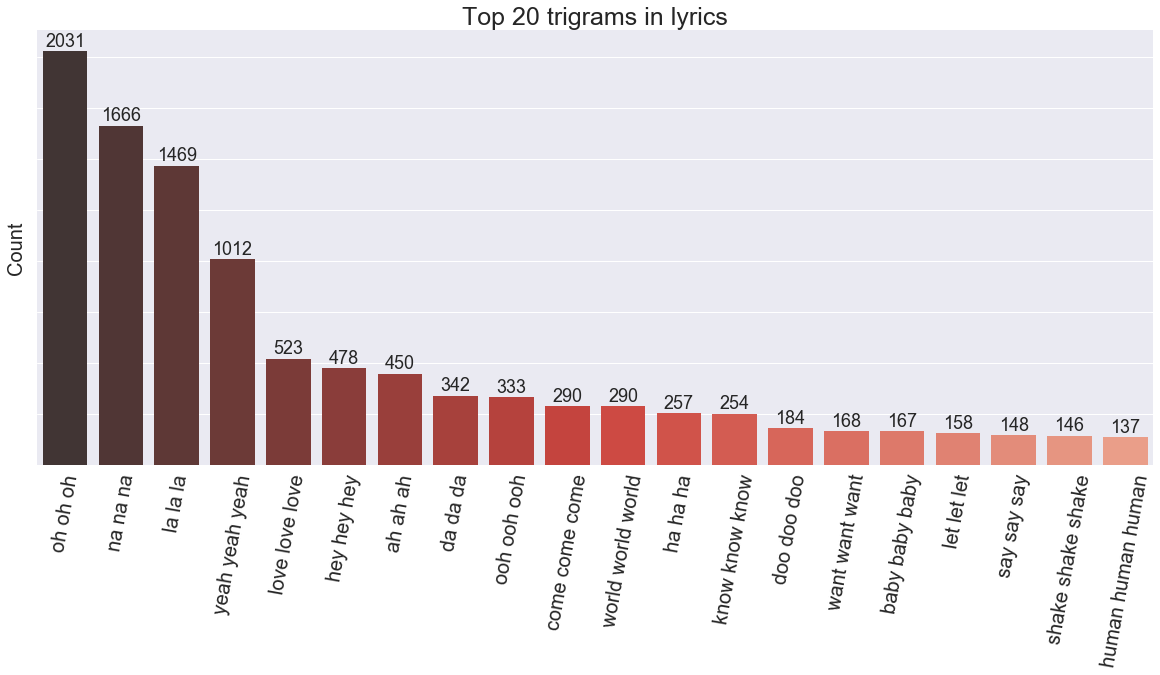

In [82]:
corpus=df['Lyrics1']
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['Lyrics1'], 20)
df4 = pd.DataFrame(common_words, columns = ['Common_Words' , 'count'])
sns.set(font_scale = 2)
plt.figure(figsize=(20,8))
#ax = sns.countplot(x="Common_Words", data=df2)
ax= sns.barplot(df4['Common_Words'], df4['count'], palette='Reds_d')
plt.title("Top 20 trigrams in lyrics", fontsize=25)
plt.ylabel('Count', fontsize=20)
plt.xlabel('')
rects = ax.patches
labels = df4['count']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.setp(ax.get_xticklabels(), rotation=80)
ax.set(yticklabels=[])
plt.show()

## Train-Test Split

In [83]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, random_state=42, test_size=0.30, shuffle=True)

print(train.shape)
print(test.shape)
train_text = train['Lyrics1']
test_text = test['Lyrics1']

(4625, 21)
(1983, 21)


### TF-IDF 

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1), norm='l2')
x_train=vec.fit_transform(train_text) # is used in order to learn vocaulary and idf, return term-document matrix
x_test=vec.transform(test_text) # is used in order to learn vocabulary and idf from training set.

In [85]:
y_train=train.iloc[:,3:15]
y_test= test.iloc[:,3:15]

In [86]:
print(type(x_train))
print(type(y_train))
print(type(x_test))
print(type(y_test))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'pandas.core.frame.DataFrame'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'pandas.core.frame.DataFrame'>


In [87]:
x_train

<4625x25154 sparse matrix of type '<class 'numpy.float64'>'
	with 343011 stored elements in Compressed Sparse Row format>

In [88]:
x_test

<1983x25154 sparse matrix of type '<class 'numpy.float64'>'
	with 143082 stored elements in Compressed Sparse Row format>

In [89]:
y_train.shape

(4625, 12)

# Multi Label Classifications

In [142]:
#import libraries
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from skmultilearn.adapt import MLkNN
from skmultilearn.adapt import BRkNNaClassifier
from sklearn.naive_bayes import GaussianNB
from skmultilearn.ensemble import RakelD
from sklearn.model_selection import GridSearchCV
import time
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
import scipy

## 1. Problem Transformation

## 1.1. Binary Relevance

### 1.1.1. Logistic Regression 

In [112]:
import time
parameters = [
    {
        'classifier': [LogisticRegression(random_state=42, class_weight='balanced')],
        'classifier__penalty': ['l1', 'l2'],# l1 lasso l2 ridge
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__max_iter': [10, 50, 100, 150]
    },
]

clf = GridSearchCV(BinaryRelevance(require_dense=[False,True]), parameters, cv=5, scoring='f1_weighted', n_jobs=-1)

start= time.time()
#train
clf.fit(x_train, y_train)
end=time.time()
print("Best F1-Score: ",round(clf.best_score_,3))
print('Tuned HyperParameter; C: {}, Maximum Iteration: {}, Penalty: {} '.format(clf.best_params_['classifier__C'],
                               clf.best_params_['classifier__max_iter'],
                               clf.best_params_['classifier__penalty']))
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Execution time: {:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds)))
#predict
y_BRLR= clf.best_estimator_.predict(x_test)

Best F1-Score:  0.409
Tuned HyperParameter; C: 1, Maximum Iteration: 10, Penalty: l2 
Execution time: 00:05:29


In [113]:
print('The best model from grid-search for BR Logistic Regression has:')
print('Hamming Loss:',round(metrics.hamming_loss(y_test,y_BRLR),3)) #the fraction of the wrong labels to the total number of labels
print('Exact-Match Ratio:',round(metrics.accuracy_score(y_test,y_BRLR),3))
print('Zero One Loss out of 1983:',round(metrics.zero_one_loss(y_test,y_BRLR, normalize=False),3))# # of instances classified not exactly correct
print('Log-Loss:',round(metrics.log_loss(y_test,y_BRLR.toarray()),3))
print('Coverage-Error:',round(metrics.coverage_error(y_test,y_BRLR.toarray()),3))
print('Ranking Loss:',round(metrics.label_ranking_loss(y_test,y_BRLR.toarray()),3))
print('Label Ranking Average Precision:',round(metrics.label_ranking_average_precision_score(y_test,y_BRLR.toarray()),3))
print('ROC AUC score:',round(metrics.roc_auc_score(y_test,y_BRLR.toarray()),3))
print('Beta-F1-score:',round(metrics.fbeta_score(y_test,y_BRLR, average='weighted', beta=100),3))
print('Micro-Recall:',round(metrics.recall_score(y_test,y_BRLR, average='micro'),3))
print('Micro-Precision:',round(metrics.precision_score(y_test,y_BRLR, average='micro'),3))
print('Micro-F1-score:',round(metrics.f1_score(y_test,y_BRLR, average='micro'),3))
print('Weighted-Recall:',round(metrics.recall_score(y_test,y_BRLR, average='weighted'),3))
print('Weighted-Precision:',round(metrics.precision_score(y_test,y_BRLR, average='weighted'),3))
print('Weighted-F1-score:',round(metrics.f1_score(y_test,y_BRLR, average='weighted'),3))

The best model from grid-search for BR Logistic Regression has:
Hamming Loss: 0.153
Exact-Match Ratio: 0.155
Zero One Loss out of 1983: 1677
Log-Loss: 17.267
Coverage-Error: 7.111
Ranking Loss: 0.519
Label Ranking Average Precision: 0.369
ROC AUC score: 0.699
Beta-F1-score: 0.531
Micro-Recall: 0.531
Micro-Precision: 0.338
Micro-F1-score: 0.413
Weighted-Recall: 0.531
Weighted-Precision: 0.353
Weighted-F1-score: 0.422


In [114]:
print('Test accuracy per genre:\n{}'.format(np.mean(y_BRLR.toarray() == y_test)))

Test accuracy per genre:
alternative    0.764736
country        0.843325
electronic     0.810579
folk           0.837280
hiphop         0.892191
house          0.905290
indie          0.799496
jazz           0.887154
metal          0.879093
pop            0.760202
rap            0.940554
rnb            0.839295
dtype: float64


In [115]:
from sklearn.metrics import classification_report
for i in range(y_test.shape[1]):
    print("Confusion Matrix:{}".format(y_test.columns.values[i]))
    print(metrics.confusion_matrix(y_test.values[:,i], y_BRLR.toarray()[:,i]))
    print("\nClassification report of {}:".format(y_test.columns.values[i]))
    print(classification_report(y_test.values[:,i], y_BRLR.toarray()[:,i]))
    print('')

Confusion Matrix:alternative
[[1420  312]
 [ 155   98]]

Classification report of alternative:
             precision    recall  f1-score   support

          0       0.90      0.82      0.86      1732
          1       0.24      0.39      0.30       253

avg / total       0.82      0.76      0.79      1985


Confusion Matrix:country
[[1514  216]
 [  95  160]]

Classification report of country:
             precision    recall  f1-score   support

          0       0.94      0.88      0.91      1730
          1       0.43      0.63      0.51       255

avg / total       0.87      0.84      0.86      1985


Confusion Matrix:electronic
[[1550  258]
 [ 118   59]]

Classification report of electronic:
             precision    recall  f1-score   support

          0       0.93      0.86      0.89      1808
          1       0.19      0.33      0.24       177

avg / total       0.86      0.81      0.83      1985


Confusion Matrix:folk
[[1585  232]
 [  91   77]]

Classification report of fo

### 1.1.2. LinearSVC

In [116]:
parameters = [
    {
        'classifier': [LinearSVC(random_state=42, class_weight='balanced')],
        'classifier__penalty': ['l2'],
        'classifier__C': [1, 10,100],
        'classifier__dual':[False,True],
         'classifier__max_iter': [10, 50, 100, 150],
    },
]

clf = GridSearchCV(BinaryRelevance(require_dense=[False,True]), parameters, cv=5, scoring='f1_weighted', n_jobs=-1)

start= time.time()
#train
clf.fit(x_train, y_train)
end=time.time()
print("Best F1-Score: ",round(clf.best_score_,3))
print('Tuned HyperParameters; C: {}, Maximum Iteration: {}, Dual: {}'.format(clf.best_params_['classifier__C'],clf.best_params_['classifier__max_iter'],
                               clf.best_params_['classifier__dual']))
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Execution time: {:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds)))
#predict
y_BRLSVC= clf.best_estimator_.predict(x_test)

Best F1-Score:  0.368
Tuned HyperParameters; C: 1, Maximum Iteration: 10, Dual: True
Execution time: 00:03:11


In [117]:
#evaluation measures
print('The best model from grid-search for BR Linear SVC has:')
print('Hamming Loss:',round(metrics.hamming_loss(y_test,y_BRLSVC),3)) #the fraction of the wrong labels to the total number of labels
print('Exact-Match Ratio:',round(metrics.accuracy_score(y_test,y_BRLSVC),3))
print('Zero One Loss out of 1983:',round(metrics.zero_one_loss(y_test,y_BRLSVC, normalize=False),3))# # of instances classified not exactly correct
print('Log-Loss:',round(metrics.log_loss(y_test,y_BRLSVC.toarray()),3))
print('Coverage-Error:',round(metrics.coverage_error(y_test,y_BRLSVC.toarray()),3))
print('Ranking Loss:',round(metrics.label_ranking_loss(y_test,y_BRLSVC.toarray()),3))
print('Label Ranking Average Precision:',round(metrics.label_ranking_average_precision_score(y_test,y_BRLSVC.toarray()),3))
print('ROC AUC score:',round(metrics.roc_auc_score(y_test,y_BRLSVC.toarray()),3))
print('Beta-F1-score:',round(metrics.fbeta_score(y_test,y_BRLSVC, average='weighted', beta=100),3))
print('Micro-Recall:',round(metrics.recall_score(y_test,y_BRLSVC, average='micro'),3))
print('Micro-Precision:',round(metrics.precision_score(y_test,y_BRLSVC, average='micro'),3))
print('Micro-F1-score:',round(metrics.f1_score(y_test,y_BRLSVC, average='micro'),3))
print('Weighted-Recall:',round(metrics.recall_score(y_test,y_BRLSVC, average='weighted'),3))
print('Weighted-Precision:',round(metrics.precision_score(y_test,y_BRLSVC, average='weighted'),3))
print('Weighted-F1-score:',round(metrics.f1_score(y_test,y_BRLSVC, average='weighted'),3))

The best model from grid-search for BR Linear SVC has:
Hamming Loss: 0.128
Exact-Match Ratio: 0.184
Zero One Loss out of 1983: 1619
Log-Loss: 18.549
Coverage-Error: 8.265
Ranking Loss: 0.624
Label Ranking Average Precision: 0.355
ROC AUC score: 0.653
Beta-F1-score: 0.393
Micro-Recall: 0.393
Micro-Precision: 0.375
Micro-F1-score: 0.384
Weighted-Recall: 0.393
Weighted-Precision: 0.379
Weighted-F1-score: 0.384


In [118]:
print('Test accuracy per genre: \n{}'.format(np.mean(y_BRLSVC.toarray() == y_test)))

Test accuracy per genre: 
alternative    0.810076
country        0.866499
electronic     0.851889
folk           0.881612
hiphop         0.905290
house          0.936524
indie          0.831234
jazz           0.913854
metal          0.896725
pop            0.775315
rap            0.942569
rnb            0.850378
dtype: float64


In [119]:
for i in range(y_test.shape[1]):
    print("Confusion Matrix:{}".format(y_test.columns.values[i]))
    print(metrics.confusion_matrix(y_test.values[:,i], y_BRLSVC.toarray()[:,i]))
    print("\nClassification report of {}:".format(y_test.columns.values[i]))
    print(classification_report(y_test.values[:,i],y_BRLSVC.toarray()[:,i]))
    print('')

Confusion Matrix:alternative
[[1559  173]
 [ 204   49]]

Classification report of alternative:
             precision    recall  f1-score   support

          0       0.88      0.90      0.89      1732
          1       0.22      0.19      0.21       253

avg / total       0.80      0.81      0.80      1985


Confusion Matrix:country
[[1585  145]
 [ 120  135]]

Classification report of country:
             precision    recall  f1-score   support

          0       0.93      0.92      0.92      1730
          1       0.48      0.53      0.50       255

avg / total       0.87      0.87      0.87      1985


Confusion Matrix:electronic
[[1663  145]
 [ 149   28]]

Classification report of electronic:
             precision    recall  f1-score   support

          0       0.92      0.92      0.92      1808
          1       0.16      0.16      0.16       177

avg / total       0.85      0.85      0.85      1985


Confusion Matrix:folk
[[1697  120]
 [ 115   53]]

Classification report of fo

### 1.1.3. Random Forest

In [120]:
parameters = [
    {
        'classifier': [RandomForestClassifier(random_state=42, class_weight='balanced')],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__n_estimators': [10, 50, 100, 150], 
        'classifier__max_depth': [5,3, None],
     },
]


clf = GridSearchCV(BinaryRelevance(require_dense=[False,True]), parameters, cv=5, scoring='f1_weighted', n_jobs=-1)

start= time.time()
#train
clf.fit(x_train, y_train)
end=time.time()
print("Best F1-Score: ",round(clf.best_score_,3))
print('Tuned HyperParameters; Criterion: {}, N Estimators: {}, Max Dept: {}'.format(clf.best_params_['classifier__criterion'],
                               clf.best_params_['classifier__n_estimators'], clf.best_params_['classifier__max_depth']))
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Execution time: {:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds)))
#predict
y_BRRF= clf.best_estimator_.predict(x_test)

Best F1-Score:  0.438
Tuned HyperParameters; Criterion: gini, N Estimators: 150, Max Dept: 5
Execution time: 00:18:10


In [121]:
#evaluation measures
print('The best model from grid-search for BR Random Forest has:')
print('Hamming Loss:',round(metrics.hamming_loss(y_test,y_BRRF),3)) #the fraction of the wrong labels to the total number of labels
print('Exact-Match Ratio:',round(metrics.accuracy_score(y_test,y_BRRF),3))
print('Zero One Loss out of 1983:',round(metrics.zero_one_loss(y_test,y_BRRF, normalize=False),3))# # of instances classified not exactly correct
print('Log-Loss:',round(metrics.log_loss(y_test,y_BRRF.toarray()),3))
print('Coverage-Error:',round(metrics.coverage_error(y_test,y_BRRF.toarray()),3))
print('Ranking Loss:',round(metrics.label_ranking_loss(y_test,y_BRRF.toarray()),3))
print('Label Ranking Average Precision:',round(metrics.label_ranking_average_precision_score(y_test,y_BRRF.toarray()),3))
print('ROC AUC score:',round(metrics.roc_auc_score(y_test,y_BRRF.toarray()),3))
print('Beta-F1-score:',round(metrics.fbeta_score(y_test,y_BRRF, average='weighted', beta=100),3))
print('Micro-Recall:',round(metrics.recall_score(y_test,y_BRRF, average='micro'),3))
print('Micro-Precision:',round(metrics.precision_score(y_test,y_BRRF, average='micro'),3))
print('Micro-F1-score:',round(metrics.f1_score(y_test,y_BRRF, average='micro'),3))
print('Weighted-Recall:',round(metrics.recall_score(y_test,y_BRRF, average='weighted'),3))
print('Weighted-Precision:',round(metrics.precision_score(y_test,y_BRRF, average='weighted'),3))
print('Weighted-F1-score:',round(metrics.f1_score(y_test,y_BRRF, average='weighted'),3))

The best model from grid-search for BR Random Forest has:
Hamming Loss: 0.2
Exact-Match Ratio: 0.131
Zero One Loss out of 1983: 1724
Log-Loss: 13.069
Coverage-Error: 6.753
Ranking Loss: 0.491
Label Ranking Average Precision: 0.345
ROC AUC score: 0.727
Beta-F1-score: 0.632
Micro-Recall: 0.632
Micro-Precision: 0.283
Micro-F1-score: 0.391
Weighted-Recall: 0.632
Weighted-Precision: 0.348
Weighted-F1-score: 0.431


In [122]:
print('Test accuracy is per genre:\n{}'.format(np.mean(y_BRRF.toarray() == y_test)))

Test accuracy is per genre:
alternative    0.648363
country        0.859446
electronic     0.728463
folk           0.850882
hiphop         0.923426
house          0.799496
indie          0.658438
jazz           0.790428
metal          0.784887
pop            0.707305
rap            0.964232
rnb            0.885139
dtype: float64


In [123]:
for i in range(y_test.shape[1]):
    print("Confusion Matrix:{}".format(y_test.columns.values[i]))
    print(metrics.confusion_matrix(y_test.values[:,i], y_BRRF.toarray()[:,i]))
    print("\nClassification report of {}:".format(y_test.columns.values[i]))
    print(classification_report(y_test.values[:,i], y_BRRF.toarray()[:,i]))
    print('')

Confusion Matrix:alternative
[[1137  595]
 [ 103  150]]

Classification report of alternative:
             precision    recall  f1-score   support

          0       0.92      0.66      0.77      1732
          1       0.20      0.59      0.30       253

avg / total       0.83      0.65      0.71      1985


Confusion Matrix:country
[[1574  156]
 [ 123  132]]

Classification report of country:
             precision    recall  f1-score   support

          0       0.93      0.91      0.92      1730
          1       0.46      0.52      0.49       255

avg / total       0.87      0.86      0.86      1985


Confusion Matrix:electronic
[[1340  468]
 [  71  106]]

Classification report of electronic:
             precision    recall  f1-score   support

          0       0.95      0.74      0.83      1808
          1       0.18      0.60      0.28       177

avg / total       0.88      0.73      0.78      1985


Confusion Matrix:folk
[[1612  205]
 [  91   77]]

Classification report of fo

### 1.1.4. Gradient Boosting

In [143]:
parameters = [
    {
        'classifier': [GradientBoostingClassifier(random_state=42)],
        'classifier__n_estimators': [50,70,100], #number of tree , higher better but complex
        'classifier__max_depth': [3,5], #how deep trees
        'classifier__learning_rate': [0.01, 0.1, 0.5], #high learning rate results in overfitting 
    },
]

clf_BRGB = GridSearchCV(BinaryRelevance(require_dense=[False,True]), parameters, cv=5, scoring='f1_weighted')

start= time.time()
#train
clf_BRGB.fit(x_train, y_train)
end=time.time()
print("Best F1-Score: ",round(clf_BRGB.best_score_,3))
print('Tuned HyperParameters; N Estimators: {}, Tree Depth: {}, Learning Rate: {},'.format(clf_BRGB.best_params_['classifier__n_estimators'],
                                                                                    clf_BRGB.best_params_['classifier__max_depth'],
                                                                                    clf_BRGB.best_params_['classifier__learning_rate']))
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Execution time: {:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds)))
#predict
y_BRGB= clf_BRGB.best_estimator_.predict(x_test)

C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\c

C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\c

Best F1-Score:  0.26
Tuned HyperParameters; N Estimators: 100, Tree Depth: 5, Learning Rate: 0.5,
Execution time: 04:40:17


In [144]:
#evaluation measures
print('The best model from grid-search for BR Gradient Boosting has:')
print('Hamming Loss:',round(metrics.hamming_loss(y_test,y_BRGB),3)) #the fraction of the wrong labels to the total number of labels
print('Exact-Match Ratio:',round(metrics.accuracy_score(y_test,y_BRGB),3))
print('Zero One Loss out of 1983:',round(metrics.zero_one_loss(y_test,y_BRGB, normalize=False),3))# # of instances classified not exactly correct
print('Log-Loss:',round(metrics.log_loss(y_test,y_BRGB.toarray()),3))
print('Coverage-Error:',round(metrics.coverage_error(y_test,y_BRGB.toarray()),3))
print('Ranking Loss:',round(metrics.label_ranking_loss(y_test,y_BRGB.toarray()),3))
print('Label Ranking Average Precision:',round(metrics.label_ranking_average_precision_score(y_test,y_BRGB.toarray()),3))
print('ROC AUC score:',round(metrics.roc_auc_score(y_test,y_BRGB.toarray()),3))
print('Beta-F1-score:',round(metrics.fbeta_score(y_test,y_BRGB, average='weighted', beta=100),3))
print('Micro-Recall:',round(metrics.recall_score(y_test,y_BRGB, average='micro'),3))
print('Micro-Precision:',round(metrics.precision_score(y_test,y_BRGB, average='micro'),3))
print('Micro-F1-score:',round(metrics.f1_score(y_test,y_BRGB, average='micro'),3))
print('Weighted-Recall:',round(metrics.recall_score(y_test,y_BRGB, average='weighted'),3))
print('Weighted-Precision:',round(metrics.precision_score(y_test,y_BRGB, average='weighted'),3))
print('Weighted-F1-score:',round(metrics.f1_score(y_test,y_BRGB, average='weighted'),3))

The best model from grid-search for BR Gradient Boosting has:
Hamming Loss: 0.127
Exact-Match Ratio: 0.109
Zero One Loss out of 1983: 1767
Log-Loss: 16.538
Coverage-Error: 10.05
Ranking Loss: 0.796
Label Ranking Average Precision: 0.245
ROC AUC score: 0.584
Beta-F1-score: 0.225
Micro-Recall: 0.225
Micro-Precision: 0.32
Micro-F1-score: 0.264
Weighted-Recall: 0.225
Weighted-Precision: 0.317
Weighted-F1-score: 0.262


In [145]:
print('Test accuracy per genre: \n{}'.format(np.mean(y_BRGB.toarray() == y_test)))

Test accuracy per genre: 
alternative    0.811901
country        0.840645
electronic     0.872920
folk           0.867877
hiphop         0.908220
house          0.940494
indie          0.828038
jazz           0.892083
metal          0.879980
pop            0.814423
rap            0.943520
rnb            0.870903
dtype: float64


In [146]:
for i in range(y_test.shape[1]):
    print("Confusion Matrix:{}".format(y_test.columns.values[i]))
    print(metrics.confusion_matrix(y_test.values[:,i], y_BRGB.toarray()[:,i]))
    print("\nClassification report of {}:".format(y_test.columns.values[i]))
    print(classification_report(y_test.values[:,i], y_BRGB.toarray()[:,i]))
    print('')

Confusion Matrix:alternative
[[1589  152]
 [ 221   21]]

Classification report of alternative:
             precision    recall  f1-score   support

          0       0.88      0.91      0.89      1741
          1       0.12      0.09      0.10       242

avg / total       0.79      0.81      0.80      1983


Confusion Matrix:country
[[1605  140]
 [ 176   62]]

Classification report of country:
             precision    recall  f1-score   support

          0       0.90      0.92      0.91      1745
          1       0.31      0.26      0.28       238

avg / total       0.83      0.84      0.83      1983


Confusion Matrix:electronic
[[1716  105]
 [ 147   15]]

Classification report of electronic:
             precision    recall  f1-score   support

          0       0.92      0.94      0.93      1821
          1       0.12      0.09      0.11       162

avg / total       0.86      0.87      0.86      1983


Confusion Matrix:folk
[[1701  103]
 [ 159   20]]

Classification report of fo

### 1.1.5. Gaussian Naive Bayes

In [145]:
#there is not hyper-parameter to tune
clf_NB= BinaryRelevance(GaussianNB())
start= time.time()
#train
clf_NB.fit(x_train, y_train)
end=time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Execution time: {:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds)))
#predict
y_BRNB=clf_NB.predict(x_test)

Execution time: 00:00:39


In [146]:
#evaluation measures
print('BR Gaussian Naive Bayes has:')
print('Hamming Loss:',round(metrics.hamming_loss(y_test,y_BRNB),3)) #the fraction of the wrong labels to the total number of labels
print('Exact-Match Ratio:',round(metrics.accuracy_score(y_test,y_BRNB),3))
print('Zero One Loss out of 1983:',round(metrics.zero_one_loss(y_test,y_BRNB, normalize=False),3))# # of instances classified not exactly correct
print('Log-Loss:',round(metrics.log_loss(y_test,y_BRNB.toarray()),3))
print('Coverage-Error:',round(metrics.coverage_error(y_test,y_BRNB.toarray()),3))
print('Ranking Loss:',round(metrics.label_ranking_loss(y_test,y_BRNB.toarray()),3))
print('Label Ranking Average Precision:',round(metrics.label_ranking_average_precision_score(y_test,y_BRNB.toarray()),3))
print('ROC AUC score:',round(metrics.roc_auc_score(y_test,y_BRNB.toarray()),3))
print('Beta-F1-score:',round(metrics.fbeta_score(y_test,y_BRNB, average='weighted', beta=100),3))
print('Micro-Recall:',round(metrics.recall_score(y_test,y_BRNB, average='micro'),3))
print('Micro-Precision:',round(metrics.precision_score(y_test,y_BRNB, average='micro'),3))
print('Micro-F1-score:',round(metrics.f1_score(y_test,y_BRNB, average='micro'),3))
print('Weighted-Recall:',round(metrics.recall_score(y_test,y_BRNB, average='weighted'),3))
print('Weighted-Precision:',round(metrics.precision_score(y_test,y_BRNB, average='weighted'),3))
print('Weighted-F1-score:',round(metrics.f1_score(y_test,y_BRNB, average='weighted'),3))

BR Gaussian Naive Bayes has:
Hamming Loss: 0.179
Exact-Match Ratio: 0.07
Zero One Loss out of 1983: 1846
Log-Loss: 16.843
Coverage-Error: 10.643
Ranking Loss: 0.854
Label Ranking Average Precision: 0.196
ROC AUC score: 0.545
Beta-F1-score: 0.198
Micro-Recall: 0.198
Micro-Precision: 0.171
Micro-F1-score: 0.184
Weighted-Recall: 0.198
Weighted-Precision: 0.186
Weighted-F1-score: 0.179


In [147]:
print('Test accuracy is per genre:\n{}'.format(np.mean(y_BRNB.toarray() == y_test)))

Test accuracy is per genre:
alternative    0.797985
country        0.827708
electronic     0.868514
folk           0.842317
hiphop         0.696222
house          0.957179
indie          0.800504
jazz           0.908312
metal          0.816121
pop            0.805038
rap            0.719395
rnb            0.813602
dtype: float64


In [148]:
for i in range(y_test.shape[1]):
    print("Confusion Matrix:{}".format(y_test.columns.values[i]))
    print(metrics.confusion_matrix(y_test.values[:,i], y_BRNB.toarray()[:,i]))
    print("\nClassification report of {}:".format(y_test.columns.values[i]))
    print(classification_report(y_test.values[:,i], y_BRNB.toarray()[:,i]))
    print('')

Confusion Matrix:alternative
[[1550  182]
 [ 219   34]]

Classification report of alternative:
             precision    recall  f1-score   support

          0       0.88      0.89      0.89      1732
          1       0.16      0.13      0.14       253

avg / total       0.78      0.80      0.79      1985


Confusion Matrix:country
[[1592  138]
 [ 204   51]]

Classification report of country:
             precision    recall  f1-score   support

          0       0.89      0.92      0.90      1730
          1       0.27      0.20      0.23       255

avg / total       0.81      0.83      0.82      1985


Confusion Matrix:electronic
[[1704  104]
 [ 157   20]]

Classification report of electronic:
             precision    recall  f1-score   support

          0       0.92      0.94      0.93      1808
          1       0.16      0.11      0.13       177

avg / total       0.85      0.87      0.86      1985


Confusion Matrix:folk
[[1645  172]
 [ 141   27]]

Classification report of fo

## 1.2. Classifier Chains

### 1.2.1. Logistic Regression 

In [149]:
#hyperparameters
parameters = [
    {
        'classifier': [LogisticRegression(random_state=42, class_weight='balanced')],
        'classifier__penalty': ['l1', 'l2'],# l1 lasso l2 ridge
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__max_iter': [10, 50, 100, 150]
    },
]

clf = GridSearchCV(ClassifierChain(require_dense=[False,True]), parameters, cv=5, scoring='f1_weighted', n_jobs=-1)

start= time.time()
#train
clf.fit(x_train, y_train)
end=time.time()
print("Best F1-Score: ",round(clf.best_score_,3))
print('Tuned HyperParameter; C: {}, Maximum Iteration: {}, Penalty: {} '.format(clf.best_params_['classifier__C'],
                               clf.best_params_['classifier__max_iter'],
                               clf.best_params_['classifier__penalty']))
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Execution time: {:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds)))
#predict
y_CCLR= clf.best_estimator_.predict(x_test)

Best F1-Score:  0.355
Tuned HyperParameter; C: 10, Maximum Iteration: 10, Penalty: l2 
Execution time: 00:03:15


In [150]:
print('The best model from grid-search for CC Logistic Regression has:')
print('Hamming Loss:',round(metrics.hamming_loss(y_test,y_CCLR),3)) #the fraction of the wrong labels to the total number of labels
print('Exact-Match Ratio:',round(metrics.accuracy_score(y_test,y_CCLR),3))
print('Zero One Loss out of 1983:',round(metrics.zero_one_loss(y_test,y_CCLR, normalize=False),3))# # of instances classified not exactly correct
print('Log-Loss:',round(metrics.log_loss(y_test,y_CCLR.toarray()),3))
print('Coverage-Error:',round(metrics.coverage_error(y_test,y_CCLR.toarray()),3))
print('Ranking Loss:',round(metrics.label_ranking_loss(y_test,y_CCLR.toarray()),3))
print('Label Ranking Average Precision:',round(metrics.label_ranking_average_precision_score(y_test,y_CCLR.toarray()),3))
print('ROC AUC score:',round(metrics.roc_auc_score(y_test,y_CCLR.toarray()),3))
print('Beta-F1-score:',round(metrics.fbeta_score(y_test,y_CCLR, average='weighted', beta=100),3))
print('Micro-Recall:',round(metrics.recall_score(y_test,y_CCLR, average='micro'),3))
print('Micro-Precision:',round(metrics.precision_score(y_test,y_CCLR, average='micro'),3))
print('Micro-F1-score:',round(metrics.f1_score(y_test,y_CCLR, average='micro'),3))
print('Weighted-Recall:',round(metrics.recall_score(y_test,y_CCLR, average='weighted'),3))
print('Weighted-Precision:',round(metrics.precision_score(y_test,y_CCLR, average='weighted'),3))
print('Weighted-F1-score:',round(metrics.f1_score(y_test,y_CCLR, average='weighted'),3))
print('Macro-F1-score:',round(metrics.f1_score(y_test,y_CCLR, average='macro'),3))
print('Macro-Recall:',round(metrics.recall_score(y_test,y_CCLR, average='macro'),3))
print('Macro-Precision:',round(metrics.precision_score(y_test,y_CCLR, average='macro'),3))

The best model from grid-search for CC Logistic Regression has:
Hamming Loss: 0.133
Exact-Match Ratio: 0.253
Zero One Loss out of 1983: 1483
Log-Loss: 26.06
Coverage-Error: 8.176
Ranking Loss: 0.62
Label Ranking Average Precision: 0.393
ROC AUC score: 0.65
Beta-F1-score: 0.387
Micro-Recall: 0.387
Micro-Precision: 0.357
Micro-F1-score: 0.372
Weighted-Recall: 0.387
Weighted-Precision: 0.36
Weighted-F1-score: 0.372
Macro-F1-score: 0.361
Macro-Recall: 0.379
Macro-Precision: 0.348


In [151]:
print('Test accuracy is:\n{}'.format(np.mean(y_CCLR.toarray() == y_test)))

Test accuracy is:
alternative    0.792443
country        0.867506
electronic     0.847859
folk           0.873552
hiphop         0.904786
house          0.925945
indie          0.815617
jazz           0.898237
metal          0.861461
pop            0.813098
rap            0.936524
rnb            0.867003
dtype: float64


In [152]:
for i in range(y_test.shape[1]):
    print("Confusion Matrix:{}".format(y_test.columns.values[i]))
    print(metrics.confusion_matrix(y_test.values[:,i],y_CCLR.toarray()[:,i]))
    print("\nClassification report of {}:".format(y_test.columns.values[i]))
    print(classification_report(y_test.values[:,i], y_CCLR.toarray()[:,i]))
    print('')

Confusion Matrix:alternative
[[1510  222]
 [ 190   63]]

Classification report of alternative:
             precision    recall  f1-score   support

          0       0.89      0.87      0.88      1732
          1       0.22      0.25      0.23       253

avg / total       0.80      0.79      0.80      1985


Confusion Matrix:country
[[1579  151]
 [ 112  143]]

Classification report of country:
             precision    recall  f1-score   support

          0       0.93      0.91      0.92      1730
          1       0.49      0.56      0.52       255

avg / total       0.88      0.87      0.87      1985


Confusion Matrix:electronic
[[1650  158]
 [ 144   33]]

Classification report of electronic:
             precision    recall  f1-score   support

          0       0.92      0.91      0.92      1808
          1       0.17      0.19      0.18       177

avg / total       0.85      0.85      0.85      1985


Confusion Matrix:folk
[[1681  136]
 [ 115   53]]

Classification report of fo

### 1.2.2. LinearSVC

In [148]:
parameters = [
    {
        'classifier': [LinearSVC(random_state=42, class_weight='balanced')],
        'classifier__penalty': ['l2'],
        'classifier__C': [1, 10,100],
        'classifier__dual':[False,True],
         'classifier__max_iter': [10, 50, 100, 150],
    },
]

clf = GridSearchCV(ClassifierChain(require_dense=[False,True]), parameters, cv=5, scoring='f1_weighted', n_jobs=-1)

start= time.time()
#train
clf.fit(x_train, y_train)
end=time.time()
print("Best F1-Score: ",round(clf.best_score_,3))
print('Tuned HyperParameters; C: {}, Maximum Iteration: {}, Dual: {}'.format(clf.best_params_['classifier__C'],clf.best_params_['classifier__max_iter'],
                               clf.best_params_['classifier__dual']))
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Execution time: {:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds)))
#predict
y_CCLSVC= clf.best_estimator_.predict(x_test)

Best F1-Score:  0.363
Tuned HyperParameters; C: 1, Maximum Iteration: 10, Dual: True
Execution time: 00:03:51


In [149]:
#evaluation measures
print('The best model from grid-search for CC Linear SVC has:')
print('Hamming Loss:',round(metrics.hamming_loss(y_test,y_CCLSVC),3)) #the fraction of the wrong labels to the total number of labels
print('Exact-Match Ratio:',round(metrics.accuracy_score(y_test,y_CCLSVC),3))
print('Zero One Loss out of 1983:',round(metrics.zero_one_loss(y_test,y_CCLSVC, normalize=False),3))# # of instances classified not exactly correct
print('Log-Loss:',round(metrics.log_loss(y_test,y_CCLSVC.toarray()),3))
print('Coverage-Error:',round(metrics.coverage_error(y_test,y_CCLSVC.toarray()),3))
print('Ranking Loss:',round(metrics.label_ranking_loss(y_test,y_CCLSVC.toarray()),3))
print('Label Ranking Average Precision:',round(metrics.label_ranking_average_precision_score(y_test,y_CCLSVC.toarray()),3))
print('ROC AUC score:',round(metrics.roc_auc_score(y_test,y_CCLSVC.toarray()),3))
print('Beta-F1-score:',round(metrics.fbeta_score(y_test,y_CCLSVC, average='weighted', beta=100),3))
print('Micro-Recall:',round(metrics.recall_score(y_test,y_CCLSVC, average='micro'),3))
print('Micro-Precision:',round(metrics.precision_score(y_test,y_CCLSVC, average='micro'),3))
print('Micro-F1-score:',round(metrics.f1_score(y_test,y_CCLSVC, average='micro'),3))
print('Weighted-Recall:',round(metrics.recall_score(y_test,y_CCLSVC, average='weighted'),3))
print('Weighted-Precision:',round(metrics.precision_score(y_test,y_CCLSVC, average='weighted'),3))
print('Weighted-F1-score:',round(metrics.f1_score(y_test,y_CCLSVC, average='weighted'),3))
print('Macro-F1-score:',round(metrics.f1_score(y_test,y_CCLSVC, average='macro'),3))
print('Macro-Recall:',round(metrics.recall_score(y_test,y_CCLSVC, average='macro'),3))
print('Macro-Precision:',round(metrics.precision_score(y_test,y_CCLSVC, average='macro'),3))

The best model from grid-search for CC Linear SVC has:
Hamming Loss: 0.129
Exact-Match Ratio: 0.258
Zero One Loss out of 1983: 1471
Log-Loss: 26.217
Coverage-Error: 8.28
Ranking Loss: 0.628
Label Ranking Average Precision: 0.393
ROC AUC score: 0.646
Beta-F1-score: 0.383
Micro-Recall: 0.383
Micro-Precision: 0.368
Micro-F1-score: 0.376
Weighted-Recall: 0.383
Weighted-Precision: 0.371
Weighted-F1-score: 0.374
Macro-F1-score: 0.358
Macro-Recall: 0.368
Macro-Precision: 0.354


In [150]:
print('Test accuracy is: {}'.format(np.mean(y_CCLSVC.toarray() == y_test)))

Test accuracy is: alternative    0.818457
country        0.863338
electronic     0.853253
folk           0.853253
hiphop         0.911750
house          0.938477
indie          0.822995
jazz           0.906707
metal          0.868381
pop            0.812405
rap            0.933938
rnb            0.864347
dtype: float64


In [151]:
for i in range(y_test.shape[1]):
    print("Confusion Matrix:{}".format(y_test.columns.values[i]))
    print(metrics.confusion_matrix(y_test.values[:,i], y_CCLSVC.toarray()[:,i]))
    print("\nClassification report of {}:".format(y_test.columns.values[i]))
    print(classification_report(y_test.values[:,i],y_CCLSVC.toarray()[:,i]))
    print('')

Confusion Matrix:alternative
[[1569  172]
 [ 188   54]]

Classification report of alternative:
             precision    recall  f1-score   support

          0       0.89      0.90      0.90      1741
          1       0.24      0.22      0.23       242

avg / total       0.81      0.82      0.82      1983


Confusion Matrix:country
[[1577  168]
 [ 103  135]]

Classification report of country:
             precision    recall  f1-score   support

          0       0.94      0.90      0.92      1745
          1       0.45      0.57      0.50       238

avg / total       0.88      0.86      0.87      1983


Confusion Matrix:electronic
[[1655  166]
 [ 125   37]]

Classification report of electronic:
             precision    recall  f1-score   support

          0       0.93      0.91      0.92      1821
          1       0.18      0.23      0.20       162

avg / total       0.87      0.85      0.86      1983


Confusion Matrix:folk
[[1637  167]
 [ 124   55]]

Classification report of fo

### 1.2.3. Random Forest

In [157]:
parameters = [
    {
        'classifier': [RandomForestClassifier(random_state=42, class_weight='balanced')],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__n_estimators': [10, 100, 150, 500],
        'classifier__max_depth': [5,3, None],
     },
]


clf = GridSearchCV(ClassifierChain(require_dense=[False,True]), parameters, cv=5, scoring='f1_weighted', n_jobs=-1)

start= time.time()
#train
clf.fit(x_train, y_train)
end=time.time()
print("Best F1-Score: ",round(clf.best_score_,3))
print('Tuned HyperParameters; Criterion: {}, N Estimators: {}, Max Depth: {}'.format(clf.best_params_['classifier__criterion'],
                               clf.best_params_['classifier__n_estimators'], clf.best_params_['classifier__max_depth']))
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Execution time: {:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds)))
#predict
y_CCRF= clf.best_estimator_.predict(x_test)

Best F1-Score:  0.448
Tuned HyperParameters; Criterion: gini, N Estimators: 500, Max Depth: 5
Execution time: 00:39:46


In [158]:
#evaluation measures
print('The best model from grid-search for CC Random Forest has:')
print('Hamming Loss:',round(metrics.hamming_loss(y_test,y_CCRF),3)) #the fraction of the wrong labels to the total number of labels
print('Exact-Match Ratio:',round(metrics.accuracy_score(y_test,y_CCRF),3))
print('Zero One Loss out of 1983:',round(metrics.zero_one_loss(y_test,y_CCRF, normalize=False),3))# # of instances classified not exactly correct
print('Log-Loss:',round(metrics.log_loss(y_test,y_CCRF.toarray()),3))
print('Coverage-Error:',round(metrics.coverage_error(y_test,y_CCRF.toarray()),3))
print('Ranking Loss:',round(metrics.label_ranking_loss(y_test,y_CCRF.toarray()),3))
print('Label Ranking Average Precision:',round(metrics.label_ranking_average_precision_score(y_test,y_CCRF.toarray()),3))
print('ROC AUC score:',round(metrics.roc_auc_score(y_test,y_CCRF.toarray()),3))
print('Beta-F1-score:',round(metrics.fbeta_score(y_test,y_CCRF, average='weighted', beta=100),3))
print('Micro-Recall:',round(metrics.recall_score(y_test,y_CCRF, average='micro'),3))
print('Micro-Precision:',round(metrics.precision_score(y_test,y_CCRF, average='micro'),3))
print('Micro-F1-score:',round(metrics.f1_score(y_test,y_CCRF, average='micro'),3))
print('Weighted-Recall:',round(metrics.recall_score(y_test,y_CCRF, average='weighted'),3))
print('Weighted-Precision:',round(metrics.precision_score(y_test,y_CCRF, average='weighted'),3))
print('Weighted-F1-score:',round(metrics.f1_score(y_test,y_CCRF, average='weighted'),3))
print('Macro-F1-score:',round(metrics.f1_score(y_test,y_CCRF, average='macro'),3))
print('Macro-Recall:',round(metrics.recall_score(y_test,y_CCRF, average='macro'),3))
print('Macro-Precision:',round(metrics.precision_score(y_test,y_CCRF, average='macro'),3))

The best model from grid-search for CC Random Forest has:
Hamming Loss: 0.162
Exact-Match Ratio: 0.157
Zero One Loss out of 1983: 1673
Log-Loss: 15.72
Coverage-Error: 6.872
Ranking Loss: 0.499
Label Ranking Average Precision: 0.378
ROC AUC score: 0.72
Beta-F1-score: 0.575
Micro-Recall: 0.575
Micro-Precision: 0.329
Micro-F1-score: 0.418
Weighted-Recall: 0.575
Weighted-Precision: 0.423
Weighted-F1-score: 0.454
Macro-F1-score: 0.439
Macro-Recall: 0.572
Macro-Precision: 0.409


In [159]:
print('Test accuracy is:\n{}'.format(np.mean(y_CCRF.toarray() == y_test)))

Test accuracy is:
alternative    0.649874
country        0.881612
electronic     0.740050
folk           0.902267
hiphop         0.927456
house          0.827204
indie          0.647859
jazz           0.922418
metal          0.909320
pop            0.807053
rap            0.955668
rnb            0.883123
dtype: float64


In [160]:
for i in range(y_test.shape[1]):
    print("Confusion Matrix:{}".format(y_test.columns.values[i]))
    print(metrics.confusion_matrix(y_test.values[:,i], y_CCRF.toarray()[0:,i]))
    print("\nClassification report of {}:".format(y_test.columns.values[i]))
    print(classification_report(y_test.values[:,i], y_CCRF.toarray()[0:,i]))
    print('')

Confusion Matrix:alternative
[[1133  599]
 [  96  157]]

Classification report of alternative:
             precision    recall  f1-score   support

          0       0.92      0.65      0.77      1732
          1       0.21      0.62      0.31       253

avg / total       0.83      0.65      0.71      1985


Confusion Matrix:country
[[1608  122]
 [ 113  142]]

Classification report of country:
             precision    recall  f1-score   support

          0       0.93      0.93      0.93      1730
          1       0.54      0.56      0.55       255

avg / total       0.88      0.88      0.88      1985


Confusion Matrix:electronic
[[1363  445]
 [  71  106]]

Classification report of electronic:
             precision    recall  f1-score   support

          0       0.95      0.75      0.84      1808
          1       0.19      0.60      0.29       177

avg / total       0.88      0.74      0.79      1985


Confusion Matrix:folk
[[1735   82]
 [ 112   56]]

Classification report of fo

### 1.2.4. Gradient Boosting

In [161]:
parameters = [
    {
        'classifier': [GradientBoostingClassifier(random_state=42)],
        'classifier__n_estimators': [50,70,100], #number of tree , higher better but complex
        'classifier__max_depth': [3,5],  #how deep trees
        'classifier__learning_rate': [0.01, 0.1, 0.5], #high learning rate results in overfitting 
    },
]

clf_CCGB = GridSearchCV(ClassifierChain(require_dense=[False,True]), parameters, cv=5, scoring='f1_weighted')

start= time.time()
#train
clf_CCGB.fit(x_train, y_train)
end=time.time()
print("Best F1-Score: ",round(clf_CCGB.best_score_,3))
print('Tuned HyperParameters; N Estimators: {}, Tree Depth: {}, Learning Rate: {},'.format(clf_CCGB.best_params_['classifier__n_estimators'],
                                                                                    clf_CCGB.best_params_['classifier__max_depth'],
                                                                                    clf_CCGB.best_params_['classifier__learning_rate']))
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Execution time: {:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds)))
#predict
y_CCGB= clf_CCGB.best_estimator_.predict(x_test)

C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\c

C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\c

Best F1-Score:  0.264
Tuned HyperParameters; N Estimators: 100, Tree Depth: 3, Learning Rate: 0.5,
Execution time: 04:10:30


In [162]:
#evaluation measures
print('The best model from grid-search for CC Gradient Boosting has:')
print('Hamming Loss:',round(metrics.hamming_loss(y_test,y_CCGB),3)) #the fraction of the wrong labels to the total number of labels
print('Exact-Match Ratio:',round(metrics.accuracy_score(y_test,y_CCGB),3))
print('Zero One Loss out of 1983:',round(metrics.zero_one_loss(y_test,y_CCGB, normalize=False),3))# # of instances classified not exactly correct
print('Log-Loss:',round(metrics.log_loss(y_test,y_CCGB.toarray()),3))
print('Coverage-Error:',round(metrics.coverage_error(y_test,y_CCGB.toarray()),3))
print('Ranking Loss:',round(metrics.label_ranking_loss(y_test,y_CCGB.toarray()),3))
print('Label Ranking Average Precision:',round(metrics.label_ranking_average_precision_score(y_test,y_CCGB.toarray()),3))
print('ROC AUC score:',round(metrics.roc_auc_score(y_test,y_CCGB.toarray()),3))
print('Beta-F1-score:',round(metrics.fbeta_score(y_test,y_CCGB, average='weighted', beta=100),3))
print('Micro-Recall:',round(metrics.recall_score(y_test,y_CCGB, average='micro'),3))
print('Micro-Precision:',round(metrics.precision_score(y_test,y_CCGB, average='micro'),3))
print('Micro-F1-score:',round(metrics.f1_score(y_test,y_CCGB, average='micro'),3))
print('Weighted-Recall:',round(metrics.recall_score(y_test,y_CCGB, average='weighted'),3))
print('Weighted-Precision:',round(metrics.precision_score(y_test,y_CCGB, average='weighted'),3))
print('Weighted-F1-score:',round(metrics.f1_score(y_test,y_CCGB, average='weighted'),3))
print('Macro-F1-score:',round(metrics.f1_score(y_test,y_CCGB, average='macro'),3))
print('Macro-Recall:',round(metrics.recall_score(y_test,y_CCGB, average='macro'),3))
print('Macro-Precision:',round(metrics.precision_score(y_test,y_CCGB, average='macro'),3))

The best model from grid-search for CC Gradient Boosting has:
Hamming Loss: 0.119
Exact-Match Ratio: 0.145
Zero One Loss out of 1983: 1697
Log-Loss: 17.332
Coverage-Error: 9.698
Ranking Loss: 0.766
Label Ranking Average Precision: 0.279
ROC AUC score: 0.599
Beta-F1-score: 0.249
Micro-Recall: 0.249
Micro-Precision: 0.371
Micro-F1-score: 0.298
Weighted-Recall: 0.249
Weighted-Precision: 0.36
Weighted-F1-score: 0.29
Macro-F1-score: 0.283
Macro-Recall: 0.246
Macro-Precision: 0.345


In [163]:
print('Test accuracy is per genre:\n{}'.format(np.mean(y_CCGB.toarray() == y_test)))

Test accuracy is per genre:
alternative    0.833753
country        0.857431
electronic     0.874055
folk           0.879597
hiphop         0.905290
house          0.932997
indie          0.837783
jazz           0.901763
metal          0.895214
pop            0.832242
rap            0.947607
rnb            0.873048
dtype: float64


In [164]:
for i in range(y_test.shape[1]):
    print("Confusion Matrix:{}".format(y_test.columns.values[i]))
    print(metrics.confusion_matrix(y_test.values[:,i], y_CCGB.toarray()[:,i]))
    print("\nClassification report of {}:".format(y_test.columns.values[i]))
    print(classification_report(y_test.values[:,i], y_CCGB.toarray()[:,i]))
    print('')

Confusion Matrix:alternative
[[1622  110]
 [ 220   33]]

Classification report of alternative:
             precision    recall  f1-score   support

          0       0.88      0.94      0.91      1732
          1       0.23      0.13      0.17       253

avg / total       0.80      0.83      0.81      1985


Confusion Matrix:country
[[1636   94]
 [ 189   66]]

Classification report of country:
             precision    recall  f1-score   support

          0       0.90      0.95      0.92      1730
          1       0.41      0.26      0.32       255

avg / total       0.83      0.86      0.84      1985


Confusion Matrix:electronic
[[1718   90]
 [ 160   17]]

Classification report of electronic:
             precision    recall  f1-score   support

          0       0.91      0.95      0.93      1808
          1       0.16      0.10      0.12       177

avg / total       0.85      0.87      0.86      1985


Confusion Matrix:folk
[[1720   97]
 [ 142   26]]

Classification report of fo

### 1.2.5. Gaussian Naive Bayes

In [165]:
#there is not hyper-parameter to tune
clf_CCNB= ClassifierChain(GaussianNB())
start= time.time()
#train
clf_CCNB.fit(x_train, y_train)
end=time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Execution time: {:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds)))
#predict
y_CCNB=clf_CCNB.predict(x_test)

Execution time: 00:01:01


In [166]:
#evaluation measures
print('CC Gaussian Naive Bayes has:')
print('Hamming Loss:',round(metrics.hamming_loss(y_test,y_CCNB),3)) #the fraction of the wrong labels to the total number of labels
print('Exact-Match Ratio:',round(metrics.accuracy_score(y_test,y_CCNB),3))
print('Zero One Loss out of 1983:',round(metrics.zero_one_loss(y_test,y_CCNB, normalize=False),3))# # of instances classified not exactly correct
print('Log-Loss:',round(metrics.log_loss(y_test,y_CCNB.toarray()),3))
print('Coverage-Error:',round(metrics.coverage_error(y_test,y_CCNB.toarray()),3))
print('Ranking Loss:',round(metrics.label_ranking_loss(y_test,y_CCNB.toarray()),3))
print('Label Ranking Average Precision:',round(metrics.label_ranking_average_precision_score(y_test,y_CCNB.toarray()),3))
print('ROC AUC score:',round(metrics.roc_auc_score(y_test,y_CCNB.toarray()),3))
print('Beta-F1-score:',round(metrics.fbeta_score(y_test,y_CCNB, average='weighted', beta=100),3))
print('Micro-Recall:',round(metrics.recall_score(y_test,y_CCNB, average='micro'),3))
print('Micro-Precision:',round(metrics.precision_score(y_test,y_CCNB, average='micro'),3))
print('Micro-F1-score:',round(metrics.f1_score(y_test,y_CCNB, average='micro'),3))
print('Weighted-Recall:',round(metrics.recall_score(y_test,y_CCNB, average='weighted'),3))
print('Weighted-Precision:',round(metrics.precision_score(y_test,y_CCNB, average='weighted'),3))
print('Weighted-F1-score:',round(metrics.f1_score(y_test,y_CCNB, average='weighted'),3))
print('Macro-F1-score:',round(metrics.f1_score(y_test,y_CCNB, average='macro'),3))
print('Macro-Recall:',round(metrics.recall_score(y_test,y_CCNB, average='macro'),3))
print('Macro-Precision:',round(metrics.precision_score(y_test,y_CCNB, average='macro'),3))

CC Gaussian Naive Bayes has:
Hamming Loss: 0.154
Exact-Match Ratio: 0.074
Zero One Loss out of 1983: 1838
Log-Loss: 17.574
Coverage-Error: 10.622
Ranking Loss: 0.85
Label Ranking Average Precision: 0.202
ROC AUC score: 0.55
Beta-F1-score: 0.177
Micro-Recall: 0.177
Micro-Precision: 0.202
Micro-F1-score: 0.188
Weighted-Recall: 0.177
Weighted-Precision: 0.257
Weighted-F1-score: 0.182
Macro-F1-score: 0.184
Macro-Recall: 0.178
Macro-Precision: 0.267


In [167]:
print('Test accuracy is per genre:\n{}'.format(np.mean(y_CCNB.toarray() == y_test)))

Test accuracy is per genre:
alternative    0.797985
country        0.861461
electronic     0.876071
folk           0.868010
hiphop         0.715869
house          0.958186
indie          0.812594
jazz           0.931990
metal          0.878589
pop            0.805038
rap            0.785894
rnb            0.855416
dtype: float64


In [168]:
for i in range(y_test.shape[1]):
    print("Confusion Matrix:{}".format(y_test.columns.values[i]))
    print(metrics.confusion_matrix(y_test.values[:,i], y_CCNB.toarray()[:,i]))
    print("\nClassification report of {}:".format(y_test.columns.values[i]))
    print(classification_report(y_test.values[:,i], y_CCNB.toarray()[:,i]))
    print('')

Confusion Matrix:alternative
[[1550  182]
 [ 219   34]]

Classification report of alternative:
             precision    recall  f1-score   support

          0       0.88      0.89      0.89      1732
          1       0.16      0.13      0.14       253

avg / total       0.78      0.80      0.79      1985


Confusion Matrix:country
[[1670   60]
 [ 215   40]]

Classification report of country:
             precision    recall  f1-score   support

          0       0.89      0.97      0.92      1730
          1       0.40      0.16      0.23       255

avg / total       0.82      0.86      0.83      1985


Confusion Matrix:electronic
[[1719   89]
 [ 157   20]]

Classification report of electronic:
             precision    recall  f1-score   support

          0       0.92      0.95      0.93      1808
          1       0.18      0.11      0.14       177

avg / total       0.85      0.88      0.86      1985


Confusion Matrix:folk
[[1702  115]
 [ 147   21]]

Classification report of fo

## 1.3. Label Powerset

### 1.3.1. Logistic Regression 

In [169]:
parameters = [
    {
        'classifier': [LogisticRegression(random_state=42, class_weight='balanced')],
        'classifier__penalty': ['l1', 'l2'],# l1 lasso l2 ridge
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__max_iter': [10, 50, 100, 150]
    },
]

clf = GridSearchCV(LabelPowerset(require_dense=[False,True]), parameters, cv=5, scoring='f1_weighted', n_jobs=-1)

start= time.time()
#train
clf.fit(x_train, y_train)
end=time.time()
print("Best F1-Score: ",round(clf.best_score_,3))
print('Tuned HyperParameter; C: {}, Maximum Iteration: {}, Penalty: {} '.format(clf.best_params_['classifier__C'],
                               clf.best_params_['classifier__max_iter'],
                               clf.best_params_['classifier__penalty']))
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Execution time: {:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds)))
#predict
y_LPLR= clf.best_estimator_.predict(x_test)

Best F1-Score:  0.376
Tuned HyperParameter; C: 10, Maximum Iteration: 50, Penalty: l2 
Execution time: 00:10:09


In [170]:
print('The best model from grid-search for LP Logistic Regression has:')
print('Hamming Loss:',round(metrics.hamming_loss(y_test,y_LPLR),3)) #the fraction of the wrong labels to the total number of labels
print('Exact-Match Ratio:',round(metrics.accuracy_score(y_test,y_LPLR),3))
print('Zero One Loss out of 1983:',round(metrics.zero_one_loss(y_test,y_LPLR, normalize=False),3))# # of instances classified not exactly correct
print('Log-Loss:',round(metrics.log_loss(y_test,y_LPLR.toarray()),3))
print('Coverage-Error:',round(metrics.coverage_error(y_test,y_LPLR.toarray()),3))
print('Ranking Loss:',round(metrics.label_ranking_loss(y_test,y_LPLR.toarray()),3))
print('Label Ranking Average Precision:',round(metrics.label_ranking_average_precision_score(y_test,y_LPLR.toarray()),3))
print('ROC AUC score:',round(metrics.roc_auc_score(y_test,y_LPLR.toarray()),3))
print('Beta-F1-score:',round(metrics.fbeta_score(y_test,y_LPLR, average='weighted', beta=100),3))
print('Micro-Recall:',round(metrics.recall_score(y_test,y_LPLR, average='micro'),3))
print('Micro-Precision:',round(metrics.precision_score(y_test,y_LPLR, average='micro'),3))
print('Micro-F1-score:',round(metrics.f1_score(y_test,y_LPLR, average='micro'),3))
print('Weighted-Recall:',round(metrics.recall_score(y_test,y_LPLR, average='weighted'),3))
print('Weighted-Precision:',round(metrics.precision_score(y_test,y_LPLR, average='weighted'),3))
print('Weighted-F1-score:',round(metrics.f1_score(y_test,y_LPLR, average='weighted'),3))
print('Macro-F1-score:',round(metrics.f1_score(y_test,y_LPLR, average='macro'),3))
print('Macro-Recall:',round(metrics.recall_score(y_test,y_LPLR, average='macro'),3))
print('Macro-Precision:',round(metrics.precision_score(y_test,y_LPLR, average='macro'),3))

The best model from grid-search for LP Logistic Regression has:
Hamming Loss: 0.125
Exact-Match Ratio: 0.307
Zero One Loss out of 1983: 1375
Log-Loss: 25.817
Coverage-Error: 8.062
Ranking Loss: 0.604
Label Ranking Average Precision: 0.43
ROC AUC score: 0.659
Beta-F1-score: 0.391
Micro-Recall: 0.391
Micro-Precision: 0.388
Micro-F1-score: 0.39
Weighted-Recall: 0.391
Weighted-Precision: 0.384
Weighted-F1-score: 0.385
Macro-F1-score: 0.377
Macro-Recall: 0.388
Macro-Precision: 0.372


In [171]:
print('Test accuracy is per genre:\n{}'.format(np.mean(y_LPLR.toarray() == y_test)))

Test accuracy is per genre:
alternative    0.813098
country        0.878086
electronic     0.853904
folk           0.872040
hiphop         0.902267
house          0.923929
indie          0.836272
jazz           0.905793
metal          0.890680
pop            0.825189
rap            0.940554
rnb            0.862972
dtype: float64


In [172]:
for i in range(y_test.shape[1]):
    print("Confusion Matrix:{}".format(y_test.columns.values[i]))
    print(metrics.confusion_matrix(y_test.values[:,i], y_LPLR.toarray()[:,i]))
    print("\nClassification report of {}:".format(y_test.columns.values[i]))
    print(classification_report(y_test.values[:,i], y_LPLR.toarray()[:,i]))
    print('')

Confusion Matrix:alternative
[[1556  176]
 [ 195   58]]

Classification report of alternative:
             precision    recall  f1-score   support

          0       0.89      0.90      0.89      1732
          1       0.25      0.23      0.24       253

avg / total       0.81      0.81      0.81      1985


Confusion Matrix:country
[[1610  120]
 [ 122  133]]

Classification report of country:
             precision    recall  f1-score   support

          0       0.93      0.93      0.93      1730
          1       0.53      0.52      0.52       255

avg / total       0.88      0.88      0.88      1985


Confusion Matrix:electronic
[[1663  145]
 [ 145   32]]

Classification report of electronic:
             precision    recall  f1-score   support

          0       0.92      0.92      0.92      1808
          1       0.18      0.18      0.18       177

avg / total       0.85      0.85      0.85      1985


Confusion Matrix:folk
[[1673  144]
 [ 110   58]]

Classification report of fo

### 1.3.2. LinearSVC

In [173]:
parameters = [
    {
        'classifier': [LinearSVC(random_state=42, class_weight='balanced')],
        'classifier__penalty': ['l2'],
        'classifier__C': [1, 10,100],
        'classifier__dual':[False,True],
         'classifier__max_iter': [10, 50, 100, 150],
    },
]

clf = GridSearchCV(ClassifierChain(require_dense=[False,True]), parameters, cv=5, scoring='f1_weighted', n_jobs=-1)

start= time.time()
#train
clf.fit(x_train, y_train)
end=time.time()
print("Best F1-Score: ",round(clf.best_score_,3))
print('Tuned HyperParameters; C: {}, Maximum Iteration: {}, Dual: {}'.format(clf.best_params_['classifier__C'],clf.best_params_['classifier__max_iter'],
                               clf.best_params_['classifier__dual']))
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Execution time: {:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds)))
#predict
y_LPLSVC= clf.best_estimator_.predict(x_test)

Best F1-Score:  0.35
Tuned HyperParameters; C: 1, Maximum Iteration: 10, Dual: False
Execution time: 00:03:42


In [174]:
#evaluation measures
print('The best model from grid-search for LP Linear SVC has:\n')
print('Hamming Loss:',round(metrics.hamming_loss(y_test,y_LPLSVC),3)) #the fraction of the wrong labels to the total number of labels
print('Exact-Match Ratio:',round(metrics.accuracy_score(y_test,y_LPLSVC),3))
print('Zero One Loss out of 1983:',round(metrics.zero_one_loss(y_test,y_LPLSVC, normalize=False),3))# # of instances classified not exactly correct
print('Log-Loss:',round(metrics.log_loss(y_test,y_LPLSVC.toarray()),3))
print('Coverage-Error:',round(metrics.coverage_error(y_test,y_LPLSVC.toarray()),3))
print('Ranking Loss:',round(metrics.label_ranking_loss(y_test,y_LPLSVC.toarray()),3))
print('Label Ranking Average Precision:',round(metrics.label_ranking_average_precision_score(y_test,y_LPLSVC.toarray()),3))
print('ROC AUC score:',round(metrics.roc_auc_score(y_test,y_LPLSVC.toarray()),3))
print('Beta-F1-score:',round(metrics.fbeta_score(y_test,y_LPLSVC, average='weighted', beta=100),3))
print('Micro-Recall:',round(metrics.recall_score(y_test,y_LPLSVC, average='micro'),3))
print('Micro-Precision:',round(metrics.precision_score(y_test,y_LPLSVC, average='micro'),3))
print('Micro-F1-score:',round(metrics.f1_score(y_test,y_LPLSVC, average='micro'),3))
print('Weighted-Recall:',round(metrics.recall_score(y_test,y_LPLSVC, average='weighted'),3))
print('Weighted-Precision:',round(metrics.precision_score(y_test,y_LPLSVC, average='weighted'),3))
print('Weighted-F1-score:',round(metrics.f1_score(y_test,y_LPLSVC, average='weighted'),3))
print('Macro-F1-score:',round(metrics.f1_score(y_test,y_LPLSVC, average='macro'),3))
print('Macro-Recall:',round(metrics.recall_score(y_test,y_LPLSVC, average='macro'),3))
print('Macro-Precision:',round(metrics.precision_score(y_test,y_LPLSVC, average='macro'),3))

The best model from grid-search for LP Linear SVC has:

Hamming Loss: 0.134
Exact-Match Ratio: 0.252
Zero One Loss out of 1983: 1484
Log-Loss: 26.437
Coverage-Error: 8.276
Ranking Loss: 0.63
Label Ranking Average Precision: 0.388
ROC AUC score: 0.645
Beta-F1-score: 0.377
Micro-Recall: 0.377
Micro-Precision: 0.35
Micro-F1-score: 0.363
Weighted-Recall: 0.377
Weighted-Precision: 0.354
Weighted-F1-score: 0.365
Macro-F1-score: 0.355
Macro-Recall: 0.369
Macro-Precision: 0.345


In [175]:
print('Test accuracy is per genre:\n{}'.format(np.mean(y_LPLSVC.toarray() == y_test)))

Test accuracy is per genre:
alternative    0.787909
country        0.863476
electronic     0.844836
folk           0.874559
hiphop         0.904282
house          0.927456
indie          0.813602
jazz           0.905793
metal          0.859446
pop            0.807053
rap            0.937028
rnb            0.862972
dtype: float64


In [176]:
for i in range(y_test.shape[1]):
    print("Confusion Matrix:{}".format(y_test.columns.values[i]))
    print(metrics.confusion_matrix(y_test.values[:,i],y_LPLSVC.toarray()[:,i]))
    print("\nClassification report of {}:".format(y_test.columns.values[i]))
    print(classification_report(y_test.values[:,i], y_LPLSVC.toarray()[:,i]))
    print('')

Confusion Matrix:alternative
[[1501  231]
 [ 190   63]]

Classification report of alternative:
             precision    recall  f1-score   support

          0       0.89      0.87      0.88      1732
          1       0.21      0.25      0.23       253

avg / total       0.80      0.79      0.79      1985


Confusion Matrix:country
[[1577  153]
 [ 118  137]]

Classification report of country:
             precision    recall  f1-score   support

          0       0.93      0.91      0.92      1730
          1       0.47      0.54      0.50       255

avg / total       0.87      0.86      0.87      1985


Confusion Matrix:electronic
[[1646  162]
 [ 146   31]]

Classification report of electronic:
             precision    recall  f1-score   support

          0       0.92      0.91      0.91      1808
          1       0.16      0.18      0.17       177

avg / total       0.85      0.84      0.85      1985


Confusion Matrix:folk
[[1684  133]
 [ 116   52]]

Classification report of fo

### 1.3.3. Random Forest

In [177]:
parameters = [
    {
        'classifier': [RandomForestClassifier(random_state=42, class_weight='balanced')],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__n_estimators': [10, 50, 100, 150], 
        'classifier__max_depth': [5,3, None],
     },
]

clf = GridSearchCV(BinaryRelevance(require_dense=[False,True]), parameters, cv=5, scoring='f1_weighted', n_jobs=-1)

start= time.time()
#train
clf.fit(x_train, y_train)
end=time.time()
print("Best F1-Score: ",round(clf.best_score_,3))
print('Tuned HyperParameters; Criterion: {}, N Estimators: {}, Max Dept: {}'.format(clf.best_params_['classifier__criterion'],
                               clf.best_params_['classifier__n_estimators'], clf.best_params_['classifier__max_depth']))
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Execution time: {:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds)))
#predict
y_LPRF= clf.best_estimator_.predict(x_test)

Best F1-Score:  0.438
Tuned HyperParameters; Criterion: gini, N Estimators: 150, Max Dept: 5
Execution time: 00:17:13


In [178]:
#evaluation measures
print('The best model from grid-search for LP Random Forest has:')
print('Hamming Loss:',round(metrics.hamming_loss(y_test,y_LPRF),3)) #the fraction of the wrong labels to the total number of labels
print('Exact-Match Ratio:',round(metrics.accuracy_score(y_test,y_LPRF),3))
print('Zero One Loss out of 1983:',round(metrics.zero_one_loss(y_test,y_LPRF, normalize=False),3))# # of instances classified not exactly correct
print('Log-Loss:',round(metrics.log_loss(y_test,y_LPRF.toarray()),3))
print('Coverage-Error:',round(metrics.coverage_error(y_test,y_LPRF.toarray()),3))
print('Ranking Loss:',round(metrics.label_ranking_loss(y_test,y_LPRF.toarray()),3))
print('Label Ranking Average Precision:',round(metrics.label_ranking_average_precision_score(y_test,y_LPRF.toarray()),3))
print('ROC AUC score:',round(metrics.roc_auc_score(y_test,y_LPRF.toarray()),3))
print('Beta-F1-score:',round(metrics.fbeta_score(y_test,y_LPRF, average='weighted', beta=100),3))
print('Micro-Recall:',round(metrics.recall_score(y_test,y_LPRF, average='micro'),3))
print('Micro-Precision:',round(metrics.precision_score(y_test,y_LPRF, average='micro'),3))
print('Micro-F1-score:',round(metrics.f1_score(y_test,y_LPRF, average='micro'),3))
print('Weighted-Recall:',round(metrics.recall_score(y_test,y_LPRF, average='weighted'),3))
print('Weighted-Precision:',round(metrics.precision_score(y_test,y_LPRF, average='weighted'),3))
print('Weighted-F1-score:',round(metrics.f1_score(y_test,y_LPRF, average='weighted'),3))
print('Macro-F1-score:',round(metrics.f1_score(y_test,y_LPRF, average='macro'),3))
print('Macro-Recall:',round(metrics.recall_score(y_test,y_LPRF, average='macro'),3))
print('Macro-Precision:',round(metrics.precision_score(y_test,y_LPRF, average='macro'),3))

The best model from grid-search for LP Random Forest has:
Hamming Loss: 0.2
Exact-Match Ratio: 0.131
Zero One Loss out of 1983: 1724
Log-Loss: 13.069
Coverage-Error: 6.753
Ranking Loss: 0.491
Label Ranking Average Precision: 0.345
ROC AUC score: 0.727
Beta-F1-score: 0.632
Micro-Recall: 0.632
Micro-Precision: 0.283
Micro-F1-score: 0.391
Weighted-Recall: 0.632
Weighted-Precision: 0.348
Weighted-F1-score: 0.431
Macro-F1-score: 0.419
Macro-Recall: 0.636
Macro-Precision: 0.336


In [179]:
print('Test accuracy is per genre:\n{}'.format(np.mean(y_LPRF.toarray() == y_test)))

Test accuracy is per genre:
alternative    0.648363
country        0.859446
electronic     0.728463
folk           0.850882
hiphop         0.923426
house          0.799496
indie          0.658438
jazz           0.790428
metal          0.784887
pop            0.707305
rap            0.964232
rnb            0.885139
dtype: float64


In [180]:
for i in range(y_test.shape[1]):
    print("Confusion Matrix:{}".format(y_test.columns.values[i]))
    print(metrics.confusion_matrix(y_test.values[:,i], y_LPRF.toarray()[:,i]))
    print("\nClassification report of {}:".format(y_test.columns.values[i]))
    print(classification_report(y_test.values[:,i], y_LPRF.toarray()[:,i]))
    print('')

Confusion Matrix:alternative
[[1137  595]
 [ 103  150]]

Classification report of alternative:
             precision    recall  f1-score   support

          0       0.92      0.66      0.77      1732
          1       0.20      0.59      0.30       253

avg / total       0.83      0.65      0.71      1985


Confusion Matrix:country
[[1574  156]
 [ 123  132]]

Classification report of country:
             precision    recall  f1-score   support

          0       0.93      0.91      0.92      1730
          1       0.46      0.52      0.49       255

avg / total       0.87      0.86      0.86      1985


Confusion Matrix:electronic
[[1340  468]
 [  71  106]]

Classification report of electronic:
             precision    recall  f1-score   support

          0       0.95      0.74      0.83      1808
          1       0.18      0.60      0.28       177

avg / total       0.88      0.73      0.78      1985


Confusion Matrix:folk
[[1612  205]
 [  91   77]]

Classification report of fo

### 1.3.4. Gradient Boosting

In [181]:
parameters = [
    {
        'classifier': [GradientBoostingClassifier(random_state=42)],
        'classifier__n_estimators': [50,70,100], #number of tree , higher better but complex
        'classifier__max_depth': [3,5], #how deep trees
        'classifier__learning_rate': [0.01, 0.1, 0.5], #high learning rate results in overfitting 
    },
]

clf_LPGB = GridSearchCV(BinaryRelevance(require_dense=[False,True]), parameters, cv=5, scoring='f1_weighted')

start= time.time()
#train
clf_LPGB.fit(x_train, y_train)
end=time.time()
print("Best F1-Score: ",round(clf_BRGB.best_score_,3))
print('Tuned HyperParameters; N Estimators: {}, Tree Depth: {}, Learning Rate: {},'.format(clf_LPGB.best_params_['classifier__n_estimators'],
                                                                                    clf_LPGB.best_params_['classifier__max_depth'],
                                                                                    clf_LPGB.best_params_['classifier__learning_rate']))
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Execution time: {:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds)))
#predict
y_LPGB= clf_LPGB.best_estimator_.predict(x_test)

C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\c

C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\c

Best F1-Score:  0.259
Tuned HyperParameters; N Estimators: 50, Tree Depth: 5, Learning Rate: 0.5,
Execution time: 04:28:58


In [182]:
#evaluation measures
print('The best model from grid-search for LP Gradient Boosting has:')
print('Hamming Loss:',round(metrics.hamming_loss(y_test,y_LPGB),3)) #the fraction of the wrong labels to the total number of labels
print('Exact-Match Ratio:',round(metrics.accuracy_score(y_test,y_LPGB),3))
print('Zero One Loss out of 1983:',round(metrics.zero_one_loss(y_test,y_LPGB, normalize=False),3))# # of instances classified not exactly correct
print('Log-Loss:',round(metrics.log_loss(y_test,y_LPGB.toarray()),3))
print('Coverage-Error:',round(metrics.coverage_error(y_test,y_LPGB.toarray()),3))
print('Ranking Loss:',round(metrics.label_ranking_loss(y_test,y_LPGB.toarray()),3))
print('Label Ranking Average Precision:',round(metrics.label_ranking_average_precision_score(y_test,y_LPGB.toarray()),3))
print('ROC AUC score:',round(metrics.roc_auc_score(y_test,y_LPGB.toarray()),3))
print('Beta-F1-score:',round(metrics.fbeta_score(y_test,y_LPGB, average='weighted', beta=100),3))
print('Micro-Recall:',round(metrics.recall_score(y_test,y_LPGB, average='micro'),3))
print('Micro-Precision:',round(metrics.precision_score(y_test,y_LPGB, average='micro'),3))
print('Micro-F1-score:',round(metrics.f1_score(y_test,y_LPGB, average='micro'),3))
print('Weighted-Recall:',round(metrics.recall_score(y_test,y_LPGB, average='weighted'),3))
print('Weighted-Precision:',round(metrics.precision_score(y_test,y_LPGB, average='weighted'),3))
print('Weighted-F1-score:',round(metrics.f1_score(y_test,y_LPGB, average='weighted'),3))

The best model from grid-search for LP Gradient Boosting has:
Hamming Loss: 0.128
Exact-Match Ratio: 0.106
Zero One Loss out of 1983: 1774
Log-Loss: 17.265
Coverage-Error: 9.932
Ranking Loss: 0.785
Label Ranking Average Precision: 0.248
ROC AUC score: 0.589
Beta-F1-score: 0.234
Micro-Recall: 0.234
Micro-Precision: 0.322
Micro-F1-score: 0.271
Weighted-Recall: 0.234
Weighted-Precision: 0.315
Weighted-F1-score: 0.267


In [183]:
print('Test accuracy is per genre:\n{}'.format(np.mean(y_LPGB.toarray() == y_test)))

Test accuracy is per genre:
alternative    0.824181
country        0.848363
electronic     0.856927
folk           0.874559
hiphop         0.913350
house          0.932997
indie          0.819647
jazz           0.897229
metal          0.867003
pop            0.804030
rap            0.948615
rnb            0.879597
dtype: float64


In [184]:
for i in range(y_test.shape[1]):
    print("Confusion Matrix:{}".format(y_test.columns.values[i]))
    print(metrics.confusion_matrix(y_test.values[:,i], y_LPGB.toarray()[:,i]))
    print("\nClassification report of {}:".format(y_test.columns.values[i]))
    print(classification_report(y_test.values[:,i], y_LPGB.toarray()[:,i]))
    print('')

Confusion Matrix:alternative
[[1609  123]
 [ 226   27]]

Classification report of alternative:
             precision    recall  f1-score   support

          0       0.88      0.93      0.90      1732
          1       0.18      0.11      0.13       253

avg / total       0.79      0.82      0.80      1985


Confusion Matrix:country
[[1618  112]
 [ 189   66]]

Classification report of country:
             precision    recall  f1-score   support

          0       0.90      0.94      0.91      1730
          1       0.37      0.26      0.30       255

avg / total       0.83      0.85      0.84      1985


Confusion Matrix:electronic
[[1685  123]
 [ 161   16]]

Classification report of electronic:
             precision    recall  f1-score   support

          0       0.91      0.93      0.92      1808
          1       0.12      0.09      0.10       177

avg / total       0.84      0.86      0.85      1985


Confusion Matrix:folk
[[1712  105]
 [ 144   24]]

Classification report of fo

### 1.3.5. Gaussian Naive Bayes

In [185]:
#there is not hyper-parameter to tune
clf_LPNB= LabelPowerset(GaussianNB())
start= time.time()
#train
clf_LPNB.fit(x_train, y_train)
end=time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Execution time: {:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds)))
#predict
y_LPNB=clf_LPNB.predict(x_test)

Execution time: 00:00:04


In [186]:
#evaluation measures
print('LP Gaussian Naive Bayes has:')
print('Hamming Loss:',round(metrics.hamming_loss(y_test,y_LPNB),3)) #the fraction of the wrong labels to the total number of labels
print('Exact-Match Ratio:',round(metrics.accuracy_score(y_test,y_LPNB),3))
print('Zero One Loss out of 1983:',round(metrics.zero_one_loss(y_test,y_LPNB, normalize=False),3))# # of instances classified not exactly correct
print('Log-Loss:',round(metrics.log_loss(y_test,y_LPNB.toarray()),3))
print('Coverage-Error:',round(metrics.coverage_error(y_test,y_LPNB.toarray()),3))
print('Ranking Loss:',round(metrics.label_ranking_loss(y_test,y_LPNB.toarray()),3))
print('Label Ranking Average Precision:',round(metrics.label_ranking_average_precision_score(y_test,y_LPNB.toarray()),3))
print('ROC AUC score:',round(metrics.roc_auc_score(y_test,y_LPNB.toarray()),3))
print('Beta-F1-score:',round(metrics.fbeta_score(y_test,y_LPNB, average='weighted', beta=100),3))
print('Micro-Recall:',round(metrics.recall_score(y_test,y_LPNB, average='micro'),3))
print('Micro-Precision:',round(metrics.precision_score(y_test,y_LPNB, average='micro'),3))
print('Micro-F1-score:',round(metrics.f1_score(y_test,y_LPNB, average='micro'),3))
print('Weighted-Recall:',round(metrics.recall_score(y_test,y_LPNB, average='weighted'),3))
print('Weighted-Precision:',round(metrics.precision_score(y_test,y_LPNB, average='weighted'),3))
print('Weighted-F1-score:',round(metrics.f1_score(y_test,y_LPNB, average='weighted'),3))
print('Macro-F1-score:',round(metrics.f1_score(y_test,y_LPNB, average='macro'),3))
print('Macro-Recall:',round(metrics.recall_score(y_test,y_LPNB, average='macro'),3))
print('Macro-Precision:',round(metrics.precision_score(y_test,y_LPNB, average='macro'),3))

LP Gaussian Naive Bayes has:
Hamming Loss: 0.159
Exact-Match Ratio: 0.199
Zero One Loss out of 1983: 1589
Log-Loss: 30.722
Coverage-Error: 9.393
Ranking Loss: 0.739
Label Ranking Average Precision: 0.315
ROC AUC score: 0.591
Beta-F1-score: 0.278
Micro-Recall: 0.278
Micro-Precision: 0.248
Micro-F1-score: 0.262
Weighted-Recall: 0.278
Weighted-Precision: 0.262
Weighted-F1-score: 0.222
Macro-F1-score: 0.219
Macro-Recall: 0.277
Macro-Precision: 0.271


In [187]:
print('Test accuracy is per genre:\n{}'.format(np.mean(y_LPNB.toarray() == y_test)))

Test accuracy is per genre:
alternative    0.841310
country        0.843829
electronic     0.896725
folk           0.856927
hiphop         0.691184
house          0.963224
indie          0.860957
jazz           0.917884
metal          0.847355
pop            0.827708
rap            0.690176
rnb            0.855919
dtype: float64


In [188]:
for i in range(y_test.shape[1]):
    print("Confusion Matrix:{}".format(y_test.columns.values[i]))
    print(metrics.confusion_matrix(y_test.values[:,i], y_LPNB.toarray()[:,i]))
    print("\nClassification report of {}:".format(y_test.columns.values[i]))
    print(classification_report(y_test.values[:,i], y_LPNB.toarray()[:,i]))
    print('')

Confusion Matrix:alternative
[[1651   81]
 [ 234   19]]

Classification report of alternative:
             precision    recall  f1-score   support

          0       0.88      0.95      0.91      1732
          1       0.19      0.08      0.11       253

avg / total       0.79      0.84      0.81      1985


Confusion Matrix:country
[[1596  134]
 [ 176   79]]

Classification report of country:
             precision    recall  f1-score   support

          0       0.90      0.92      0.91      1730
          1       0.37      0.31      0.34       255

avg / total       0.83      0.84      0.84      1985


Confusion Matrix:electronic
[[1774   34]
 [ 171    6]]

Classification report of electronic:
             precision    recall  f1-score   support

          0       0.91      0.98      0.95      1808
          1       0.15      0.03      0.06       177

avg / total       0.84      0.90      0.87      1985


Confusion Matrix:folk
[[1661  156]
 [ 128   40]]

Classification report of fo

## 2. Adapted Algorithms 

### 2.1 MLkNN

In [189]:
y_tr_sparse=scipy.sparse.csc_matrix(y_train.values)
y_te_sparse=scipy.sparse.csc_matrix(y_test.values)
parameters = {'k': range(1,12), 's': [0.5, 0.7, 1.0]}
score='f1_weighted'
clf = GridSearchCV(MLkNN(), parameters, cv=5, scoring=score)
#clf = GridSearchCV(BRkNNaClassifier(), parameters, scoring=score)
start= time.time()
#train
clf.fit(x_train, y_tr_sparse)
end=time.time()
print("Best F1-Score: ",round(clf.best_score_,3))
print('Tuned HyperParameter; k: {}, s: {} '.format(clf.best_params_['k'],
                               clf.best_params_['s']))
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Execution time: {:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds)))
#predict
y_MLKNN= clf.best_estimator_.predict(x_test)

C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best F1-Score:  0.194
Tuned HyperParameter; k: 1, s: 0.5 
Execution time: 00:24:17


In [190]:
#evaluation measures
print('The best model from grid-search for MLkNN has:')
print('Hamming Loss:',round(metrics.hamming_loss(y_test,y_MLKNN),3)) #the fraction of the wrong labels to the total number of labels
print('Exact-Match Ratio:',round(metrics.accuracy_score(y_test,y_MLKNN),3))
print('Zero One Loss out of 1983:',round(metrics.zero_one_loss(y_test,y_MLKNN, normalize=False),3))# # of instances classified not exactly correct
print('Log-Loss:',round(metrics.log_loss(y_test,y_MLKNN.toarray()),3))
print('Coverage-Error:',round(metrics.coverage_error(y_test,y_MLKNN.toarray()),3))
print('Ranking Loss:',round(metrics.label_ranking_loss(y_test,y_MLKNN.toarray()),3))
print('Label Ranking Average Precision:',round(metrics.label_ranking_average_precision_score(y_test,y_MLKNN.toarray()),3))
print('ROC AUC score:',round(metrics.roc_auc_score(y_test,y_MLKNN.toarray()),3))
print('Beta-F1-score:',round(metrics.fbeta_score(y_test,y_MLKNN, average='weighted', beta=100),3))
print('Micro-Recall:',round(metrics.recall_score(y_test,y_MLKNN, average='micro'),3))
print('Micro-Precision:',round(metrics.precision_score(y_test,y_MLKNN, average='micro'),3))
print('Micro-F1-score:',round(metrics.f1_score(y_test,y_MLKNN, average='micro'),3))
print('Weighted-Recall:',round(metrics.recall_score(y_test,y_MLKNN, average='weighted'),3))
print('Weighted-Precision:',round(metrics.precision_score(y_test,y_MLKNN, average='weighted'),3))
print('Weighted-F1-score:',round(metrics.f1_score(y_test,y_MLKNN, average='weighted'),3))

The best model from grid-search for MLkNN has:
Hamming Loss: 0.164
Exact-Match Ratio: 0.146
Zero One Loss out of 1983: 1695
Log-Loss: 33.411
Coverage-Error: 9.99
Ranking Loss: 0.793
Label Ranking Average Precision: 0.268
ROC AUC score: 0.558
Beta-F1-score: 0.211
Micro-Recall: 0.211
Micro-Precision: 0.203
Micro-F1-score: 0.207
Weighted-Recall: 0.211
Weighted-Precision: 0.215
Weighted-F1-score: 0.21


In [191]:
print('Test accuracy is per genre:\n{}'.format(np.mean(y_MLKNN.toarray() == y_test)))

Test accuracy is per genre:
alternative    0.807053
country        0.822670
electronic     0.841310
folk           0.884131
hiphop         0.845340
house          0.897229
indie          0.793955
jazz           0.895718
metal          0.850378
pop            0.758186
rap            0.867506
rnb            0.766247
dtype: float64


In [192]:
for i in range(y_test.shape[1]):
    print("Confusion Matrix:{}".format(y_test.columns.values[i]))
    print(metrics.confusion_matrix(y_test.values[:,i], y_MLKNN.toarray()[:,i]))
    print("\nClassification report of {}:".format(y_test.columns.values[i]))
    print(classification_report(y_test.values[:,i], y_MLKNN.toarray()[:,i]))
    print('')

Confusion Matrix:alternative
[[1555  177]
 [ 206   47]]

Classification report of alternative:
             precision    recall  f1-score   support

          0       0.88      0.90      0.89      1732
          1       0.21      0.19      0.20       253

avg / total       0.80      0.81      0.80      1985


Confusion Matrix:country
[[1572  158]
 [ 194   61]]

Classification report of country:
             precision    recall  f1-score   support

          0       0.89      0.91      0.90      1730
          1       0.28      0.24      0.26       255

avg / total       0.81      0.82      0.82      1985


Confusion Matrix:electronic
[[1643  165]
 [ 150   27]]

Classification report of electronic:
             precision    recall  f1-score   support

          0       0.92      0.91      0.91      1808
          1       0.14      0.15      0.15       177

avg / total       0.85      0.84      0.84      1985


Confusion Matrix:folk
[[1727   90]
 [ 140   28]]

Classification report of fo

### 2.2 BRKNN

In [193]:
parameters = {'k': range(1,12)}
score='f1_weighted'
clf = GridSearchCV(BRkNNaClassifier(), parameters, cv=5, scoring=score)

start= time.time()
#train
clf.fit(x_train, y_tr_sparse)
end=time.time()
print("Best F1-Score: ",round(clf.best_score_,3))
print('Tuned HyperParameter; k: {}'.format(clf.best_params_['k']))
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Execution time: {:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds)))
#predict
y_BRKNN= clf.best_estimator_.predict(x_test)

C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best F1-Score:  0.194
Tuned HyperParameter; k: 1
Execution time: 00:03:51


In [194]:
#evaluation measures
print('The best model from grid-search for BRkNN has:')
print('Hamming Loss:',round(metrics.hamming_loss(y_test,y_BRKNN),3)) #the fraction of the wrong labels to the total number of labels
print('Exact-Match Ratio:',round(metrics.accuracy_score(y_test,y_BRKNN),3))
print('Zero One Loss out of 1983:',round(metrics.zero_one_loss(y_test,y_BRKNN, normalize=False),3))# # of instances classified not exactly correct
print('Log-Loss:',round(metrics.log_loss(y_test,y_BRKNN.toarray()),3))
print('Coverage-Error:',round(metrics.coverage_error(y_test,y_BRKNN.toarray()),3))
print('Ranking Loss:',round(metrics.label_ranking_loss(y_test,y_BRKNN.toarray()),3))
print('Label Ranking Average Precision:',round(metrics.label_ranking_average_precision_score(y_test,y_BRKNN.toarray()),3))
print('ROC AUC score:',round(metrics.roc_auc_score(y_test,y_BRKNN.toarray()),3))
print('Beta-F1-score:',round(metrics.fbeta_score(y_test,y_BRKNN, average='weighted', beta=100),3))
print('Micro-Recall:',round(metrics.recall_score(y_test,y_BRKNN, average='micro'),3))
print('Micro-Precision:',round(metrics.precision_score(y_test,y_BRKNN, average='micro'),3))
print('Micro-F1-score:',round(metrics.f1_score(y_test,y_BRKNN, average='micro'),3))
print('Weighted-Recall:',round(metrics.recall_score(y_test,y_BRKNN, average='weighted'),3))
print('Weighted-Precision:',round(metrics.precision_score(y_test,y_BRKNN, average='weighted'),3))
print('Weighted-F1-score:',round(metrics.f1_score(y_test,y_BRKNN, average='weighted'),3))

The best model from grid-search for BRkNN has:
Hamming Loss: 0.164
Exact-Match Ratio: 0.146
Zero One Loss out of 1983: 1695
Log-Loss: 33.411
Coverage-Error: 9.99
Ranking Loss: 0.793
Label Ranking Average Precision: 0.268
ROC AUC score: 0.558
Beta-F1-score: 0.211
Micro-Recall: 0.211
Micro-Precision: 0.203
Micro-F1-score: 0.207
Weighted-Recall: 0.211
Weighted-Precision: 0.215
Weighted-F1-score: 0.21


In [195]:
print('Test accuracy is per genre:\n{}'.format(np.mean(y_BRKNN.toarray() == y_test)))

Test accuracy is per genre:
alternative    0.807053
country        0.822670
electronic     0.841310
folk           0.884131
hiphop         0.845340
house          0.897229
indie          0.793955
jazz           0.895718
metal          0.850378
pop            0.758186
rap            0.867506
rnb            0.766247
dtype: float64


In [196]:
for i in range(y_test.shape[1]):
    print("Confusion Matrix:{}".format(y_test.columns.values[i]))
    print(metrics.confusion_matrix(y_test.values[:,i], y_BRKNN.toarray()[:,i]))
    print("\nClassification report of {}:".format(y_test.columns.values[i]))
    print(classification_report(y_test.values[:,i], y_BRKNN.toarray()[:,i]))
    print('')

Confusion Matrix:alternative
[[1555  177]
 [ 206   47]]

Classification report of alternative:
             precision    recall  f1-score   support

          0       0.88      0.90      0.89      1732
          1       0.21      0.19      0.20       253

avg / total       0.80      0.81      0.80      1985


Confusion Matrix:country
[[1572  158]
 [ 194   61]]

Classification report of country:
             precision    recall  f1-score   support

          0       0.89      0.91      0.90      1730
          1       0.28      0.24      0.26       255

avg / total       0.81      0.82      0.82      1985


Confusion Matrix:electronic
[[1643  165]
 [ 150   27]]

Classification report of electronic:
             precision    recall  f1-score   support

          0       0.92      0.91      0.91      1808
          1       0.14      0.15      0.15       177

avg / total       0.85      0.84      0.84      1985


Confusion Matrix:folk
[[1727   90]
 [ 140   28]]

Classification report of fo

## 1.4.4 RAkELD: random label space partitioning with Label Powerset

In [198]:
parameters = [
    {
        'labelset_size': [3, 5, 10, 50] 
    },
]


clf = GridSearchCV(RakelD(base_classifier=GaussianNB(),base_classifier_require_dense=[True, True]), parameters, cv=5, scoring='f1_weighted')

start= time.time()
#train
clf.fit(x_train, y_train)
end=time.time()
print("Best F1-Score: ",round(clf.best_score_,3))
print('Tuned HyperParameter; Labelset Size: {}'.format(clf.best_params_['labelset_size']))
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Execution time: {:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds)))
#predict
y_RAKEL= clf.best_estimator_.predict(x_test)

C:\Users\nesli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best F1-Score:  0.23
Tuned HyperParameter; Labelset Size: 50
Execution time: 00:34:51


In [205]:
#evaluation measures
print('The best model from grid-search for Rakeld has:')
print('Hamming Loss:',round(metrics.hamming_loss(y_test,y_RAKEL),3)) #the fraction of the wrong labels to the total number of labels
print('Exact-Match Ratio:',round(metrics.accuracy_score(y_test,y_RAKEL),3))
print('Zero One Loss out of 1983:',round(metrics.zero_one_loss(y_test,y_RAKEL, normalize=False),3))# # of instances classified not exactly correct
print('Log-Loss:',round(metrics.log_loss(y_test,y_RAKEL.toarray()),3))
print('Coverage-Error:',round(metrics.coverage_error(y_test,y_RAKEL.toarray()),3))
print('Ranking Loss:',round(metrics.label_ranking_loss(y_test,y_RAKEL.toarray()),3))
print('Label Ranking Average Precision:',round(metrics.label_ranking_average_precision_score(y_test,y_RAKEL.toarray()),3))
print('ROC AUC score:',round(metrics.roc_auc_score(y_test,y_RAKEL.toarray(), average='micro'),3))
print('Beta-F1-score:',round(metrics.fbeta_score(y_test,y_RAKEL, average='weighted', beta=100),3))
print('Micro-Recall:',round(metrics.recall_score(y_test,y_RAKEL, average='micro'),3))
print('Micro-Precision:',round(metrics.precision_score(y_test,y_RAKEL, average='micro'),3))
print('Micro-F1-score:',round(metrics.f1_score(y_test,y_RAKEL, average='micro'),3))
print('Weighted-Recall:',round(metrics.recall_score(y_test,y_RAKEL, average='weighted'),3))
print('Weighted-Precision:',round(metrics.precision_score(y_test,y_RAKEL, average='weighted'),3))
print('Weighted-F1-score:',round(metrics.f1_score(y_test,y_RAKEL, average='weighted'),3))

The best model from grid-search for Rakeld has:
Hamming Loss: 0.159
Exact-Match Ratio: 0.199
Zero One Loss out of 1983: 1589
Log-Loss: 30.722
Coverage-Error: 9.393
Ranking Loss: 0.739
Label Ranking Average Precision: 0.315
ROC AUC score: 0.591
Beta-F1-score: 0.278
Micro-Recall: 0.278
Micro-Precision: 0.248
Micro-F1-score: 0.262
Weighted-Recall: 0.278
Weighted-Precision: 0.262
Weighted-F1-score: 0.222


In [200]:
print('Test accuracy is per genre:\n{}'.format(np.mean(y_RAKEL.toarray() == y_test)))

Test accuracy is per genre:
alternative    0.841310
country        0.843829
electronic     0.896725
folk           0.856927
hiphop         0.691184
house          0.963224
indie          0.860957
jazz           0.917884
metal          0.847355
pop            0.827708
rap            0.690176
rnb            0.855919
dtype: float64


In [201]:
for i in range(y_test.shape[1]):
    print("Confusion Matrix:{}".format(y_test.columns.values[i]))
    print(metrics.confusion_matrix(y_test.values[:,i],y_RAKEL.toarray()[:,i]))
    print("\nClassification report of {}:".format(y_test.columns.values[i]))
    print(classification_report(y_test.values[:,i], y_RAKEL.toarray()[:,i]))
    print('')

Confusion Matrix:alternative
[[1651   81]
 [ 234   19]]

Classification report of alternative:
             precision    recall  f1-score   support

          0       0.88      0.95      0.91      1732
          1       0.19      0.08      0.11       253

avg / total       0.79      0.84      0.81      1985


Confusion Matrix:country
[[1596  134]
 [ 176   79]]

Classification report of country:
             precision    recall  f1-score   support

          0       0.90      0.92      0.91      1730
          1       0.37      0.31      0.34       255

avg / total       0.83      0.84      0.84      1985


Confusion Matrix:electronic
[[1774   34]
 [ 171    6]]

Classification report of electronic:
             precision    recall  f1-score   support

          0       0.91      0.98      0.95      1808
          1       0.15      0.03      0.06       177

avg / total       0.84      0.90      0.87      1985


Confusion Matrix:folk
[[1661  156]
 [ 128   40]]

Classification report of fo

# Feature enginnering

### Word Clouds 

In [92]:
def imageGenre(s):# Create a black image
    cnt = len(s)
    img = np.zeros((612,cnt*420,3), np.uint8)
    
    # Write some Text
    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(img,s,(0,500), font, 18,(255,255,255),85)
    img = 255-img
    #Save image
    cv2.imwrite("alternative.jpg", img)
    return img
#plt.imshow(imageGenre('ALTERNATIVE'))

In [93]:
def imageGenre(s):# Create a black image
    cnt = len(s)
    img = np.zeros((612,cnt*420,3), np.uint8)
    
    # Write some Text
    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(img,s,(0,500), font, 18,(255,255,255),85)
    img = 255-img
    #Save image
    cv2.imwrite("country.jpg", img)
    return img
#plt.imshow(imageGenre('COUNTRY'))

In [94]:
def imageGenre(s):# Create a black image
    cnt = len(s)
    img = np.zeros((612,cnt*420,3), np.uint8)
    
    # Write some Text
    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(img,s,(0,500), font, 18,(255,255,255),85)
    img = 255-img
    #Save image
    cv2.imwrite("electronic.jpg", img)
    return img
#plt.imshow(imageGenre('ELECTRONIC'))

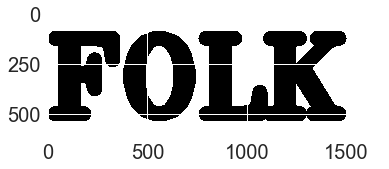

In [95]:
def imageGenre(s):# Create a black image
    cnt = len(s)
    img = np.zeros((612,cnt*420,3), np.uint8)
    
    # Write some Text
    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(img,s,(0,500),font, 18,(255,255,255),75)
    img = 255-img
    #Save image
    cv2.imwrite("folk.jpg", img)
    return img
plt.imshow(imageGenre('FOLK'))

In [96]:
def imageGenre(s):# Create a black image
    cnt = len(s)
    img = np.zeros((612,cnt*420,3), np.uint8)
    
    # Write some Text
    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(img,s,(0,500), font, 18,(255,255,255),85)
    img = 255-img
    #Save image
    cv2.imwrite("hiphop.jpg", img)
    return img
#plt.imshow(imageGenre('HIP-HOP'))

In [97]:
def imageGenre(s):# Create a black image
    cnt = len(s)
    img = np.zeros((612,cnt*420,3), np.uint8)
    
    # Write some Text
    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(img,s,(0,500), font, 18,(255,255,255),85)
    img = 255-img
    #Save image
    cv2.imwrite("house.jpg", img)
    return img
#plt.imshow(imageGenre('HOUSE'))

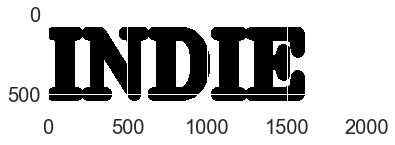

In [98]:
def imageGenre(s):# Create a black image
    cnt = len(s)
    img = np.zeros((612,cnt*420,3), np.uint8)
    
    # Write some Text
    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(img,s,(0,500), font, 18,(255,255,255),85)
    img = 255-img
    #Save image
    cv2.imwrite("Indie.jpg", img)
    return img
plt.imshow(imageGenre('INDIE'))

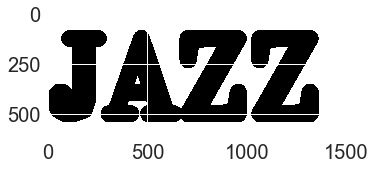

In [99]:
def imageGenre(s):# Create a black image
    cnt = len(s)
    img = np.zeros((612,cnt*420,3), np.uint8)
    
    # Write some Text
    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(img,s,(0,500), font, 18,(255,255,255),85)
    img = 255-img
    #Save image
    cv2.imwrite("jazz.jpg", img)
    return img
plt.imshow(imageGenre('JAZZ'))

In [100]:
def imageGenre(s):# Create a black image
    cnt = len(s)
    img = np.zeros((612,cnt*420,3), np.uint8)
    
    # Write some Text
    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(img,s,(0,500), font, 18,(255,255,255),85)
    img = 255-img
    #Save image
    cv2.imwrite("Metal.jpg", img)
    return img
#plt.imshow(imageGenre('METAL'))

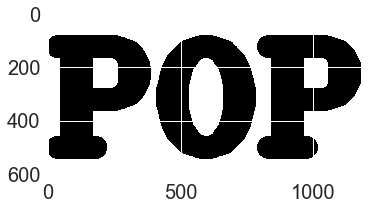

In [101]:
def imageGenre(s):# Create a black image
    cnt = len(s)
    img = np.zeros((612,cnt*420,3), np.uint8)
    
    # Write some Text
    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(img,s,(0,500), font, 18,(255,255,255),85)
    img = 255-img
    #Save image
    cv2.imwrite("POP.jpg", img)
    return img
plt.imshow(imageGenre('POP'))

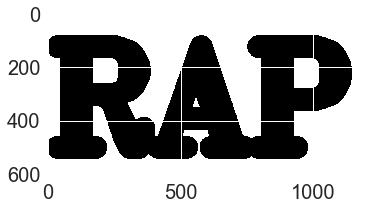

In [102]:
def imageGenre(s):# Create a black image
    cnt = len(s)
    img = np.zeros((612,cnt*420,3), np.uint8)
    
    # Write some Text
    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(img,s,(0,500), font, 18,(255,255,255),85)
    img = 255-img
    #Save image
    cv2.imwrite("RAP.jpg", img)
    return img
plt.imshow(imageGenre('RAP'))

In [103]:
def imageGenre(s):# Create a black image
    cnt = len(s)
    img = np.zeros((612,cnt*420,3), np.uint8)
    
    # Write some Text
    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(img,s,(0,500), font, 18,(255,255,255),75)
    img = 255-img
    #Save image
    cv2.imwrite("RNB.jpg", img)
    return img
#plt.imshow(imageGenre('RNB'))

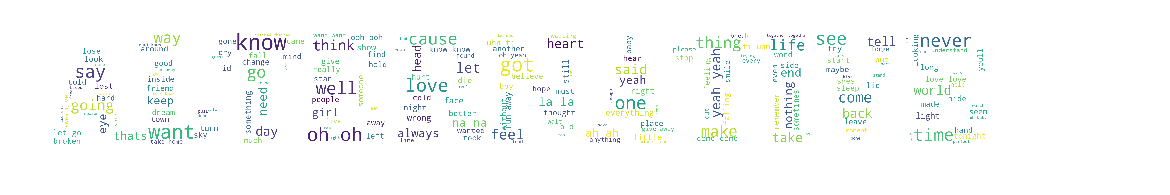

In [104]:
mask=np.array(Image.open("./ALTERNATIVE.jpg"))
mask=mask[:,:,1]
subset=df[df['alternative'] ==1 ]
text=subset['Lyrics1'].values
wc= WordCloud(background_color="white",max_words=200,mask=mask)
wc.generate(" ".join(text))
plt.figure(figsize=(20,5))
plt.axis("off")
#plt.title("Most frequent words of Alternative", fontsize=20)
plt.imshow(wc, alpha=0.98)
plt.show()

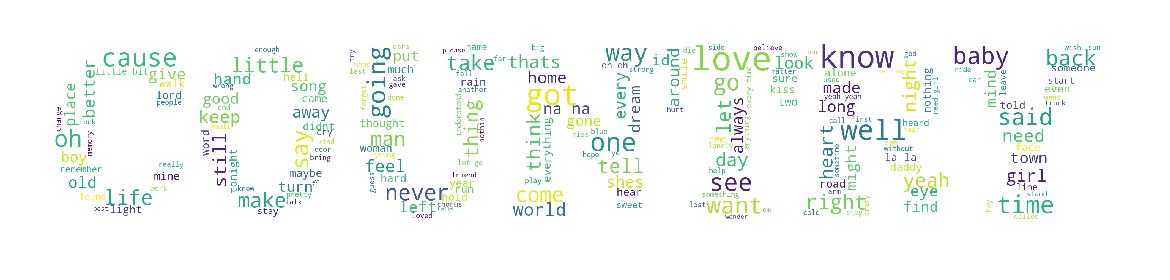

In [105]:
mask=np.array(Image.open("./COUNTRY.jpg"))
mask=mask[:,:,1]
subset=df[df['country'] ==1 ]
text=subset['Lyrics1'].values
wc= WordCloud(background_color="white",max_words=200,mask=mask)
wc.generate(" ".join(text))
plt.figure(figsize=(20,5))
plt.axis("off")
#plt.title("Most frequent words of Country", fontsize=20)
plt.imshow(wc, alpha=0.98)
plt.show()

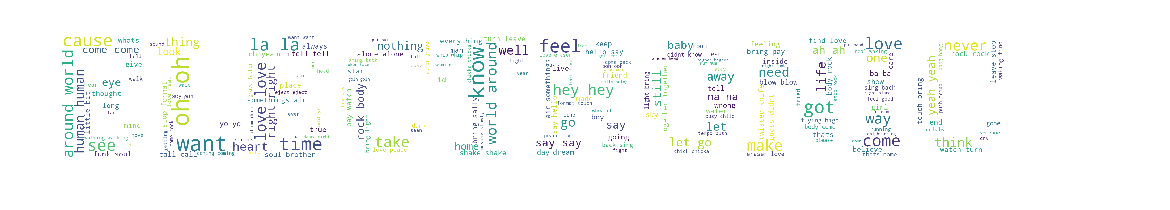

In [106]:
mask=np.array(Image.open("./ELECTRONIC.jpg"))
mask=mask[:,:,1]
subset=df[df['electronic'] ==1 ]
text=subset['Lyrics1'].values
wc= WordCloud(background_color="white",max_words=200,mask=mask)
wc.generate(" ".join(text))
plt.figure(figsize=(20,5))
plt.axis("off")
#plt.title("Most frequent words of Electronic", fontsize=20)
plt.imshow(wc, alpha=0.98)
plt.show()

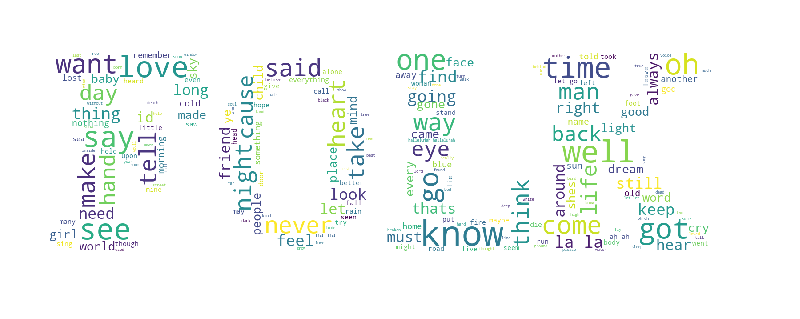

In [107]:
mask=np.array(Image.open("./FOLK.jpg"))
mask=mask[:,:,1]
subset=df[df['folk'] ==1 ]
text=subset['Lyrics1'].values
wc= WordCloud(background_color="white",max_words=200,mask=mask)
wc.generate(" ".join(text))
plt.figure(figsize=(20,5))
plt.axis("off")
#plt.title("Most frequent words of Folk", fontsize=20)
plt.imshow(wc, alpha=0.98)
plt.show()

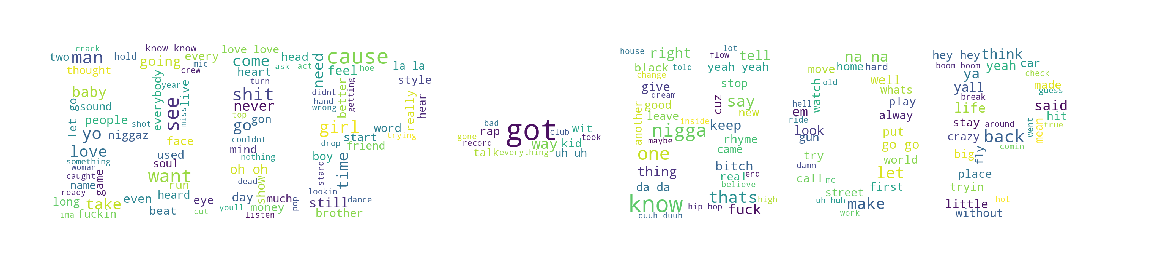

In [108]:
mask=np.array(Image.open("./HIPHOP.jpg"))
mask=mask[:,:,1]
subset=df[df['hiphop'] ==1 ]
text=subset['Lyrics1'].values
wc= WordCloud(background_color="white",max_words=200,mask=mask)
wc.generate(" ".join(text))
plt.figure(figsize=(20,5))
plt.axis("off")
#plt.title("Most frequent words of Hip-Hop", fontsize=20)
plt.imshow(wc, alpha=0.98)
plt.show()

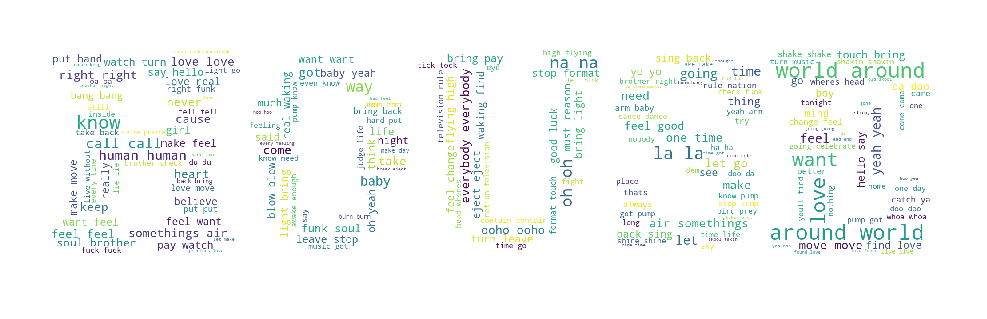

In [109]:
mask=np.array(Image.open("./house.jpg"))
mask=mask[:,:,1]
subset=df[df['house'] ==1 ]
text=subset['Lyrics1'].values
wc= WordCloud(background_color="white",max_words=200,mask=mask)
wc.generate(" ".join(text))
plt.figure(figsize=(20,5))
plt.axis("off")
#plt.title("Most frequent words of House", fontsize=20)
plt.imshow(wc, alpha=0.98)
plt.show()

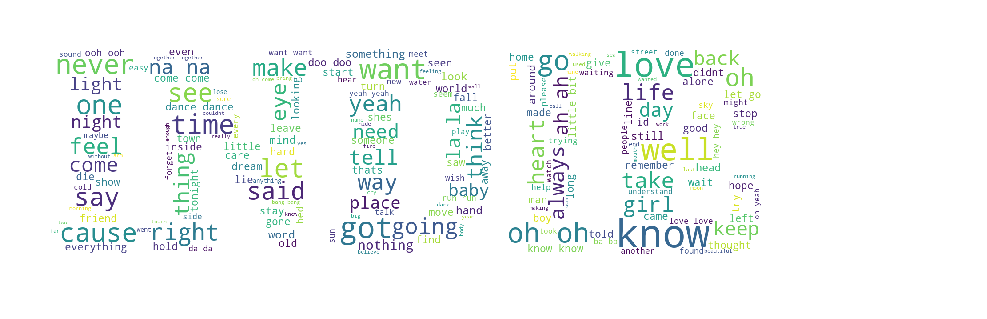

In [110]:
mask=np.array(Image.open("./indie.jpg"))
mask=mask[:,:,1]
subset=df[df['indie'] ==1 ]
text=subset['Lyrics1'].values
wc= WordCloud(background_color="white",max_words=200,mask=mask)
wc.generate(" ".join(text))
plt.figure(figsize=(20,5))
plt.axis("off")
#plt.title("Most frequent words of Indie", fontsize=20)
plt.imshow(wc, alpha=0.98)
plt.show()

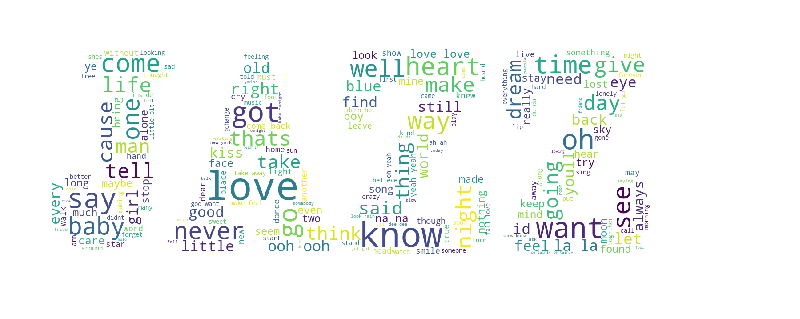

In [111]:
mask=np.array(Image.open("./Jazz.jpg"))
mask=mask[:,:,1]
subset=df[df['jazz'] ==1 ]
text=subset['Lyrics1'].values
wc= WordCloud(background_color="white",max_words=200,mask=mask)
wc.generate(" ".join(text))
plt.figure(figsize=(20,5))
plt.axis("off")
#plt.title("Most frequent words of Jazz", fontsize=20)
plt.imshow(wc, alpha=0.98)
plt.show()

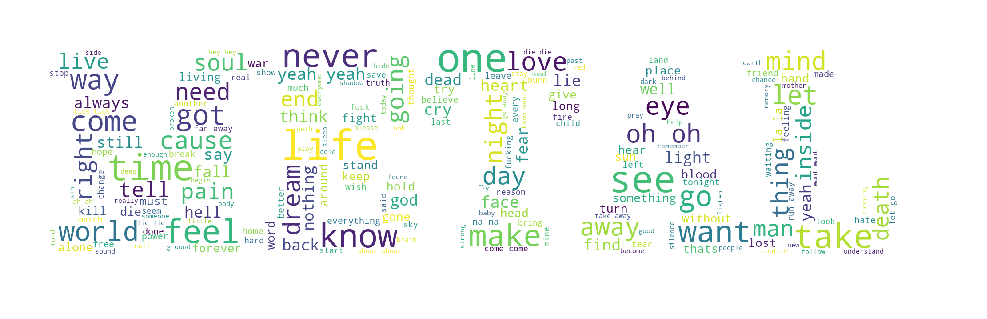

In [112]:
mask=np.array(Image.open("./metal.jpg"))
mask=mask[:,:,1]
subset=df[df['metal'] ==1 ]
text=subset['Lyrics1'].values
wc= WordCloud(background_color="white",max_words=200,mask=mask)
wc.generate(" ".join(text))
plt.figure(figsize=(20,5))
plt.axis("off")
#plt.title("Most frequent words of Metal", fontsize=20)
plt.imshow(wc, alpha=0.98)
plt.show()

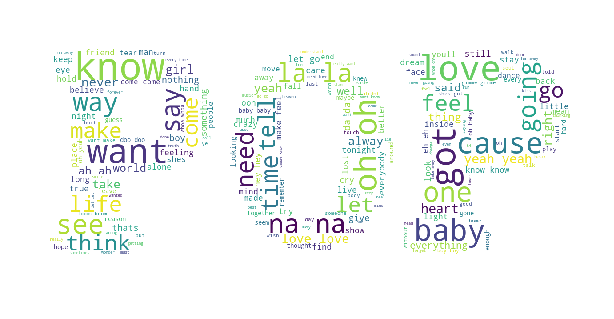

In [113]:
mask=np.array(Image.open("./pop.jpg"))
mask=mask[:,:,1]
subset=df[df['pop'] ==1 ]
text=subset['Lyrics1'].values
wc= WordCloud(background_color="white",max_words=200,mask=mask)
wc.generate(" ".join(text))
plt.figure(figsize=(20,5))
plt.axis("off")
#plt.title("Most frequent words of Pop", fontsize=20)
plt.imshow(wc, alpha=0.98)
plt.show()

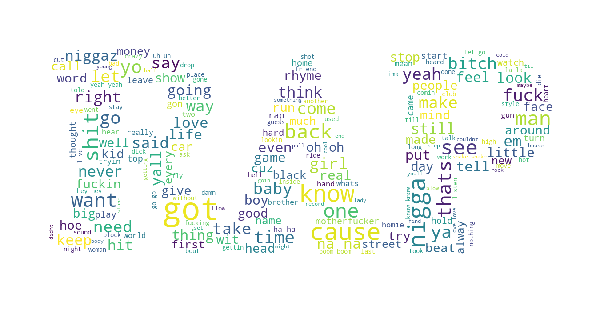

In [114]:
mask=np.array(Image.open("./rap.jpg"))
mask=mask[:,:,1]
subset=df[df['rap'] ==1 ]
text=subset['Lyrics1'].values
wc= WordCloud(background_color="white",max_words=200,mask=mask)
wc.generate(" ".join(text))
plt.figure(figsize=(20,5))
plt.axis("off")
#plt.title("Most frequent words of Rap", fontsize=20)
plt.imshow(wc, alpha=0.98)
plt.show()

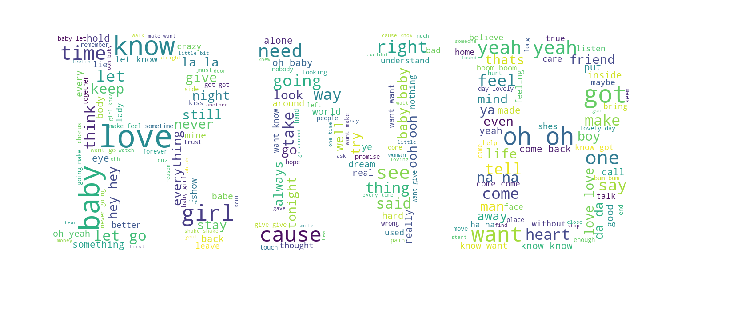

In [115]:
mask=np.array(Image.open("./rnb.jpg"))
mask=mask[:,:,1]
subset=df[df['rnb'] ==1 ]
text=subset['Lyrics1'].values
wc= WordCloud(background_color="white",max_words=200,mask=mask)
wc.generate(" ".join(text))
plt.figure(figsize=(20,5))
plt.axis("off")
#plt.title("Most frequent words of RNB", fontsize=20)
plt.imshow(wc, alpha=0.98)
plt.show()

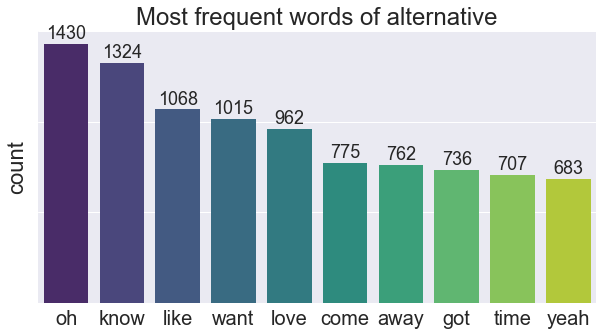

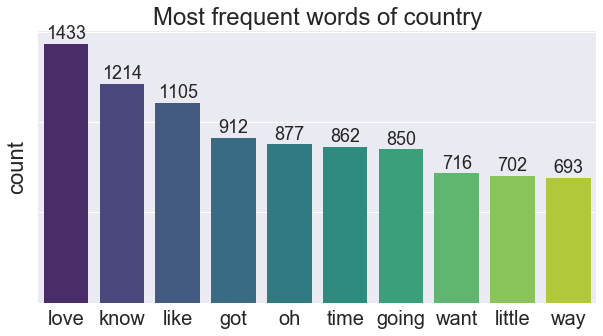

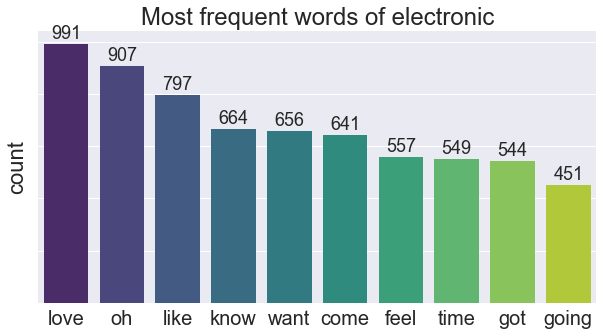

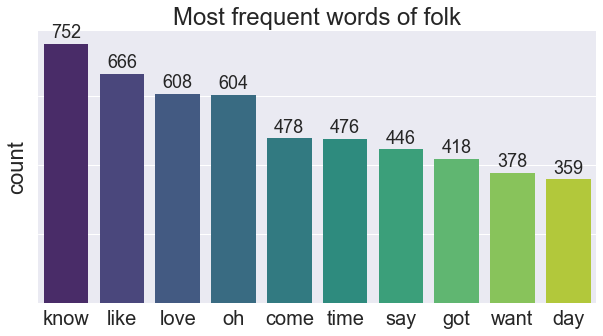

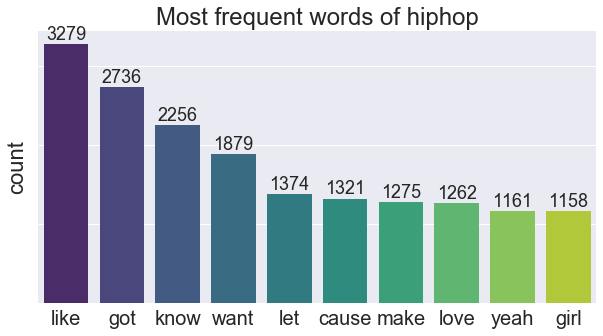

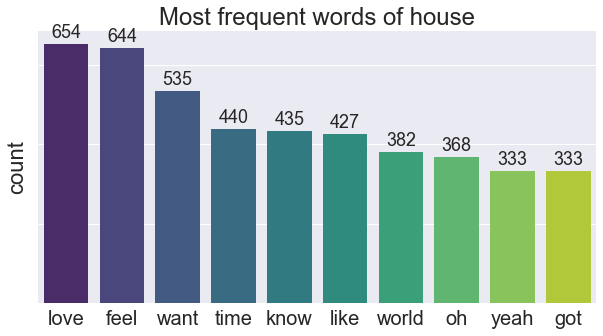

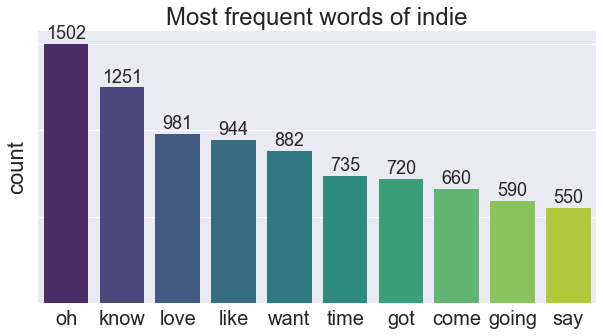

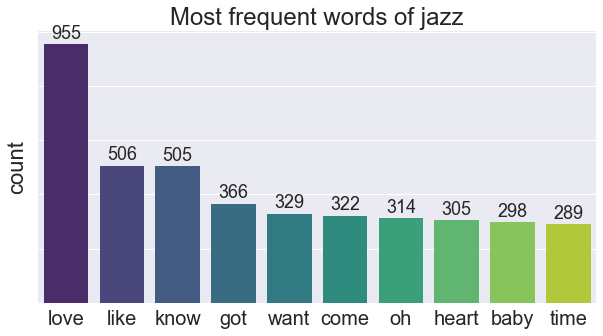

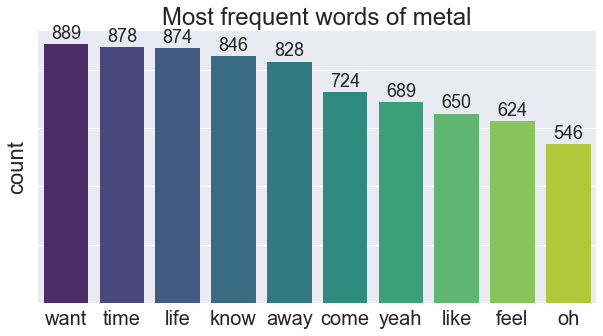

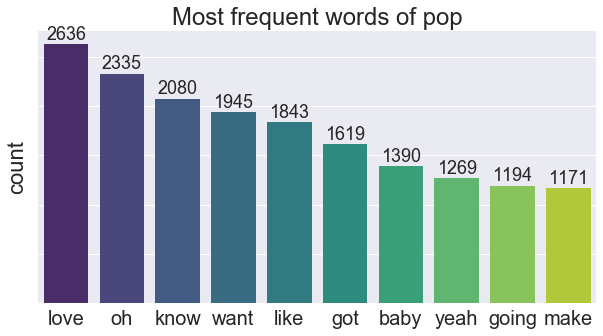

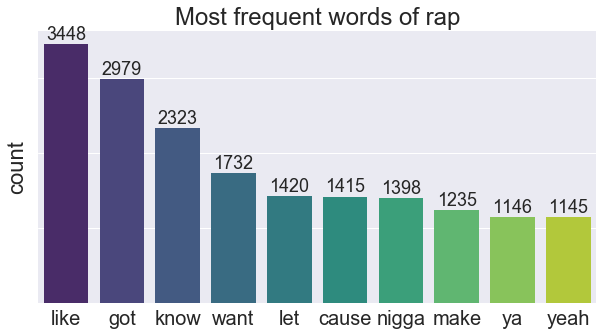

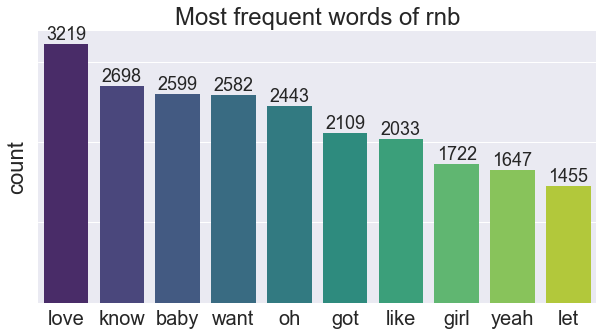

In [116]:
#most frequent words per genre

corpus=df['Lyrics1']
def get_top_n_words(corpu, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpu)
    bag_of_words = vec.transform(corpu)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

for i in range(3,15):
    co=df[df.iloc[:,i] == 1]['Lyrics1']
    common_words = get_top_n_words(co, 10)
    data = pd.DataFrame(common_words, columns = ['Common_Words' , 'count'])
    sns.set(font_scale = 2)
    plt.figure(figsize=(10,5))
    ax= sns.barplot(data['Common_Words'], data['count'], palette='viridis')
    plt.title("Most frequent words of {}".format(df.columns.values[i]))
    plt.xlabel('')
    rects = ax.patches
    labels=data['count']
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
    plt.setp(ax.get_xticklabels(), rotation=0)
    ax.set(yticklabels=[])
    plt.show()

## Top Features per Genre 

In [117]:
vec = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1), norm='l2', stop_words='english')
corpus=df['Lyrics1']
tfs=vec.fit_transform(corpus)
feature_array = np.array(vec.get_feature_names())
genre=df[df['alternative'] ==1 ]['Lyrics1']
response = vec.transform(genre)
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 10
top_n = feature_array[tfidf_sorting][:n]
print("Top 10 tf-idf of Alternative: \n{}".format(top_n.tolist()))

Top 10 tf-idf of Alternative: 
['apologize', 'worse', 'thing', 'pride', 'say', 'thats', 'promise', 'harder', 'truth', 'lost']


In [124]:
genre=df[df['country'] ==1 ]['Lyrics1']
response = vec.transform(genre)
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
n = 10
top_n = feature_array[tfidf_sorting][:n]
print("Top 10 tf-idf of Country: \n{}".format(top_n.tolist()))

Top 10 tf-idf of Country: 
['wondering', 'end', 'wake', 'easy', 'road', 'close', 'lost', 'run', 'fall', 'better']


In [125]:
genre=df[df['electronic'] ==1 ]['Lyrics1']
response = vec.transform(genre)
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
n = 10
top_n = feature_array[tfidf_sorting][:n]
print("Top 10 tf-idf of Electronic: \n{}".format(top_n.tolist()))

Top 10 tf-idf of Electronic: 
['spin', 'sugar', 'stick', 'stink', 'perfection', 'crawl', 'twist', 'attention', 'seen', 'need']


In [126]:
genre=df[df['folk'] ==1 ]['Lyrics1']
response = vec.transform(genre)
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
n = 10
top_n = feature_array[tfidf_sorting][:n]
print("Top 10 tf-idf of Folk: \n{}".format(top_n.tolist()))

Top 10 tf-idf of Folk: 
['troubled', 'needle', 'death', 'young', 'turn', 'life', 'withdraws', 'acryin', 'scape', 'dissolved']


In [152]:
genre=df[df['hiphop'] ==1 ]['Lyrics1']
response = vec.transform(genre)
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
n = 10
top_n = feature_array[tfidf_sorting][:n]
print("Top 10 tf-idf of Hip-Hop: \n{}".format(top_n.tolist()))

Top 10 tf-idf of Hip-Hop: 
['jerusalem', 'forget', 'supposed', 'tongue', 'going', 'hand', 'right', 'come', 'let', 'way']


In [153]:
genre=df[df['house'] ==1 ]['Lyrics1']
response = vec.transform(genre)
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
n = 10
top_n = feature_array[tfidf_sorting][:n]
print("Top 10 tf-idf of House: \n{}".format(top_n.tolist()))

Top 10 tf-idf of House: 
['fuck', 'shut', 'rum', 'turnin', 'groove', 'girl', 'sexy', 'bottle', 'going', 'club']


In [129]:
genre=df[df['indie'] ==1 ]['Lyrics1']
response = vec.transform(genre)
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
n = 10
top_n = feature_array[tfidf_sorting][:n]
print("Top 10 tf-idf of Indie: \n{}".format(top_n.tolist()))

Top 10 tf-idf of Indie: 
['bring', 'got', 'love', 'let', 'today', 'hold', 'footloose', 'foolswalk', 'foot', 'footage']


In [130]:
genre=df[df['jazz'] ==1 ]['Lyrics1']
response = vec.transform(genre)
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
n = 10
top_n = feature_array[tfidf_sorting][:n]
print("Top 10 tf-idf of Jazz: \n{}".format(top_n.tolist()))

Top 10 tf-idf of Jazz: 
['dream', 'linger', 'little', 'kiss', 'dear', 'nightie', 'tight', 'sycamore', 'sunbeam', 'miss']


In [133]:
genre=df[df['metal'] ==1 ]['Lyrics1']
response = vec.transform(genre)
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
n = 10
top_n = feature_array[tfidf_sorting][:n]
print("Top 10 tf-idf of Metal: \n{}".format(top_n.tolist()))

Top 10 tf-idf of Metal: 
['nymphetamine', 'sunsetter', 'vampiric', 'barless', 'discolors', 'loneliness', 'bared', 'incision', 'slot', 'submission']


In [134]:
genre=df[df['pop'] ==1 ]['Lyrics1']
response = vec.transform(genre)
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
n = 10
top_n = feature_array[tfidf_sorting][:n]
print("Top 10 tf-idf of Pop: \n{}".format(top_n.tolist()))

Top 10 tf-idf of Pop: 
['angel', 'talking', 'playing', 'overblown', 'bliss', 'thrown', 'heart', 'multitude', 'earth', 'celestial']


In [135]:
genre=df[df['rap'] ==1 ]['Lyrics1']
response = vec.transform(genre)
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
n = 10
top_n = feature_array[tfidf_sorting][:n]
print("Top 10 tf-idf of Rap: \n{}".format(top_n.tolist()))

Top 10 tf-idf of Rap: 
['drug', 'cocaine', 'government', 'coke', 'immortal', 'technique', 'country', 'loucipher', 'peruvian', 'guilty']


In [136]:
genre=df[df['rnb'] ==1 ]['Lyrics1']
response = vec.transform(genre)
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
n = 10
top_n = feature_array[tfidf_sorting][:n]
print("Top 10 tf-idf of RNB: \n{}".format(top_n.tolist()))

Top 10 tf-idf of RNB: 
['sad', 'rackin', 'song', 'torn', 'guess', 'crazy', 'radio', 'shake', 'love', 'brain']


In [137]:
#max f20 feature per genre
for i in range(3,15):
    co=df[df.iloc[:,i] == 1]['Lyrics1']
    vectorizer = TfidfVectorizer(max_features=20,strip_accents='unicode', analyzer='word', ngram_range=(1,1), norm='l2')
    tfidf=vectorizer.fit_transform(co)
    features = np.array(vectorizer.get_feature_names())
    print("\nTop features of {}:".format(df.columns.values[i]))
    print(features)


Top features of alternative:
['away' 'come' 'feel' 'get' 'go' 'got' 'know' 'let' 'like' 'love' 'never'
 'oh' 'one' 'say' 'see' 'take' 'time' 'want' 'well' 'yeah']

Top features of country:
['baby' 'back' 'cause' 'come' 'get' 'go' 'going' 'got' 'know' 'like'
 'little' 'love' 'never' 'oh' 'one' 'time' 'want' 'way' 'well' 'yeah']

Top features of electronic:
['come' 'feel' 'get' 'go' 'going' 'got' 'know' 'let' 'like' 'love' 'never'
 'oh' 'one' 'right' 'say' 'take' 'time' 'want' 'world' 'yeah']

Top features of folk:
['away' 'come' 'day' 'get' 'go' 'got' 'know' 'let' 'like' 'love' 'man'
 'never' 'oh' 'one' 'say' 'see' 'take' 'time' 'want' 'well']

Top features of hiphop:
['back' 'cause' 'come' 'get' 'girl' 'go' 'got' 'know' 'let' 'like' 'love'
 'make' 'man' 'oh' 'one' 'right' 'say' 'see' 'want' 'yeah']

Top features of house:
['around' 'baby' 'come' 'feel' 'get' 'go' 'going' 'got' 'know' 'let'
 'like' 'love' 'make' 'oh' 'right' 'take' 'time' 'want' 'world' 'yeah']

Top features of indie:


Maximum token value throughout whole dataset

In [138]:
text=df['Lyrics1']
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1), norm='l2')
vectorizer.fit(text)
new1 = vectorizer.transform(text)

# find maximum value for each of the features over all of dataset:
max_val = new1.max(axis=0).toarray().ravel()

#sort weights from smallest to biggest and extract their indices 
sort_by_tfidf = max_val.argsort()
feature_names = np.array(vectorizer.get_feature_names())
print("Features with lowest tfidf:\n{}".format(
      feature_names[sort_by_tfidf[:3]]))

print("\nFeatures with highest tfidf: \n{}".format(
      feature_names[sort_by_tfidf[-3:]]))

Features with lowest tfidf:
['classified' 'superball' 'travoltin']

Features with highest tfidf: 
['hey' 'na' 'brainwasher']


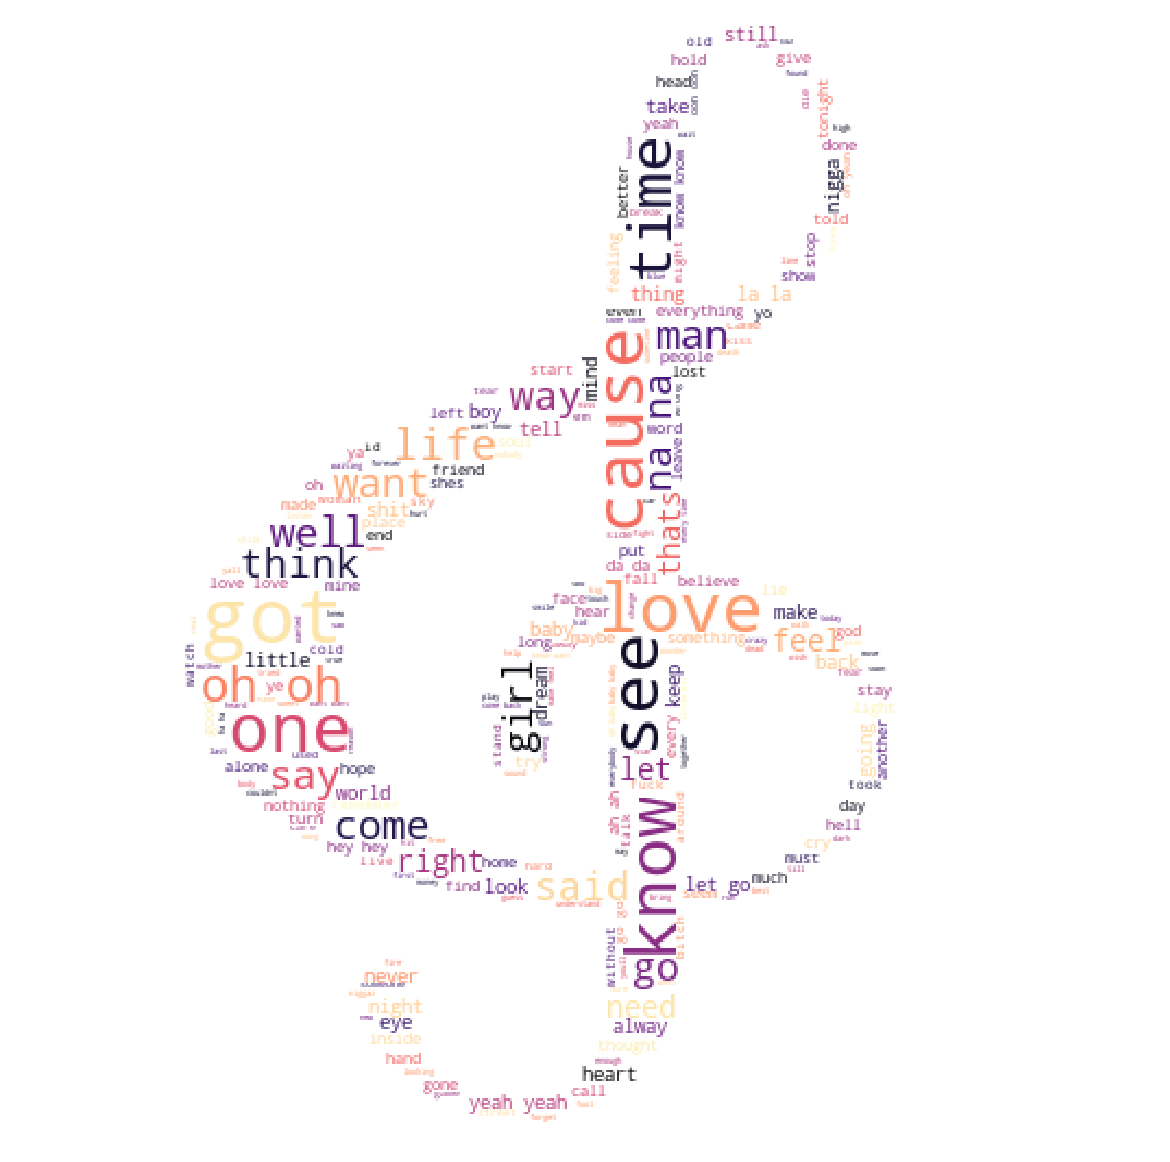

In [139]:
#overall wordcloud
mask=np.array(Image.open("./music_notes.png"))
text=df['Lyrics1'].values
wc= WordCloud(background_color="white",max_words=5000,mask=mask)
wc.generate(" ".join(text))
plt.figure(figsize=(20,50))
plt.axis("off")
#plt.title("Words frequented in Lyrics", fontsize=20)
plt.imshow(wc.recolor(colormap= 'magma' , random_state=244), alpha=0.98)
plt.savefig('treble_clef.png', bbox_inches='tight')

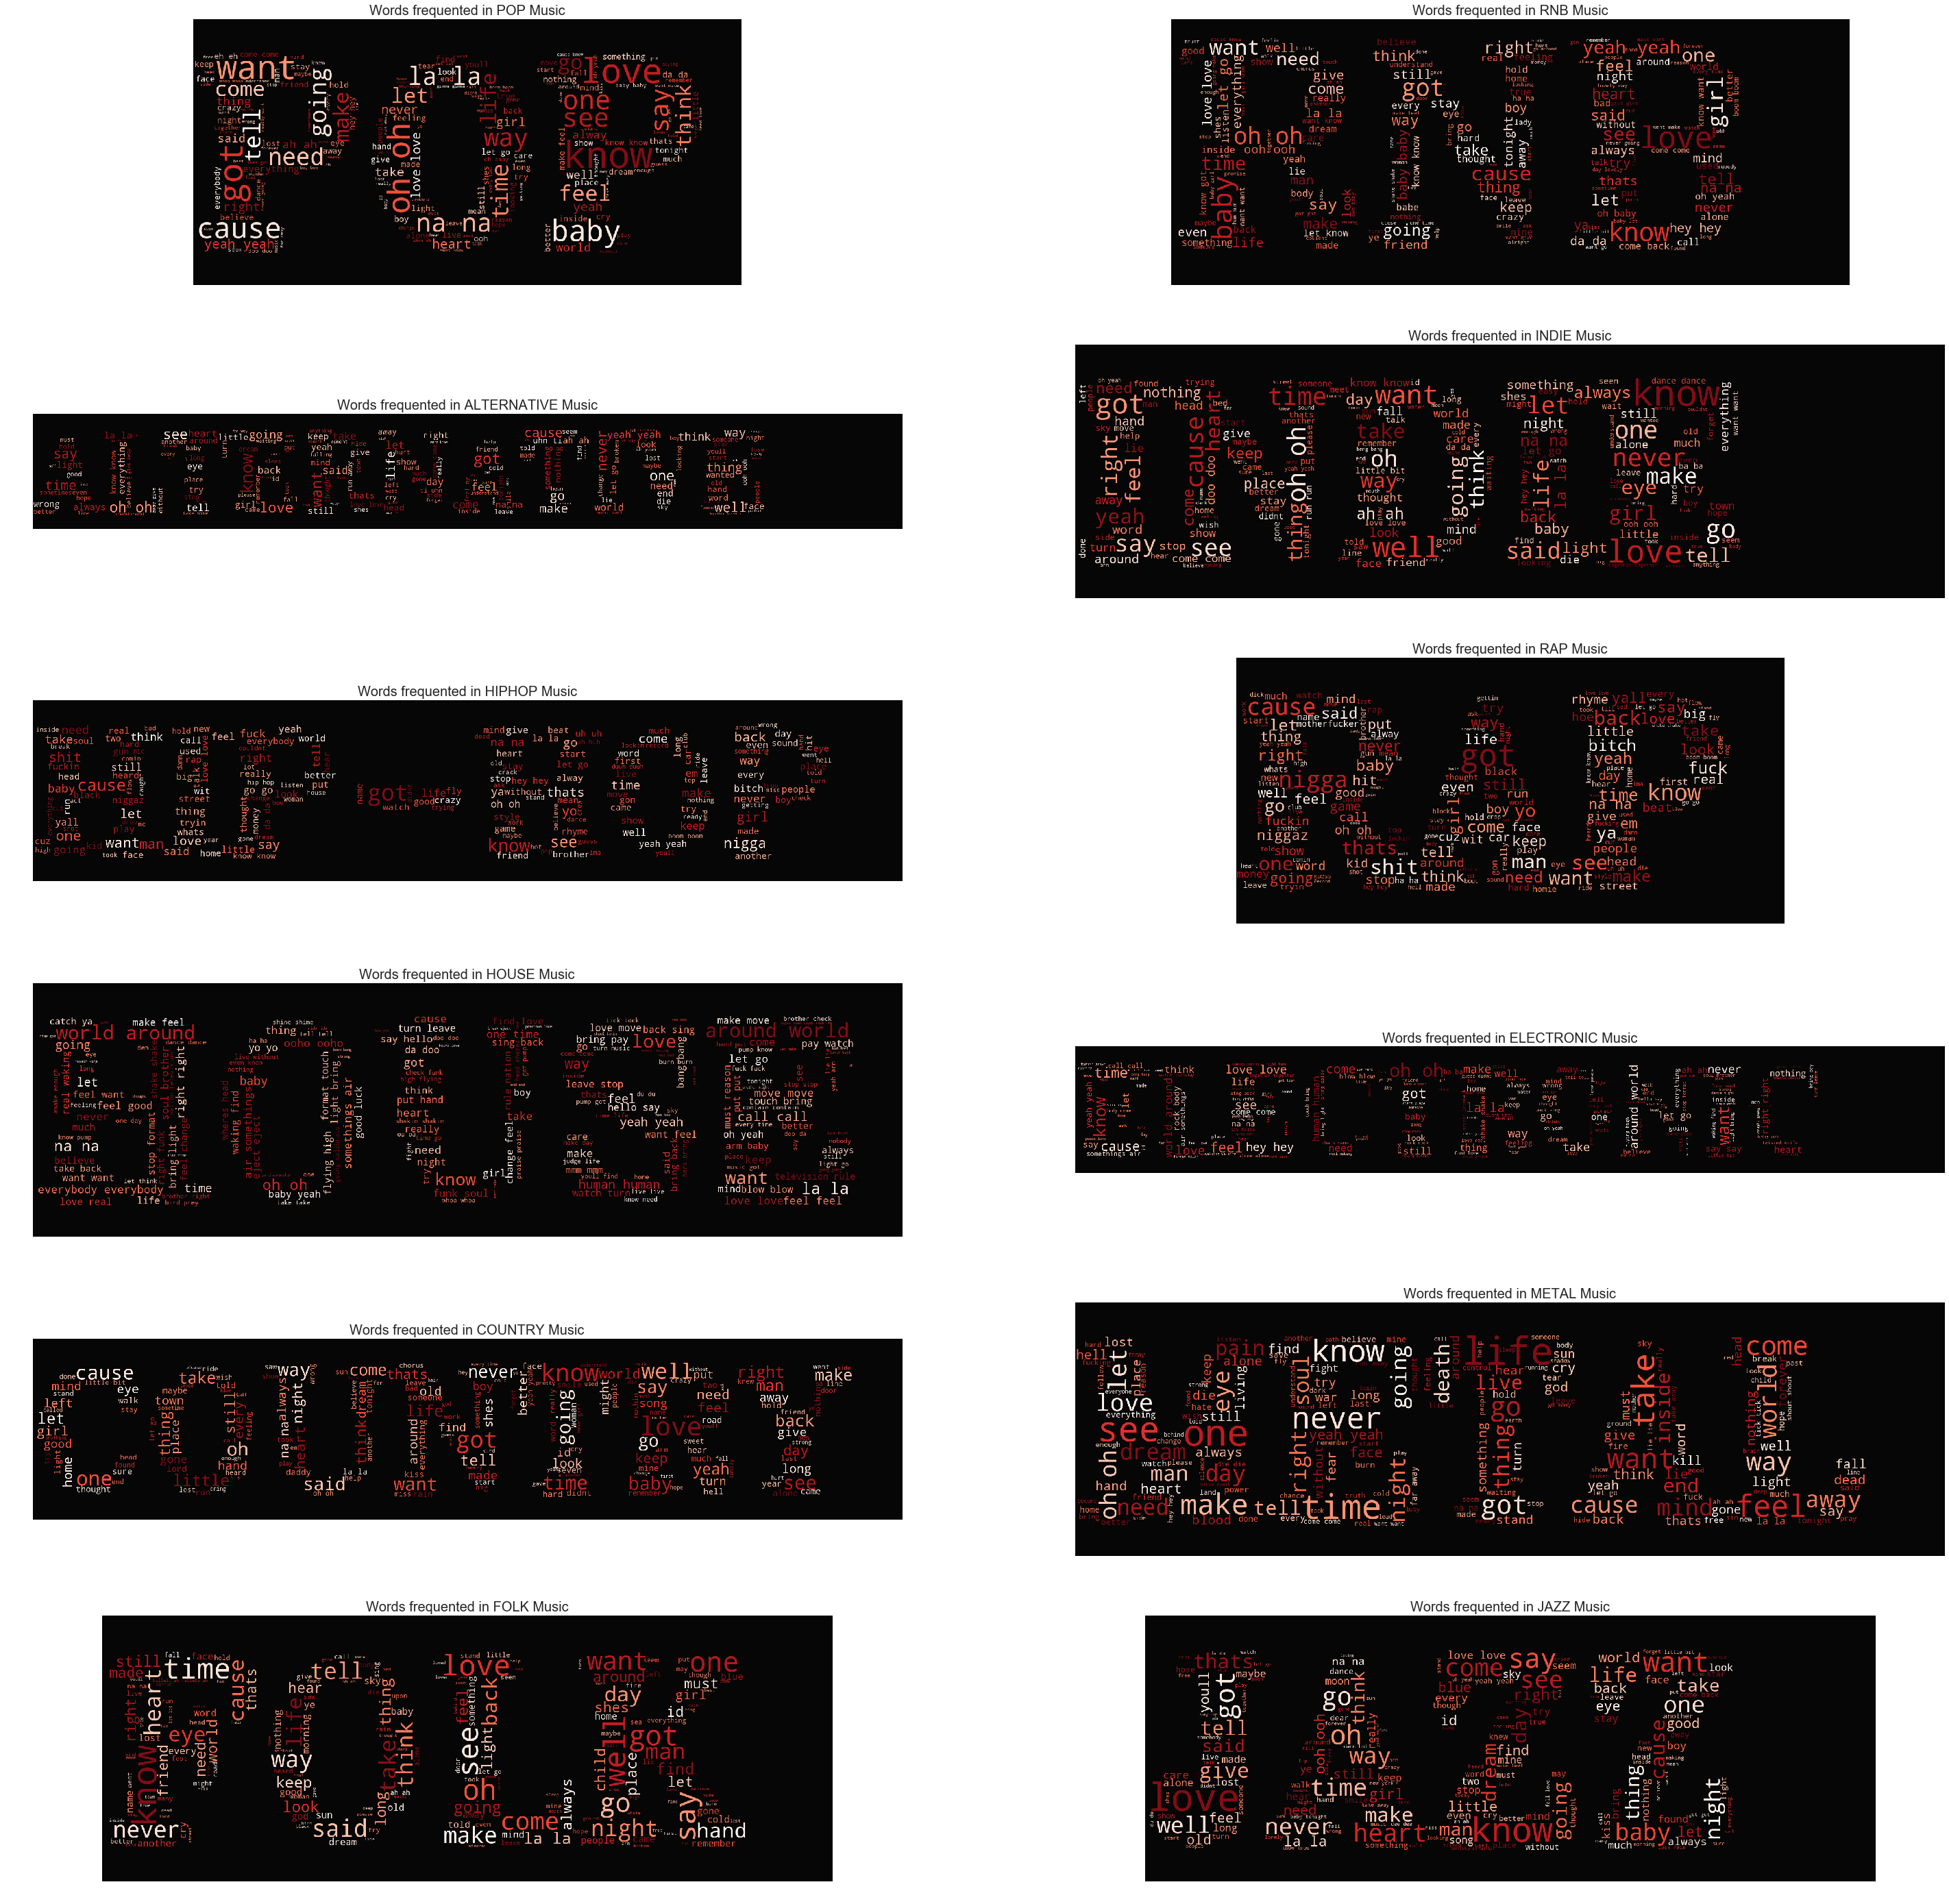

In [140]:
#POP
pop_mask=np.array(Image.open("./POP.jpg"))
pop_mask=pop_mask[:,:,1]
subset=df[df['pop'] ==1 ]
pop_text=subset['Lyrics1'].values
wc= WordCloud(background_color="black",max_words=200,mask=pop_mask)
wc.generate(" ".join(pop_text))
plt.figure(figsize=(50,50))
plt.subplot(621)
plt.axis("off")
plt.title("Words frequented in POP Music", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)
#RNB
plt.subplot(622)
rnb_mask=np.array(Image.open("./RNB.jpg"))
rnb_mask=rnb_mask[:,:,1]
subset1=df[df['rnb'] ==1 ]
rnb_text=subset1['Lyrics1'].values
wc= WordCloud(background_color="black",max_words=200,mask=rnb_mask)
wc.generate(" ".join(rnb_text))

plt.axis("off")
plt.title("Words frequented in RNB Music", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)
#ALTERNATIVE
plt.subplot(623)
a_mask=np.array(Image.open("./alternative.jpg"))
a_mask=a_mask[:,:,1]
subset2=df[df['alternative'] ==1 ]
a_text=subset2['Lyrics1'].values
wc= WordCloud(background_color="black",max_words=200,mask=a_mask)
wc.generate(" ".join(a_text))

plt.axis("off")
plt.title("Words frequented in ALTERNATIVE Music", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)
#INDIE
plt.subplot(624)
indie_mask=np.array(Image.open("./indie.jpg"))
indie_mask=indie_mask[:,:,1]
subset3=df[df['indie'] ==1 ]
indie_text=subset3['Lyrics1'].values
wc= WordCloud(background_color="black",max_words=200,mask=indie_mask)
wc.generate(" ".join(indie_text))

plt.axis("off")
plt.title("Words frequented in INDIE Music", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)
#HIPHOP
plt.subplot(625)
hh_mask=np.array(Image.open("./hiphop.jpg"))
hh_mask=hh_mask[:,:,1]
subset4=df[df['hiphop'] ==1 ]
hh_text=subset4['Lyrics1'].values
wc= WordCloud(background_color="black",max_words=200,mask=hh_mask)
wc.generate(" ".join(hh_text))

plt.axis("off")
plt.title("Words frequented in HIPHOP Music", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)
#RAP
plt.subplot(626)
rap_mask=np.array(Image.open("./RAP.jpg"))
rap_mask=rap_mask[:,:,1]
subset11=df[df['rap'] ==1 ]
rap_text=subset11['Lyrics1'].values
wc= WordCloud(background_color="black",max_words=200,mask=rap_mask)
wc.generate(" ".join(rap_text))

plt.axis("off")
plt.title("Words frequented in RAP Music", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)
#HOUSE
plt.subplot(627)
house_mask=np.array(Image.open("./house.jpg"))
house_mask=house_mask[:,:,1]
subset5=df[df['house'] ==1 ]
house_text=subset5['Lyrics1'].values
wc= WordCloud(background_color="black",max_words=200,mask=house_mask)
wc.generate(" ".join(house_text))

plt.axis("off")
plt.title("Words frequented in HOUSE Music", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)
#ELECTRONIC
plt.subplot(628)
elec_mask=np.array(Image.open("./electronic.jpg"))
elec_mask=elec_mask[:,:,1]
subset6=df[df['electronic'] ==1 ]
elec_text=subset6['Lyrics1'].values
wc= WordCloud(background_color="black",max_words=200,mask=elec_mask)
wc.generate(" ".join(elec_text))

plt.axis("off")
plt.title("Words frequented in ELECTRONIC Music", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)
#COUNTRY
plt.subplot(629)
country_mask=np.array(Image.open("./country.jpg"))
country_mask=country_mask[:,:,1]
subset7=df[df['country'] ==1 ]
country_text=subset7['Lyrics1'].values
wc= WordCloud(background_color="black",max_words=200,mask=country_mask)
wc.generate(" ".join(country_text))

plt.axis("off")
plt.title("Words frequented in COUNTRY Music", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)
#METAL
plt.subplot(6,2,10)
metal_mask=np.array(Image.open("./metal.jpg"))
metal_mask=metal_mask[:,:,1]
subset8=df[df['metal'] ==1 ]
metal_text=subset8['Lyrics1'].values
wc= WordCloud(background_color="black",max_words=200,mask=metal_mask)
wc.generate(" ".join(metal_text))

plt.axis("off")
plt.title("Words frequented in METAL Music", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)
#FOLK
plt.subplot(6,2,11)
folk_mask=np.array(Image.open("./folk.jpg"))
folk_mask=folk_mask[:,:,1]
subset9=df[df['folk'] ==1 ]
folk_text=subset9['Lyrics1'].values
wc= WordCloud(background_color="black",max_words=200,mask=folk_mask)
wc.generate(" ".join(folk_text))

plt.axis("off")
plt.title("Words frequented in FOLK Music", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)
#JAZZ
plt.subplot(6,2,12)
jazz_mask=np.array(Image.open("./JAZZ.jpg"))
jazz_mask=jazz_mask[:,:,1]
subset10=df[df['jazz'] ==1 ]
jazz_text=subset10['Lyrics1'].values
wc= WordCloud(background_color="black",max_words=200,mask=jazz_mask)
wc.generate(" ".join(jazz_text))

plt.axis("off")
plt.title("Words frequented in JAZZ Music", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)
plt.show()